# IMPORT PACKAGES

In [57]:
import pandas as pd
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime
import warnings
import time
import gc  # For memory management
warnings.filterwarnings('ignore')
from matplotlib.ticker import StrMethodFormatter

from typing import List, Literal, Tuple, Optional
from concurrent.futures import ThreadPoolExecutor, as_completed

# LOAD DATA

## Datasets

### EMORY EXR

In [13]:
#loading tables
def load_table(filename, dataset='EmoryCXR'):
    """Load CSV tables from dataset."""
    base_paths = {
        'EmoryCXR': '/mnt/fsx/embeddings/EmoryCXR/Tables/',
        'MIMIC': '/mnt/fsx/embeddings/MIMIC/Tables/',
        'MRKR': '/mnt/fsx/embeddings/MRKR/Tables/',
        'EMBED': '/mnt/fsx/embeddings/EMBED/Tables/'
    }
    
    if dataset not in base_paths:
        raise ValueError(f"Dataset '{dataset}' not supported. Available: {list(base_paths.keys())}")
    
    file_path = os.path.join(base_paths[dataset], filename)
    return pd.read_csv(file_path)

### MIMIC EXR

In [14]:
#loading tables
def load_table(filename, dataset='EmoryCXR'):
    """Load CSV tables from dataset."""
    base_paths = {
        'EmoryCXR': '/mnt/fsx/embeddings/EmoryCXR/Tables/',
        'MIMIC': '/mnt/fsx/embeddings/MIMIC/Tables/',
        'MRKR': '/mnt/fsx/embeddings/MRKR/Tables/',
        'EMBED': '/mnt/fsx/embeddings/EMBED/Tables/'
    }
    
    if dataset not in base_paths:
        raise ValueError(f"Dataset '{dataset}' not supported. Available: {list(base_paths.keys())}")
    
    file_path = os.path.join(base_paths[dataset], filename)
    return pd.read_csv(file_path)

## Embeddings

#### Loading Pre-extracted Vector Embeddings into Pandas DataFrames

In [44]:
# Core data manipulation and numerical computing
import os
import numpy as np
import pandas as pd

# Progress tracking for long-running operations
from tqdm import tqdm

# Type hints for better code documentation and IDE support
from typing import List, Literal, Tuple, Optional

# Concurrent processing for improved performance
from concurrent.futures import ThreadPoolExecutor, as_completed

USERNAME='meghana'

In [45]:
def _load_single_embedding(sop: str, dataset_path: str, FM: str) -> Tuple[str, Optional[np.ndarray]]:
    """
    Load a single embedding file from disk.
    
    This helper function handles the loading of individual .npy files containing 
    pre-computed vector embeddings. It includes error handling for missing files
    and corrupted data.
    
    Args:
        sop (str): SOP (Study/Series/Image) identifier - unique ID for the embedding
        dataset_path (str): Base path to the dataset embeddings directory
        FM (str): Feature model name (e.g., 'RAD-DINO', 'MedImageInsights')
    
    Returns:
        Tuple[str, Optional[np.ndarray]]: 
            - First element: the SOP identifier (for tracking)
            - Second element: loaded embedding array or None if loading failed
    """
    # Construct the full path to the embedding file
    # Format: dataset_path/embds_{FM}/{sop}.npy
    embedding_file = os.path.join(dataset_path, f'embds_{FM}', sop + '.npy')
    
    # Check if the embedding file exists before attempting to load
    if not os.path.exists(embedding_file):
        print(f"Warning: Embedding file not found for SOP '{sop}': {embedding_file}")
        return sop, None
        
    try:
        # Load the numpy array from disk
        # Embeddings are typically stored as .npy files for efficient loading
        embd = np.load(embedding_file)
        return sop, embd
    except Exception as e:
        # Handle any errors during file loading (corruption, permissions, etc.)
        print(f"Error loading embedding for SOP '{sop}': {e}")
        return sop, None

def load_embeddings(
    SOP: List[str], 
    dataset: Literal['EmoryCXR','MIMIC','MRKR','EMBED'] = 'EmoryCXR', 
    FM: Literal['MedImageInsights','RAD-DINO','CheXagent','MedGemma','Mammo-CLIP','BiomedCLIP'] = 'RAD-DINO',
    max_workers: Optional[int] = None
) -> pd.DataFrame:
    """
    Load embeddings for multiple SOPs in parallel and return as a pandas DataFrame.
    
    This function efficiently loads vector embeddings for a list of identifiers using
    parallel processing. The embeddings are loaded from pre-computed .npy files and
    organized into a pandas DataFrame for easy manipulation and analysis.
    
    Args:
        SOP (List[str]): List of SOP identifiers to load embeddings for
        dataset (Literal): Dataset name - specifies which dataset's embeddings to load
            Options: 'EmoryCXR', 'MIMIC', 'MRKR', 'EMBED'
        FM (Literal): Feature model name - specifies which embedding model to use
            Options: 'MedImageInsights', 'RAD-DINO', 'CheXagent', 'MedGemma', 'Mammo-CLIP'
        max_workers (Optional[int]): Maximum number of parallel worker threads
            Limited to 4 workers max to prevent system overload. Defaults to 4.
    
    Returns:
        pd.DataFrame: DataFrame with:
            - Rows: Each SOP identifier
            - Columns: Embedding dimensions (typically 768, 1024, or 2048 features)
            - Index: 'SOP' column containing the identifiers
    
    Raises:
        TypeError: If SOP is not a list
        ValueError: If SOP list is empty or invalid dataset/FM specified
        RuntimeError: If no embeddings could be loaded successfully
    """
    # Input validation - ensure SOP is a list
    if not isinstance(SOP, list):
        raise TypeError("SOP must be a list of identifiers")
    
    # Input validation - ensure SOP list is not empty
    if not SOP:
        raise ValueError("SOP list cannot be empty")
    
    # Dataset path mapping - defines where embeddings are stored for each dataset
    path_dict = {
        'EmoryCXR': f'/home/jupyter-{USERNAME}/fsx/embeddings/EmoryCXR/',
        'MIMIC': f'/home/jupyter-{USERNAME}/fsx/embeddings/MIMIC/',
        'MRKR': f'/home/jupyter-{USERNAME}/fsx/embeddings/MRKR/',
        'EMBED': f'/home/jupyter-{USERNAME}/fsx/embeddings/EMBED/'
    }
    
    # Validate dataset parameter
    if dataset not in path_dict:
        raise ValueError(f"Dataset '{dataset}' not supported. Available: {list(path_dict.keys())}")
    
    # Supported feature models - each produces different embedding dimensions
    FMs = ['MedImageInsights','RAD-DINO','CheXagent','MedGemma','Mammo-CLIP','BiomedCLIP']
    if FM not in FMs:
        raise ValueError(f"FM '{FM}' not supported. Available: {FMs}")
    
    # Get the base path for the selected dataset
    dataset_path = path_dict[dataset]
    
    # Dictionary to store successfully loaded embeddings
    embds_dict = {}
    
    # Parallel loading with thread pool
    # Limit to 4 workers maximum to prevent overwhelming the file system
    effective_max_workers = min(max_workers, 4) if max_workers is not None else 4
    
    with ThreadPoolExecutor(max_workers=effective_max_workers) as executor:
        # Submit all loading tasks to the thread pool
        future_to_sop = {
            executor.submit(_load_single_embedding, sop, dataset_path, FM): sop 
            for sop in SOP
        }
        
        # Collect results as they complete, with progress tracking
        for future in tqdm(as_completed(future_to_sop), 
                          total=len(SOP), 
                          desc=f"Loading {FM} embeddings"):
            sop, embedding = future.result()
            
            # Only store successfully loaded embeddings
            if embedding is not None:
                embds_dict[sop] = embedding
    
    # Ensure at least some embeddings were loaded successfully
    if not embds_dict:
        raise RuntimeError("No embeddings were successfully loaded")
    
    # Convert dictionary to DataFrame
    # - Keys become column names (SOPs)
    # - Values become column data (embedding vectors)
    # - Transpose so SOPs become rows instead of columns
    # - Reset index to make SOP identifiers a proper column
    df = pd.DataFrame(embds_dict).T.reset_index(names=['SOP'])
    
    print(f"Successfully loaded {len(embds_dict)} embeddings out of {len(SOP)} requested")
    print(f"Embedding shape: {df.shape[1]-1}")
    
    return df

#### Metadata Loading

In [46]:
# =============================================================================
# DATASET AND MODEL CONFIGURATION
# =============================================================================
# This section defines the core configuration for loading embeddings.
# Modify these variables to switch between datasets or feature models.

# Primary dataset selection
DATASET = 'MIMIC'  # Current dataset being analyzed
                      # Options: 'EmoryCXR', 'MIMIC', 'MRKR', 'EMBED'

# Feature model selection
FM = 'MedGemma'          # Embedding model to use for analysis
                         # Available models:
                         # - 'MedImageInsights'
                         # - 'RAD-DINO'
                         # - 'CheXagent'
                         # - 'MedGemma'
                         # - 'Mammo-CLIP'
                         # - 'BiomedCLIP'

# =============================================================================
# DATASET-SPECIFIC FILE PATHS
# =============================================================================
# These paths point to the metadata and embedding availability files.
# Each dataset has its own directory structure and naming conventions.

# Main metadata file containing clinical and imaging information
#META_PATH = '/mnt/NAS3/CXR/EmoryCXRv2/TABLES/EmoryCXR_v2_metadata_08112025.csv'
####
# CHANGE /jupyter-boon/ TO YOUR USERNAME - jupyter-{username}
META_PATH = f'/home/jupyter-{USERNAME}/fsx/embeddings/MIMIC/Tables/mimic-cxr-2.0.0-metadata.csv'
####
# Dataset alternatives (uncomment and modify DATASET variable above):
# MIMIC: '/mnt/NAS3/CXR/MIMIC_CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.csv'
# MRKR:  '/mnt/NAS3/MRKR_dataset/MRKR_processed_images_08112025.csv'
# EMBED: '/mnt/NAS3/EMBED_dataset/EMBED_metadata.csv'

# Embedding availability list - tracks which images have pre-computed embeddings
EMBDS_LIST_PATH = f'/home/jupyter-{USERNAME}/fsx/embeddings/MIMIC/embds_list.csv'
# This CSV contains boolean columns for each feature model indicating availability
# Dataset alternatives:
# MIMIC: '/mnt/NAS3/Embeddings/MIMIC/embds_list.csv'
# MRKR:  '/mnt/NAS3/Embeddings/MRKR/embds_list.csv'
# EMBED: '/mnt/NAS3/Embeddings/EMBED/embds_list.csv'

# =============================================================================
# DATASET-SPECIFIC IDENTIFIER COLUMNS
# =============================================================================
# Different datasets use different column names for image identifiers.
# This mapping ensures compatibility across datasets.

IMAGE_ID_COLUMN = 'dicom_id'  
# Dataset-specific identifier columns:
# EmoryCXR: 'SOP' 
# MRKR: 'SOP'
# MIMIC: 'dicom_id'  
# EMBED: 'SOP'  

# =============================================================================
# QUICK DATASET SWITCHING GUIDE
# =============================================================================
# To switch datasets, update these three variables:
# 
# For MIMIC-CXR:
#   DATASET = 'MIMIC'
#   IMAGE_ID_COLUMN = 'dicom_id'
#   Update META_PATH and EMBDS_LIST_PATH to MIMIC paths
#
# For MRKR:
#   DATASET = 'MRKR' 
#   IMAGE_ID_COLUMN = 'SOP'
#   Update META_PATH and EMBDS_LIST_PATH to MRKR paths
#
# For EMBED:
#   DATASET = 'EMBED'
#   IMAGE_ID_COLUMN = 'SOP'
#   Update META_PATH and EMBDS_LIST_PATH to EMBED paths

In [47]:
# Load the main metadata file
if DATASET == 'EMBED':
    meta = pd.read_parquet(META_PATH)
else:
    meta = pd.read_csv(META_PATH)

# Load the list of available embeddings
embds_list = pd.read_csv(EMBDS_LIST_PATH)

# Merge metadata with embedding availability
meta = meta.merge(embds_list, on=IMAGE_ID_COLUMN, how='inner')

# Display the merged metadata
meta

dicom_id  subject_id  study_id  \
0       02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267   
1       174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962    10000032  50414267   
2       2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab    10000032  53189527   
3       e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c    10000032  53189527   
4       68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714    10000032  53911762   
...                                              ...         ...       ...   
377105  428e2c18-5721d8f3-35a05001-36f3d080-9053b83c    19999733  57132437   
377106  58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9    19999733  57132437   
377107  58766883-376a15ce-3b323a28-6af950a0-16b793bd    19999987  55368167   
377108  7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08    19999987  58621812   
377109  1a1fe7e3-cbac5d93-b339aeda-86bb86b5-4f31e82e    19999987  58971208   

       PerformedProcedureStepDescription ViewPosition  Rows  Columns  \
0                     CHEST (PA AND LAT)           PA  3056     2544   
1                     CHEST (PA AND LAT)      LATERAL  3056     2544   
2                     CHEST (PA AND LAT)           PA  3056     2544   
3                     CHEST (PA AND LAT)      LATERAL  3056     2544   
4                    CHEST (PORTABLE AP)           AP  2705     2539   
...                                  ...          ...   ...      ...   
377105                CHEST (PA AND LAT)           PA  3056     2544   
377106                CHEST (PA AND LAT)      LATERAL  3056     2544   
377107               CHEST (PORTABLE AP)           AP  2544     3056   
377108               CHEST (PORTABLE AP)           AP  3056     2544   
377109               CHEST (PORTABLE AP)           AP  3056     2544   

        StudyDate   StudyTime ProcedureCodeSequence_CodeMeaning  \
0        21800506  213014.531                CHEST (PA AND LAT)   
1        21800506  213014.531                CHEST (PA AND LAT)   
2        21800626  165500.312                CHEST (PA AND LAT)   
3        21800626  165500.312                CHEST (PA AND LAT)   
4        21800723   80556.875               CHEST (PORTABLE AP)   
...           ...         ...                               ...   
377105   21520708  224550.171                CHEST (PA AND LAT)   
377106   21520708  224550.171                CHEST (PA AND LAT)   
377107   21451104   51448.218               CHEST (PORTABLE AP)   
377108   21451102  202809.234               CHEST (PORTABLE AP)   
377109   21451103   50507.625               CHEST (PORTABLE AP)   

       ViewCodeSequence_CodeMeaning  \
0                  postero-anterior   
1                           lateral   
2                  postero-anterior   
3                           lateral   
4                  antero-posterior   
...                             ...   
377105             postero-anterior   
377106                      lateral   
377107             antero-posterior   
377108             antero-posterior   
377109             antero-posterior   

       PatientOrientationCodeSequence_CodeMeaning  MedImageInsights  \
0                                           Erect              True   
1                                           Erect             False   
2                                           Erect              True   
3                                           Erect             False   
4                                             NaN              True   
...                                           ...               ...   
377105                                      Erect             False   
377106                                      Erect             False   
377107                                      Erect             False   
377108                                      Erect             False   
377109                                  Recumbent             False   

        CheXagent  RAD-DINO  MedGemma  BiomedCLIP  
0            True      True      True        True  
1          

In [101]:
meta.columns

Index(['dicom_id', 'subject_id', 'study_id',
       'PerformedProcedureStepDescription', 'ViewPosition', 'Rows', 'Columns',
       'StudyDate', 'StudyTime', 'ProcedureCodeSequence_CodeMeaning',
       'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning', 'MedImageInsights',
       'CheXagent', 'RAD-DINO', 'MedGemma', 'BiomedCLIP'],
      dtype='object')

#### Availability checks

In [49]:
# Filter metadata to only include images with embeddings for the selected feature model
# The metadata contains boolean columns indicating embedding availability for each model
print(f"Selected feature model: {FM}")
print(f"Total images in metadata: {len(meta)}")

# Create subset containing only images with embeddings for the selected FM
# meta[FM] creates a boolean mask - True where embeddings exist for this model
meta_sub = meta[meta[FM]].reset_index(drop=True)

print(f"Images with {FM} embeddings: {len(meta_sub)}")

meta_sub

Selected feature model: MedGemma
Total images in metadata: 377110
Images with MedGemma embeddings: 377110


dicom_id  subject_id  study_id  \
0       02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267   
1       174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962    10000032  50414267   
2       2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab    10000032  53189527   
3       e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c    10000032  53189527   
4       68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714    10000032  53911762   
...                                              ...         ...       ...   
377105  428e2c18-5721d8f3-35a05001-36f3d080-9053b83c    19999733  57132437   
377106  58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9    19999733  57132437   
377107  58766883-376a15ce-3b323a28-6af950a0-16b793bd    19999987  55368167   
377108  7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08    19999987  58621812   
377109  1a1fe7e3-cbac5d93-b339aeda-86bb86b5-4f31e82e    19999987  58971208   

       PerformedProcedureStepDescription ViewPosition  Rows  Columns  \
0                     CHEST (PA AND LAT)           PA  3056     2544   
1                     CHEST (PA AND LAT)      LATERAL  3056     2544   
2                     CHEST (PA AND LAT)           PA  3056     2544   
3                     CHEST (PA AND LAT)      LATERAL  3056     2544   
4                    CHEST (PORTABLE AP)           AP  2705     2539   
...                                  ...          ...   ...      ...   
377105                CHEST (PA AND LAT)           PA  3056     2544   
377106                CHEST (PA AND LAT)      LATERAL  3056     2544   
377107               CHEST (PORTABLE AP)           AP  2544     3056   
377108               CHEST (PORTABLE AP)           AP  3056     2544   
377109               CHEST (PORTABLE AP)           AP  3056     2544   

        StudyDate   StudyTime ProcedureCodeSequence_CodeMeaning  \
0        21800506  213014.531                CHEST (PA AND LAT)   
1        21800506  213014.531                CHEST (PA AND LAT)   
2        21800626  165500.312                CHEST (PA AND LAT)   
3        21800626  165500.312                CHEST (PA AND LAT)   
4        21800723   80556.875               CHEST (PORTABLE AP)   
...           ...         ...                               ...   
377105   21520708  224550.171                CHEST (PA AND LAT)   
377106   21520708  224550.171                CHEST (PA AND LAT)   
377107   21451104   51448.218               CHEST (PORTABLE AP)   
377108   21451102  202809.234               CHEST (PORTABLE AP)   
377109   21451103   50507.625               CHEST (PORTABLE AP)   

       ViewCodeSequence_CodeMeaning  \
0                  postero-anterior   
1                           lateral   
2                  postero-anterior   
3                           lateral   
4                  antero-posterior   
...                             ...   
377105             postero-anterior   
377106                      lateral   
377107             antero-posterior   
377108             antero-posterior   
377109             antero-posterior   

       PatientOrientationCodeSequence_CodeMeaning  MedImageInsights  \
0                                           Erect              True   
1                                           Erect             False   
2                                           Erect              True   
3                                           Erect             False   
4                                             NaN              True   
...                                           ...               ...   
377105                                      Erect             False   
377106                                      Erect             False   
377107                                      Erect             False   
377108                                      Erect             False   
377109                                  Recumbent             False   

        CheXagent  RAD-DINO  MedGemma  BiomedCLIP  
0            True      True      True        True  
1          

#### Embedding loading

In [54]:
# Instead of generating embeddings fresh each time:
# df = load_embeddings(
#     SOP=sop_list,
#     dataset=DATASET,
#     FM=FM
# )

# Load embeddings from your saved file:
df = pd.read_csv('/home/jupyter-meghana/shared/Emb_MIMIC_MedGemma_100k.csv')

In [55]:
#df.to_csv('/home/jupyter-meghana/shared/Emb_MIMIC_MedGemma_100k.csv',index=False)

In [56]:
df.head()

SOP         0         1         2  \
0  dd9b1bb6-368a0bd0-33641536-7b49937b-44e31ea1 -0.016887  0.000005 -0.005478   
1  12f3db97-9a5761fd-2aa883b3-241aa5e5-2d7d9669 -0.042077  0.036221 -0.013341   
2  e0997286-7c5f89ce-cae291b0-ab673f05-22b66378 -0.062213  0.019976  0.013047   
3  98c057c2-059e8204-55465bcf-0ff3a2bc-797ab0dd -0.053973  0.015049 -0.000477   
4  41f2f104-8cab01d5-064429ef-c379b000-40faa814 -0.020737 -0.006176  0.013411   

          3         4         5         6         7         8  ...      1142  \
0  0.002760  0.041036  0.057502  0.017942 -0.017427 -0.003596  ...  0.015001   
1  0.037524 -0.021295  0.005450 -0.016614  0.002416 -0.009912  ... -0.028567   
2  0.011078  0.014831  0.003046  0.003796 -0.027358 -0.001696  ...  0.016960   
3  0.004275  0.011997  0.003777  0.009141 -0.035686  0.013912  ... -0.008127   
4 -0.030305  0.007370 -0.017161  0.020773 -0.031470  0.067862  ...  0.004418   

       1143      1144      1145      1146      1147      1148      1149  \
0 -0.023597 -0.046438  0.026870  0.007424  0.016745  0.020111  0.015906   
1 -0.046268 -0.009995  0.048211  0.019972  0.003750  0.041364  0.015253   
2 -0.021721 -0.012864  0.026207 -0.003932  0.008378  0.014515 -0.024803   
3  0.015058 -0.047195  0.007563 -0.005254  0.021863 -0.005001 -0.010911   
4 -0.003730 -0.034853 -0.009233 -0.022610  0.011524  0.000302 -0.022478   

       1150      1151  
0 -0.017247 -0.001682  
1  0.009479 -0.035379  
2 -0.007274 -0.050629  
3 -0.029064 -0.029163  
4 -0.006818 -0.038002  

[5 rows x 1153 columns]

# EXPLORATORY DATA ANALYSIS OF THE METADATA

## Emory CXR

#### Loaded all the required available tables in chest x-ray dataset (EmoryCXR)

In [15]:
# Load the main metadata table for EmoryCXR
df_metadata_cxr = load_table("EmoryCXR_v2_metadata_08152025.csv", dataset='EmoryCXR')

print("EmoryCXR Metadata:")
print(f"Shape: {df_metadata_cxr.shape}")
print(f"Columns: {df_metadata_cxr.columns.tolist()}")

# Create a sample list of SOP Instance UIDs to load
# Using the full dataset can be memory-intensive, so we sample 100
sop_list_cxr = df_metadata_cxr['SOP'].dropna().sample(100, random_state=42).tolist()

print(f"\nCreated a sample list of {len(sop_list_cxr)} SOPs for EmoryCXR.")

EmoryCXR Metadata:
Shape: (2430209, 19)
Columns: ['empi_anon', 'AccessionNumber_anon', 'StudyDate_anon', 'StudyDescription', 'SeriesDescription', 'Sex', 'Age', 'BMI', 'ImagePath', 'Race', 'Ethnicity', 'ViewPosition', 'ImageType', 'InstitutionName_anon', 'CLAHE', 'Frontal', 'DuplicateNumber', 'Outlier', 'SOP']

Created a sample list of 100 SOPs for EmoryCXR.


In [16]:
print("\n--- Phase 1: Loading Data Tables ---")

# Load the main metadata table for EmoryCXR
df_metadata_cxr = load_table("EmoryCXR_v2_metadata_08152025.csv", dataset='EmoryCXR')
print("\nEmoryCXR Metadata:")
print(f"Shape: {df_metadata_cxr.shape}")
print(f"Columns: {df_metadata_cxr.columns.tolist()}")

# Create a sample list of SOP Instance UIDs to load
sop_list_cxr = df_metadata_cxr['SOP'].dropna().sample(100, random_state=42).tolist()
print(f"Created a sample list of {len(sop_list_cxr)} SOPs for EmoryCXR.")


# Load findings table
df_findings_cxr = load_table("EmoryCXR_v2_FindingLabel_10162024.csv", dataset='EmoryCXR')
print("\nEmoryCXR Findings:")
print(f"Shape: {df_findings_cxr.shape}")
print(f"Columns: {df_findings_cxr.columns.tolist()}")


# Load cardiomegaly results table
df_ctr_cxr = load_table("Cardiomegaly_results.csv", dataset='EmoryCXR')
print("\nEmoryCXR Cardiomegaly Results:")
print(f"Shape: {df_ctr_cxr.shape}")
print(f"Columns: {df_ctr_cxr.columns.tolist()}")


# Load SDOH table
df_sdoh_cxr = load_table("EmoryCXR_SDOH_10162024.csv", dataset='EmoryCXR')
print("\nEmoryCXR SDOH:")
print(f"Shape: {df_sdoh_cxr.shape}")
print(f"Columns: {df_sdoh_cxr.columns.tolist()}")


# Load manufacturer table
df_manufacturer_cxr = load_table("EmoryCXR_Manufacturer_03032025.csv", dataset='EmoryCXR')
print("\nEmoryCXR Manufacturer Info:")
print(f"Shape: {df_manufacturer_cxr.shape}")
print(f"Columns: {df_manufacturer_cxr.columns.tolist()}")



--- Phase 1: Loading Data Tables ---

EmoryCXR Metadata:
Shape: (2430209, 19)
Columns: ['empi_anon', 'AccessionNumber_anon', 'StudyDate_anon', 'StudyDescription', 'SeriesDescription', 'Sex', 'Age', 'BMI', 'ImagePath', 'Race', 'Ethnicity', 'ViewPosition', 'ImageType', 'InstitutionName_anon', 'CLAHE', 'Frontal', 'DuplicateNumber', 'Outlier', 'SOP']
Created a sample list of 100 SOPs for EmoryCXR.

EmoryCXR Findings:
Shape: (1323308, 15)
Columns: ['AccessionNumber_anon', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Lesion', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

EmoryCXR Cardiomegaly Results:
Shape: (2486502, 4)
Columns: ['Image', 'Heart Width', 'Thoracic Width', 'Cardiothoracic Ratio (CTR)']

EmoryCXR SDOH:
Shape: (159946, 388)
Columns: ['empi_anon', 'YEAR', 'STATEFIPS', 'STATE', 'REGION', 'TERRITORY', 'POINT_ZIP', 'ACS_TOT_POP_WT_ZC', 'ACS_TOT_POP_US_A

In [17]:
# --- Step 1: Preliminary Inspection of Individual Tables ---             
print("\n--- Preliminary Inspection of Raw Data Tables ---")

# Create a dictionary of the loaded DataFrames for easy iteration
# Add any other tables we load to this dictionary
all_tables = {
    "Metadata": df_metadata_cxr,
    "Findings": df_findings_cxr,
    "CTR": df_ctr_cxr,
    "Manufacturer": df_manufacturer_cxr,
    "SDOH": df_sdoh_cxr
}


for name, df in all_tables.items():
    print(f"\n--- Checking Table: {name} ---")
    print(f"Shape: {df.shape}")
    
    # Get a concise summary of the table: column names, non-null counts, and data types
    print("Info:")
    df.info()
    
    # Get a clean count of missing values for each column
    missing_values = df.isnull().sum()
    print("\nMissing Values per Column:")
    print(missing_values[missing_values > 0]) # Only show columns with missing values
    print("-" * 30)



--- Preliminary Inspection of Raw Data Tables ---

--- Checking Table: Metadata ---
Shape: (2430209, 19)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430209 entries, 0 to 2430208
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   empi_anon             int64  
 1   AccessionNumber_anon  int64  
 2   StudyDate_anon        object 
 3   StudyDescription      object 
 4   SeriesDescription     object 
 5   Sex                   object 
 6   Age                   float64
 7   BMI                   float64
 8   ImagePath             object 
 9   Race                  object 
 10  Ethnicity             object 
 11  ViewPosition          object 
 12  ImageType             object 
 13  InstitutionName_anon  object 
 14  CLAHE                 float64
 15  Frontal               int64  
 16  DuplicateNumber       float64
 17  Outlier               float64
 18  SOP                   object 
dtypes: float64(5), int64(3), object(11)

In [18]:
df_ctr_cxr.head()

Image  Heart Width  \
0  1.2.826.0.1.3680043.8.498.10409945639068640009...          320   
1  1.2.826.0.1.3680043.8.498.10558064134036564435...          363   
2  1.2.826.0.1.3680043.8.498.10891174457961193641...          392   
3  1.2.826.0.1.3680043.8.498.11539031758371223425...          312   
4  1.2.826.0.1.3680043.8.498.12929784551215776742...          297   

   Thoracic Width  Cardiothoracic Ratio (CTR)  
0             664                    0.481928  
1             724                    0.501381  
2             836                    0.468900  
3             725                    0.430345  
4             660                    0.450000

In [19]:
df_manufacturer_cxr.head()

Manufacturer       ManufacturerModelName  empi_anon  AccessionNumber_anon
0  GE Healthcare     Revolution XQi ADS_28.2   84269073      3739633430788944
1       Fujifilm                         NaN   54175101      8099705541051419
2  GE Healthcare     Revolution XRd ADS_28.2   28151045      3002096846959729
3  GE Healthcare     Revolution XQi ADS_28.2   43914160      3881172571748277
4  GE Healthcare  Revolution XQi ADS_19.16.1   34028701      1335965105872601

In [20]:
df_findings_cxr.head()

AccessionNumber_anon  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0      3739633430788944         NaN                         NaN           NaN   
1      3002096846959729         1.0                         NaN           NaN   
2      3881172571748277         1.0                         NaN           NaN   
3      1335965105872601         1.0                         NaN           NaN   
4      7913541839793330         1.0                         NaN           NaN   

   Lung Lesion  Lung Opacity  Edema  Consolidation  Pneumonia  Atelectasis  \
0          0.0           1.0    NaN            NaN        NaN          NaN   
1          NaN           NaN    NaN            NaN        NaN          NaN   
2          NaN           NaN    NaN            NaN        0.0          NaN   
3          NaN           NaN    NaN            NaN        NaN          NaN   
4          NaN           NaN    NaN            NaN        NaN          NaN   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           NaN               NaN            1.0       NaN              NaN  
1           NaN               NaN            NaN       NaN              NaN  
2           NaN               NaN            NaN       NaN              NaN  
3           NaN               NaN            NaN       NaN              NaN  
4           NaN               NaN            NaN       NaN              NaN

In [21]:
df_metadata_cxr.head()

empi_anon  AccessionNumber_anon StudyDate_anon  \
0   84269073      3739633430788944     2009-06-19   
1   84269073      3739633430788944     2009-06-19   
2   84269073      3739633430788944     2009-06-19   
3   84269073      3739633430788944     2009-06-19   
4   84269073      3739633430788944     2009-06-19   

                          StudyDescription              SeriesDescription Sex  \
0  XR Chest 2 Views PA + Lat Stnd Protocol  XR Chest 2 Views PA + Lateral   F   
1  XR Chest 2 Views PA + Lat Stnd Protocol  XR Chest 2 Views PA + Lateral   F   
2  XR Chest 2 Views PA + Lat Stnd Protocol  XR Chest 2 Views PA + Lateral   F   
3  XR Chest 2 Views PA + Lat Stnd Protocol  XR Chest 2 Views PA + Lateral   F   
4  XR Chest 2 Views PA + Lat Stnd Protocol  XR Chest 2 Views PA + Lateral   F   

    Age  BMI                                          ImagePath   Race  \
0  62.0  NaN  84269073/3739633430788944/1.2.826.0.1.3680043....  White   
1  62.0  NaN  84269073/3739633430788944/1.2.826.0.1.3680043....  White   
2  62.0  NaN  84269073/3739633430788944/1.2.826.0.1.3680043....  White   
3  62.0  NaN  84269073/3739633430788944/1.2.826.0.1.3680043....  White   
4  62.0  NaN  84269073/3739633430788944/1.2.826.0.1.3680043....  White   

  Ethnicity ViewPosition         ImageType InstitutionName_anon  CLAHE  \
0   Unknown           PA  ORIGINAL PRIMARY           waaoikoaxq    0.0   
1   Unknown      Lateral  ORIGINAL PRIMARY           waaoikoaxq    0.0   
2   Unknown           PA  ORIGINAL PRIMARY           waaoikoaxq    1.0   
3   Unknown      Lateral  ORIGINAL PRIMARY           waaoikoaxq    0.0   
4   Unknown      Lateral  ORIGINAL PRIMARY           waaoikoaxq    1.0   

   Frontal  DuplicateNumber  Outlier  \
0        1              0.0      0.0   
1        0              0.0      0.0   
2        1              0.0      0.0   
3        0              0.0      0.0   
4        0              0.0      0.0   

                                                 SOP  
0  1.2.826.0.1.3680043.8.498.11539031758371223425...  
1  1.2.826.0.1.3680043.8.498.75909224393525203125...  
2  1.2.826.0.1.3680043.8.498.83012792870623702441...  
3  1.2.826.0.1.3680043.8.498.10019530719819746433...  
4  1.2.826.0.1.3680043.8.498.99536058454842266521...

#### Combining all loaded tables except cardiomegaly table into one dataframe - df_master

In [22]:
print("\n--- Step 1.2: Merging Tables into Master DataFrame ---")

df_master = df_metadata_cxr.copy()
print(f"Initial shape (metadata): {df_master.shape}")


# Merge findings (study-level)
df_master = pd.merge(df_master, df_findings_cxr, on="AccessionNumber_anon", how="left")


# Merge manufacturer info (study-level), rename empi_anon to avoid duplicates
df_manufacturer_cxr_renamed = df_manufacturer_cxr.rename(columns={"empi_anon": "empi_anon_manu"})
df_master = pd.merge(df_master, df_manufacturer_cxr_renamed, on="AccessionNumber_anon", how="left")

# Merge SDOH (patient-level)
#df_master = pd.merge(df_master, df_sdoh_cxr, on="empi_anon", how="left")

print(f"Final master DataFrame shape: {df_master.shape}")



--- Step 1.2: Merging Tables into Master DataFrame ---
Initial shape (metadata): (2430209, 19)
Final master DataFrame shape: (2430360, 36)


In [23]:
print("Shapes of all tables before merge:")
print(f"Metadata: {df_metadata_cxr.shape}")
print(f"Findings: {df_findings_cxr.shape}")
print(f"Cardiomegaly: {df_ctr_cxr.shape}")
print(f"Manufacturer: {df_manufacturer_cxr.shape}")
print(f"SDOH: {df_sdoh_cxr.shape}")


Shapes of all tables before merge:
Metadata: (2430209, 19)
Findings: (1323308, 15)
Cardiomegaly: (2486502, 4)
Manufacturer: (1853067, 4)
SDOH: (159946, 388)


#### Column names after merging for each table

In [24]:
# Create dictionary to track columns by source
columns_by_source = {
    "Metadata": [col for col in df_metadata_cxr.columns if col in df_master.columns],
    "Findings": [col for col in df_findings_cxr.columns if col in df_master.columns],
    "Manufacturer": [col for col in df_manufacturer_cxr_renamed.columns if col in df_master.columns],
    #"SDOH": [col for col in df_sdoh_cxr.columns if col in df_master.columns]
}

# Print counts and column names
for source, cols in columns_by_source.items():
    print(f"\n{source} ({len(cols)} columns):")
    print(cols)



Metadata (19 columns):
['empi_anon', 'AccessionNumber_anon', 'StudyDate_anon', 'StudyDescription', 'SeriesDescription', 'Sex', 'Age', 'BMI', 'ImagePath', 'Race', 'Ethnicity', 'ViewPosition', 'ImageType', 'InstitutionName_anon', 'CLAHE', 'Frontal', 'DuplicateNumber', 'Outlier', 'SOP']

Findings (15 columns):
['AccessionNumber_anon', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Lesion', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

Manufacturer (4 columns):
['Manufacturer', 'ManufacturerModelName', 'empi_anon_manu', 'AccessionNumber_anon']


#### Creating patient-level study

In [25]:
df_patient_level = df_master.drop_duplicates(subset=['empi_anon'], keep='first').copy()
print(f"  - Created patient-level DataFrame with {len(df_patient_level)} unique patients.")

  - Created patient-level DataFrame with 402809 unique patients.


In [26]:
df_master

empi_anon  AccessionNumber_anon StudyDate_anon  \
0         84269073      3739633430788944     2009-06-19   
1         84269073      3739633430788944     2009-06-19   
2         84269073      3739633430788944     2009-06-19   
3         84269073      3739633430788944     2009-06-19   
4         84269073      3739633430788944     2009-06-19   
...            ...                   ...            ...   
2430355   51508665          778743244229     2021-09-29   
2430356   11580015          217914768130     2021-08-02   
2430357   11580015          217914768130     2021-08-02   
2430358   23754864          126932809055     2021-08-29   
2430359   23754864          126932809055     2021-08-29   

                                StudyDescription  \
0        XR Chest 2 Views PA + Lat Stnd Protocol   
1        XR Chest 2 Views PA + Lat Stnd Protocol   
2        XR Chest 2 Views PA + Lat Stnd Protocol   
3        XR Chest 2 Views PA + Lat Stnd Protocol   
4        XR Chest 2 Views PA + Lat Stnd Protocol   
...                                          ...   
2430355  XR Chest 2 Views PA + Lat Stnd Protocol   
2430356  XR Chest 2 Views PA + Lat Stnd Protocol   
2430357  XR Chest 2 Views PA + Lat Stnd Protocol   
2430358  XR Chest 2 Views PA + Lat Stnd Protocol   
2430359  XR Chest 2 Views PA + Lat Stnd Protocol   

                     SeriesDescription Sex   Age   BMI  \
0        XR Chest 2 Views PA + Lateral   F  62.0   NaN   
1        XR Chest 2 Views PA + Lateral   F  62.0   NaN   
2        XR Chest 2 Views PA + Lateral   F  62.0   NaN   
3        XR Chest 2 Views PA + Lateral   F  62.0   NaN   
4        XR Chest 2 Views PA + Lateral   F  62.0   NaN   
...                                ...  ..   ...   ...   
2430355                        Lateral   M  34.0  24.4   
2430356                             PA   F  23.0  22.0   
2430357                        LATERAL   F  23.0  22.0   
2430358                          Chest   F  82.0  23.3   
2430359                          Chest   F  82.0  23.3   

                                                 ImagePath   Race  ...  \
0        84269073/3739633430788944/1.2.826.0.1.3680043....  White  ...   
1        84269073/3739633430788944/1.2.826.0.1.3680043....  White  ...   
2        84269073/3739633430788944/1.2.826.0.1.3680043....  White  ...   
3        84269073/3739633430788944/1.2.826.0.1.3680043....  White  ...   
4        84269073/3739633430788944/1.2.826.0.1.3680043....  White  ...   
...                                                    ...    ...  ...   
2430355  51508665/778743244229/1.2.826.0.1.3680043.8.49...  White  ...   
2430356  11580015/217914768130/1.2.826.0.1.3680043.8.49...  White  ...   
2430357  11580015/217914768130/1.2.826.0.1.3680043.8.49...  White  ...   
2430358  23754864/126932809055/1.2.826.0.1.3680043.8.49...  White  ...   
2430359  23754864/126932809055/1.2.826.0.1.3680043.8.49...  White  ...   

        Pneumonia Atelectasis Pneumothorax Pleural Effusion  Pleural Other  \
0             NaN         NaN          NaN              NaN            1.0   
1             NaN         NaN          NaN              NaN            1.0   
2             NaN         NaN          NaN              NaN            1.0   
3             NaN         NaN          NaN              NaN            1.0   
4             NaN         NaN          NaN              NaN            1.0   
...           ...         ...          ...              ...            ...   
2430355       NaN         NaN          NaN              NaN            NaN   
2430356       NaN         NaN          NaN              NaN            NaN   
2430357       NaN         NaN          NaN              NaN            NaN   
2430358       NaN         NaN          NaN              NaN            NaN   
2430359       NaN         NaN          NaN              NaN            NaN   

         Fracture  Support Devices   Manufacturer    ManufacturerModelName  \
0             NaN              NaN  GE Healthcare  Revolution XQi ADS_28.2

In [27]:
df_master.isna().sum()

empi_anon                           0
AccessionNumber_anon                0
StudyDate_anon                      0
StudyDescription                    0
SeriesDescription               11224
Sex                                 6
Age                                 0
BMI                             80152
ImagePath                           0
Race                                0
Ethnicity                           0
ViewPosition                    11870
ImageType                           0
InstitutionName_anon             6770
CLAHE                               0
Frontal                             0
DuplicateNumber                     0
Outlier                             0
SOP                                 0
No Finding                    1323965
Enlarged Cardiomediastinum    2340179
Cardiomegaly                  2140238
Lung Lesion                   2354558
Lung Opacity                  1906789
Edema                         2033485
Consolidation                 2230680
Pneumonia   

In [28]:
# Keep only the relevant columns
df = df_master[["AccessionNumber_anon", "Age", "BMI", "Sex", "Race", "ViewPosition"]].copy()

# Ensure Age is numeric
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# Drop rows where BMI or ViewPosition is missing
df = df.dropna(subset=["BMI", "ViewPosition"])

# Fill missing Sex with mode (only 6 missing)
df["Sex"] = df["Sex"].fillna(df["Sex"].mode()[0])

# Drop duplicates by AccessionNumber_anon (keep first occurrence)
df = df.drop_duplicates(subset=["AccessionNumber_anon"])

df.head()
df.shape


(1165107, 6)

In [29]:
percentage = (df["BMI"] > 50).mean() * 100
print(f"Percentage of BMI > 50: {percentage:.2f}%")
df.shape

Percentage of BMI > 50: 2.22%


(1165107, 6)

In [30]:
# Remove rows where BMI > 50
df = df[df["BMI"] <= 50]

print("New dataset shape after removing BMI > 50:", df.shape)


New dataset shape after removing BMI > 50: (1139219, 6)


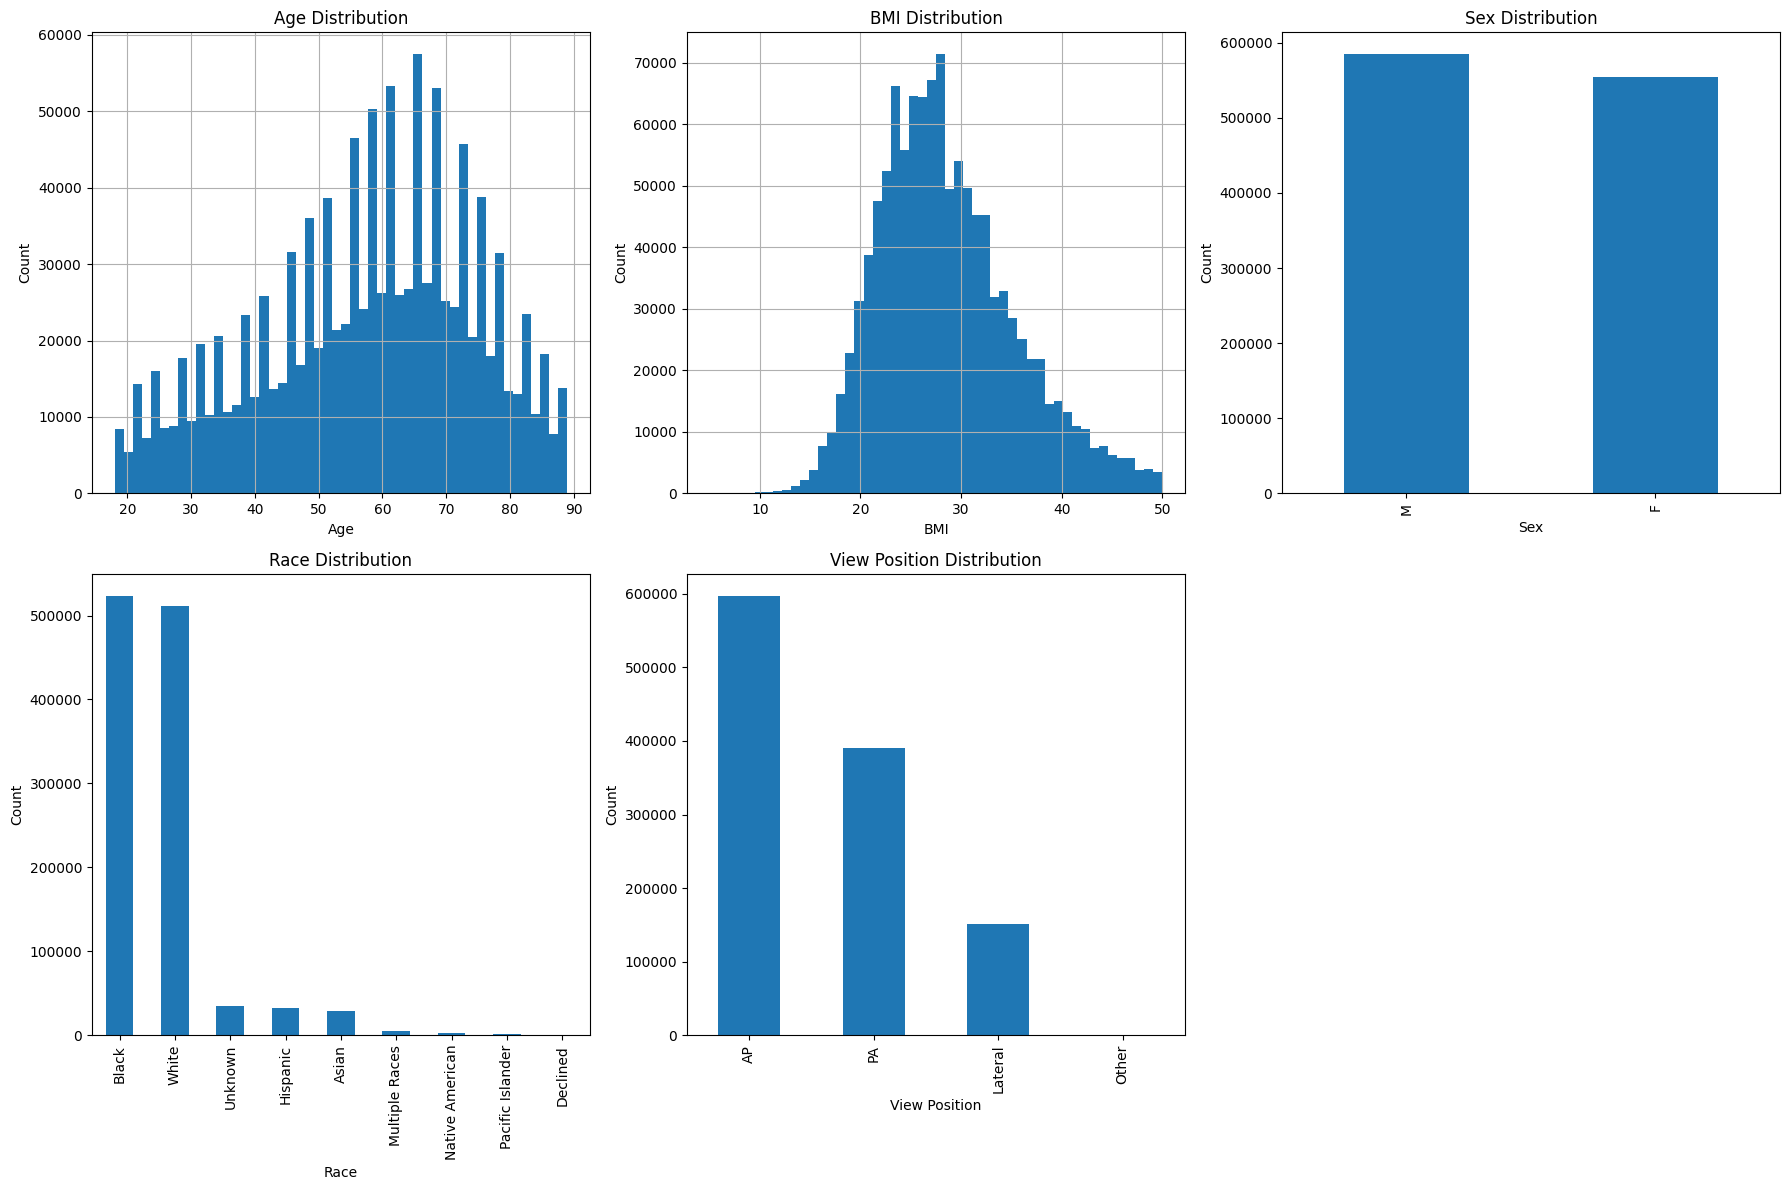

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))

# Age distribution
plt.subplot(2, 3, 1)
df["Age"].hist(bins=50)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")

# BMI distribution
plt.subplot(2, 3, 2)
df["BMI"].hist(bins=50)
plt.title("BMI Distribution")
plt.xlabel("BMI")
plt.ylabel("Count")

# Sex distribution
plt.subplot(2, 3, 3)
df["Sex"].value_counts().plot(kind="bar")
plt.title("Sex Distribution")
plt.xlabel("Sex")
plt.ylabel("Count")

# Race distribution
plt.subplot(2, 3, 4)
df["Race"].value_counts().plot(kind="bar")
plt.title("Race Distribution")
plt.xlabel("Race")
plt.ylabel("Count")

# ViewPosition distribution
plt.subplot(2, 3, 5)
df["ViewPosition"].value_counts().plot(kind="bar")
plt.title("View Position Distribution")
plt.xlabel("View Position")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

#### Co-occurrence Heatmap of Findings (Across All Images)

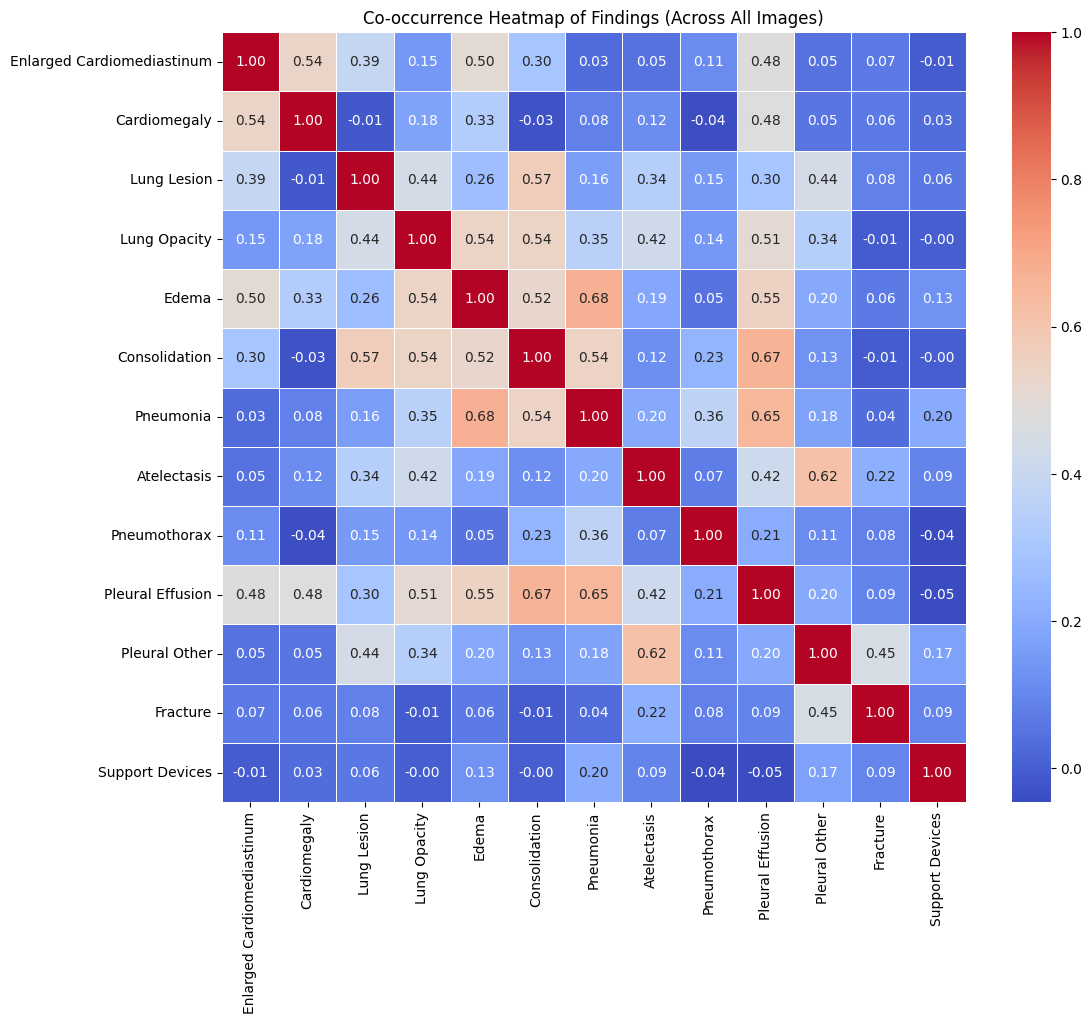

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

finding_cols = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 
                'Lung Lesion', 'Lung Opacity', 'Edema', 'Consolidation', 
                'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 
                'Pleural Other', 'Fracture', 'Support Devices']

# Replace -1 with NaN (so both -1 and NaN mean "unknown/uncertain")
label_corr_df = df_master[finding_cols].replace(-1, np.nan)

# Plot correlation heatmap (NaNs are automatically ignored in pairwise correlations)
plt.figure(figsize=(12, 10))
sns.heatmap(label_corr_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title("Co-occurrence Heatmap of Findings (Across All Images)")
plt.show()


In [33]:
# Drop the ID column to only analyze findings
finding_cols = df_findings_cxr.columns.drop('AccessionNumber_anon')

# Count the labels for each finding
label_counts = {}
for col in finding_cols:
    counts = df_findings_cxr[col].value_counts(dropna=False)  # include NaNs
    counts = counts.rename({1.0: 'Positive', 0.0: 'Negative', -1.0: 'Uncertain'})
    
    # Handle NaN counts
    nan_count = counts.get(np.nan, 0)  # get number of NaNs
    counts = counts.drop(np.nan, errors='ignore')  # remove NaN key if exists
    counts['Not Mentioned'] = nan_count  # add as readable label

    label_counts[col] = counts

# Convert to a clean DataFrame
df_label_counts = pd.DataFrame(label_counts).fillna(0).astype(int).T

# Display the table
print(df_label_counts)


                            Negative  Not Mentioned  Positive  Uncertain
No Finding                         0         726298    597010          0
Enlarged Cardiomediastinum      8116        1267559     18959      28674
Cardiomegaly                   27489        1156764    121985      17070
Lung Lesion                     5028        1281705     31559       5016
Lung Opacity                   43180        1034346    222309      23473
Edema                          44795        1102934    103523      72056
Consolidation                  64057        1211222     28679      19350
Pneumonia                      28452        1146892     37592     110372
Atelectasis                     6505        1006354    222085      88364
Pneumothorax                  182644        1090083     44117       6464
Pleural Effusion               77671        1007529    209481      28627
Pleural Other                    950        1304559     11631       6168
Fracture                         854        1316354

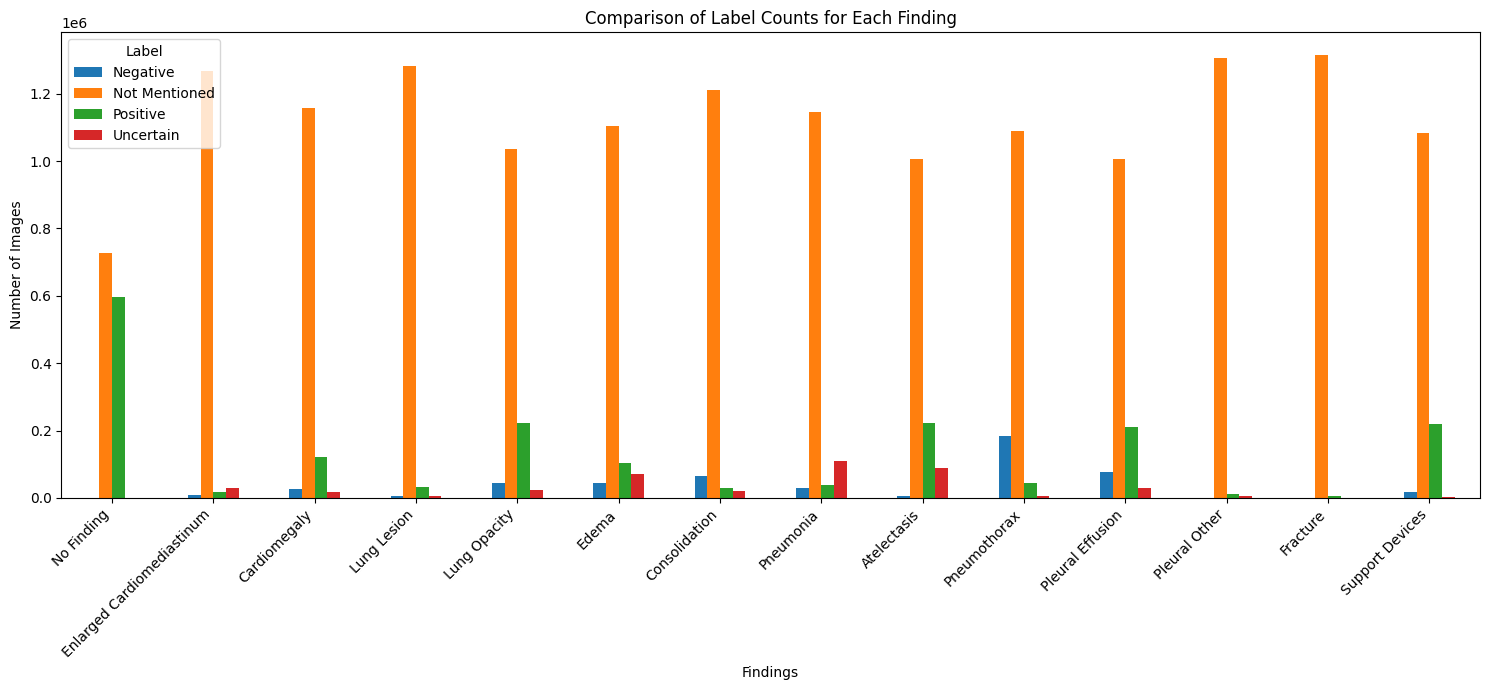

In [34]:
# Plotting the grouped bar chart
df_label_counts.plot(kind='bar', figsize=(15, 7))

plt.title('Comparison of Label Counts for Each Finding')
plt.xlabel('Findings')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

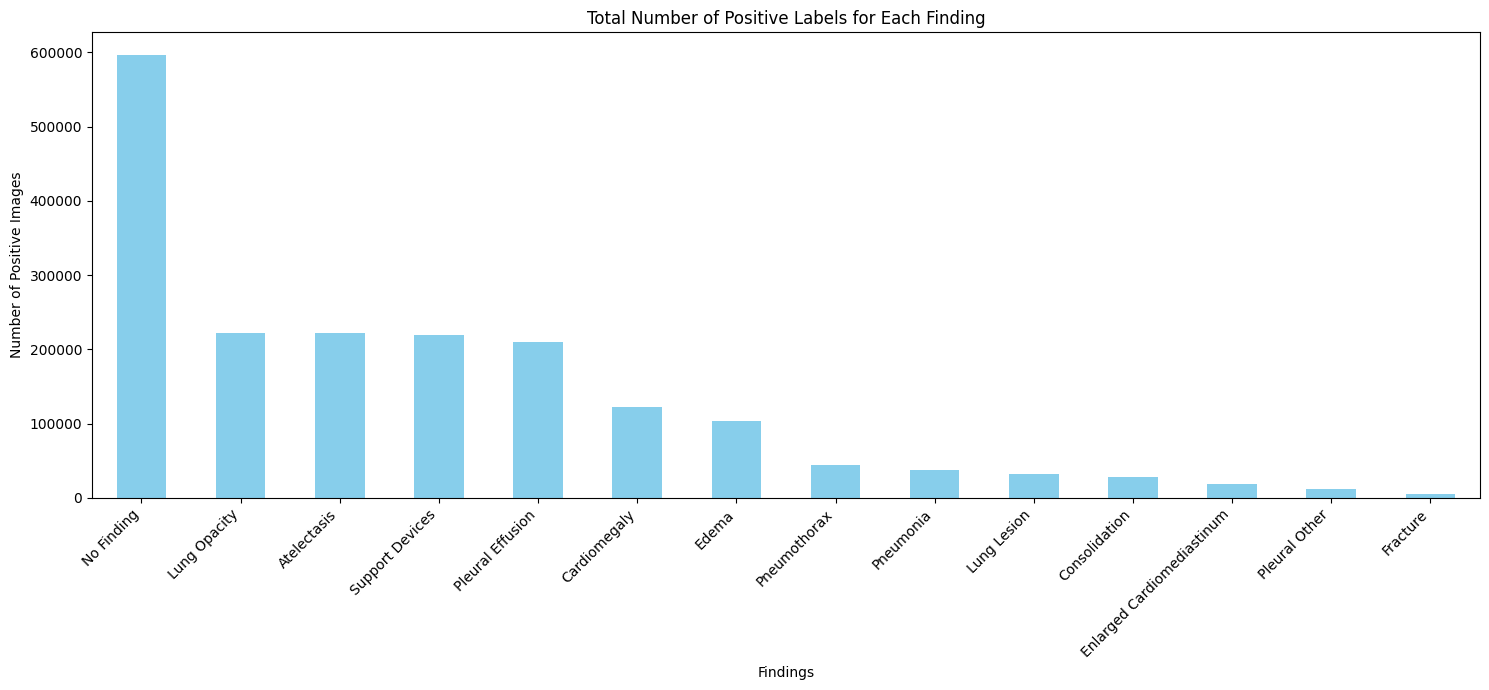

In [35]:
# Select only the 'Positive' column for plotting
positive_counts = df_label_counts['Positive'].sort_values(ascending=False)

# Create the bar chart
plt.figure(figsize=(15, 7))
positive_counts.plot(kind='bar', color='skyblue')

plt.title('Total Number of Positive Labels for Each Finding')
plt.xlabel('Findings')
plt.ylabel('Number of Positive Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## MIMIC EXR

In [37]:
MIMIC_DIR = "/mnt/fsx/embeddings/MIMIC/Tables/"
META_FP   = os.path.join(MIMIC_DIR, "mimic-cxr-2.0.0-metadata.csv")
CHEX_FP   = os.path.join(MIMIC_DIR, "mimic-cxr-2.0.0-chexpert.csv")
SPLIT_FP  = os.path.join(MIMIC_DIR, "mimic-cxr-2.0.0-split.csv")

# 1) Image-level metadata (one row = one DICOM image)
df_meta  = pd.read_csv(META_FP)

# 2) Study-level CheXpert labels (one row = one study)
df_chex  = pd.read_csv(CHEX_FP)

# 3) Patient-level split recommendation (train/validate/test by subject)
df_split = pd.read_csv(SPLIT_FP)

print("Loaded shapes (rows, cols):")
print("meta   :", df_meta.shape)
print("chex   :", df_chex.shape)
print("split  :", df_split.shape)

#display(df_meta)
#display(df_chex)
#display(df_split)

Loaded shapes (rows, cols):
meta   : (377110, 12)
chex   : (227827, 16)
split  : (377110, 4)


In [73]:
# Peek at loaded tables

import pandas as pd

print("META head:")
display(df_meta.head(3))
print("\nMETA columns:", list(df_meta.columns))

print("\nCHEXPERT head:")
display(df_chex.head(3))
print("\nCHEXPERT columns:", list(df_chex.columns))

print("\nSPLIT head:")
display(df_split.head(3))

print("\nMETA dtypes:")
print(df_meta.dtypes)


META head:


dicom_id  subject_id  study_id  \
0  02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267   
1  174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962    10000032  50414267   
2  2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab    10000032  53189527   

  PerformedProcedureStepDescription ViewPosition  Rows  Columns  StudyDate  \
0                CHEST (PA AND LAT)           PA  3056     2544   21800506   
1                CHEST (PA AND LAT)      LATERAL  3056     2544   21800506   
2                CHEST (PA AND LAT)           PA  3056     2544   21800626   

    StudyTime ProcedureCodeSequence_CodeMeaning ViewCodeSequence_CodeMeaning  \
0  213014.531                CHEST (PA AND LAT)             postero-anterior   
1  213014.531                CHEST (PA AND LAT)                      lateral   
2  165500.312                CHEST (PA AND LAT)             postero-anterior   

  PatientOrientationCodeSequence_CodeMeaning  
0                                      Erect  
1                                      Erect  
2                                      Erect


META columns: ['dicom_id', 'subject_id', 'study_id', 'PerformedProcedureStepDescription', 'ViewPosition', 'Rows', 'Columns', 'StudyDate', 'StudyTime', 'ProcedureCodeSequence_CodeMeaning', 'ViewCodeSequence_CodeMeaning', 'PatientOrientationCodeSequence_CodeMeaning']

CHEXPERT head:


subject_id  study_id  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0    10000032  50414267          NaN           NaN            NaN    NaN   
1    10000032  53189527          NaN           NaN            NaN    NaN   
2    10000032  53911762          NaN           NaN            NaN    NaN   

   Enlarged Cardiomediastinum  Fracture  Lung Lesion  Lung Opacity  \
0                         NaN       NaN          NaN           NaN   
1                         NaN       NaN          NaN           NaN   
2                         NaN       NaN          NaN           NaN   

   No Finding  Pleural Effusion  Pleural Other  Pneumonia  Pneumothorax  \
0         1.0               NaN            NaN        NaN           NaN   
1         1.0               NaN            NaN        NaN           NaN   
2         1.0               NaN            NaN        NaN           NaN   

   Support Devices  
0              NaN  
1              NaN  
2              NaN


CHEXPERT columns: ['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']

SPLIT head:


subject_id  split
0    10000032  train
1    10000032  train
2    10000032  train


META dtypes:
dicom_id                                       object
subject_id                                      int64
study_id                                        int64
PerformedProcedureStepDescription              object
ViewPosition                                   object
Rows                                            int64
Columns                                         int64
StudyDate                                       int64
StudyTime                                     float64
ProcedureCodeSequence_CodeMeaning              object
ViewCodeSequence_CodeMeaning                   object
PatientOrientationCodeSequence_CodeMeaning     object
dtype: object


In [77]:
# Standardize view names and attach split cleanly

def std_view(v: str) -> str:
    v = str(v).upper()
    if v in ("AP","PA"): return v
    if "LAT" in v:       return "Lateral"
    return "Other"

df_img = df_meta.copy()
df_img["ViewPosition_std"] = df_img["ViewPosition"].apply(std_view)

df_split = df_split[["subject_id","split"]].copy()
df_split["subject_id"] = df_split["subject_id"].astype(df_img["subject_id"].dtype)
df_img = df_img.merge(df_split, on="subject_id", how="left")

print("df_img shape:", df_img.shape)
print("Interpretation: image-level frame ready with standardized view and split.")

df_img shape: (6432512, 14)
Interpretation: image-level frame ready with standardized view and split.


In [78]:
# Basic scale and sanity checks

n_subj = df_img["subject_id"].nunique()
n_stud = df_img.drop_duplicates(["subject_id","study_id"]).shape[0]
n_img  = df_img["dicom_id"].nunique()
dups   = df_img.duplicated(["dicom_id"]).sum()

print(f"Subjects: {n_subj:,} | Studies: {n_stud:,} | Images: {n_img:,}")
print("Duplicate DICOM rows:", int(dups))

key_cols = ["subject_id","study_id","dicom_id","ViewPosition","ViewPosition_std","Rows","Columns","StudyDate","split"]
miss_tbl = (df_img[key_cols].isna().mean()*100).round(2).sort_values(ascending=False).to_frame("missing_%")
display(miss_tbl.head(10))

print("Interpretation: confirms dataset size and highlights any missing fields.")


Subjects: 65,379 | Studies: 227,835 | Images: 377,110
Duplicate DICOM rows: 6055402


missing_%
ViewPosition           3.33
subject_id             0.00
study_id               0.00
dicom_id               0.00
ViewPosition_std       0.00
Rows                   0.00
Columns                0.00
StudyDate              0.00
split                  0.00

Interpretation: confirms dataset size and highlights any missing fields.


count  percent_%
ViewPosition_std                   
AP                147173       39.0
PA                 96161       25.5
Lateral            82855       22.0
Other              50921       13.5

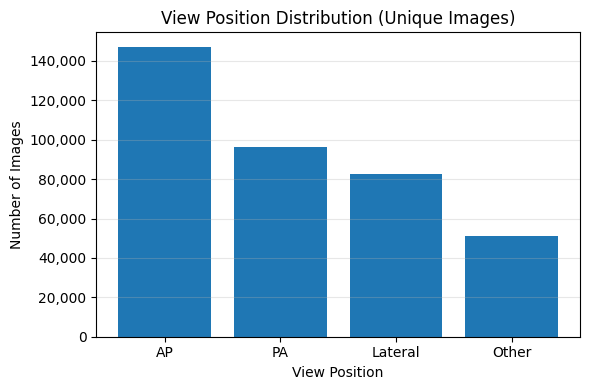

Interpretation: tells us how much AP/PA vs Lateral/Other we have.


In [79]:
# Viewing mix across AP/PA/Lateral/Other on unique images

img_unique = df_img.drop_duplicates("dicom_id")
view_counts = (img_unique["ViewPosition_std"]
               .value_counts()
               .reindex(["AP","PA","Lateral","Other"])
               .fillna(0).astype(int))
view_pct = (100*view_counts/view_counts.sum()).round(1)
display(pd.DataFrame({"count": view_counts, "percent_%": view_pct}))

plt.figure(figsize=(6,4))
plt.bar(view_counts.index, view_counts.values)
plt.title("View Position Distribution (Unique Images)")
plt.xlabel("View Position"); plt.ylabel("Number of Images")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
plt.grid(True, axis="y", alpha=0.3); plt.tight_layout(); plt.show()

print("Interpretation: tells us how much AP/PA vs Lateral/Other we have.")


label    neg    unc    pos  missing  labeled
0             Pleural Effusion  27158   5814  54300   140555    87272
1                   No Finding      0      0  75455   152372    75455
2              Support Devices   3486    237  66558   157546    70281
3                 Cardiomegaly  15911   6043  44845   161028    66799
4                        Edema  25641  13174  27018   161994    65833
5                    Pneumonia  24338  18291  16556   168642    59185
6                 Lung Opacity   3069   3831  51525   169402    58425
7                  Atelectasis   1531  10327  45808   170161    57666
8                 Pneumothorax  42356   1134  10358   173979    53848
9                Consolidation   7967   4331  10778   204751    23076
10  Enlarged Cardiomediastinum   5283   9375   7179   205990    21837
11                 Lung Lesion    862   1141   6284   219540     8287
12                    Fracture    886    555   4390   221996     5831
13               Pleural Other    126    765   2011   224925     2902

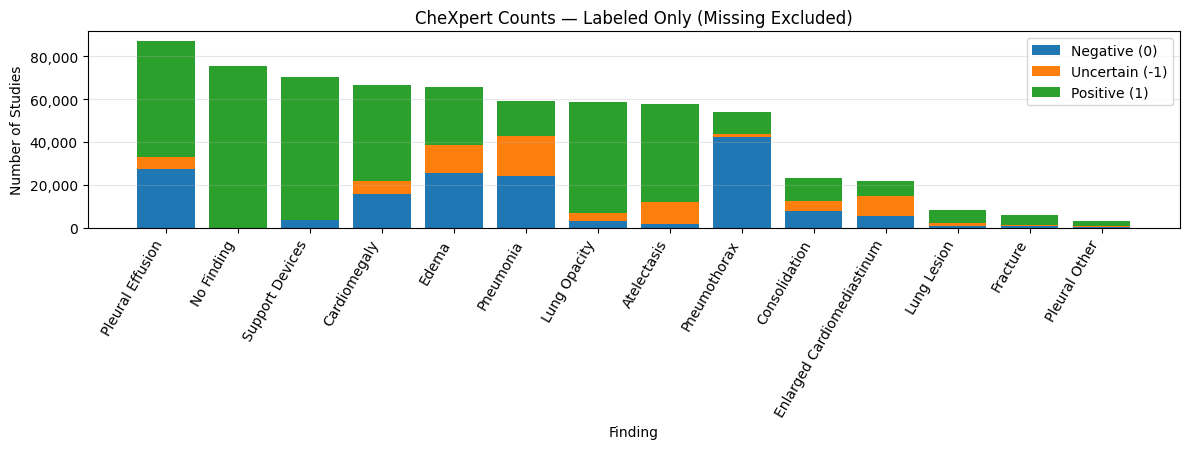

Interpretation: shows class mix per finding among labeled studies.


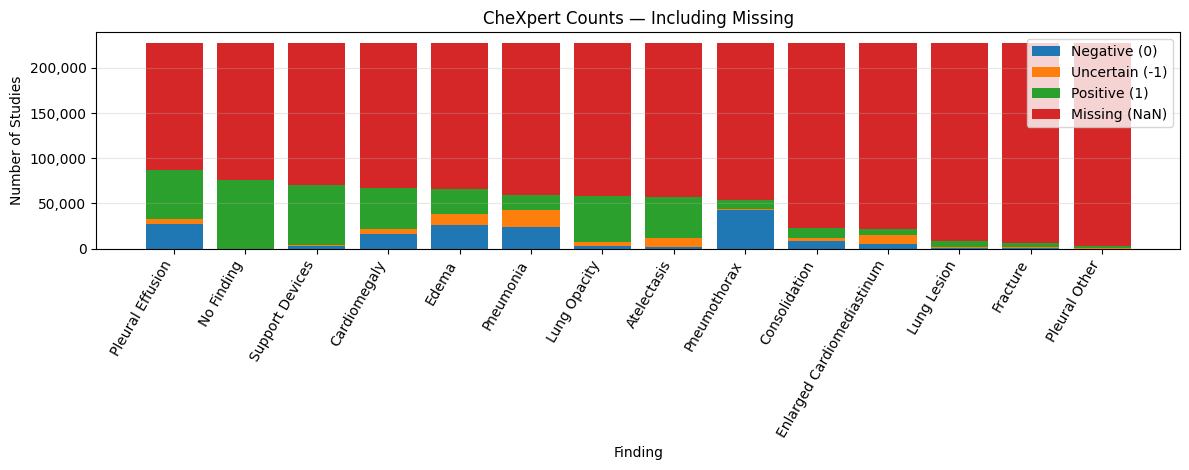

In [80]:
# Per-label counts and stacked bar (neg/unc/pos)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

label_cols = [c for c in df_chex.columns if c not in {"subject_id","study_id"}]

rows = []
for col in label_cols:
    s = df_chex[col]
    rows.append({"label": col,
                 "neg": int((s==0).sum()),
                 "unc": int((s==-1).sum()),
                 "pos": int((s==1).sum()),
                 "missing": int(s.isna().sum())})
chex_summary = (pd.DataFrame(rows)
                .assign(labeled=lambda d: d["neg"]+d["unc"]+d["pos"])
                .sort_values("labeled", ascending=False)
                .reset_index(drop=True))
display(chex_summary)

order = chex_summary["label"].tolist()
neg = [int((df_chex[c]==0).sum())  for c in order]
unc = [int((df_chex[c]==-1).sum()) for c in order]
pos = [int((df_chex[c]==1).sum())  for c in order]

x = np.arange(len(order))
plt.figure(figsize=(12,4.6))
plt.bar(x, neg, label="Negative (0)")
plt.bar(x, unc, bottom=neg, label="Uncertain (-1)")
plt.bar(x, pos, bottom=np.array(neg)+np.array(unc), label="Positive (1)")
plt.xticks(x, order, rotation=60, ha="right")
plt.title("CheXpert Counts — Labeled Only (Missing Excluded)")
plt.xlabel("Finding"); plt.ylabel("Number of Studies")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
plt.grid(True, axis="y", alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

print("Interpretation: shows class mix per finding among labeled studies.")

# Cell 8 — OPTIONAL: Stacked bar including Missing (NaN)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

miss = [int(df_chex[c].isna().sum()) for c in order]

x = np.arange(len(order))
plt.figure(figsize=(12,4.8))
plt.bar(x, neg, label="Negative (0)")
plt.bar(x, unc, bottom=neg, label="Uncertain (-1)")
plt.bar(x, pos, bottom=np.array(neg)+np.array(unc), label="Positive (1)")
plt.bar(x, miss, bottom=np.array(neg)+np.array(unc)+np.array(pos), label="Missing (NaN)")
plt.xticks(x, order, rotation=60, ha="right")
plt.title("CheXpert Counts — Including Missing")
plt.xlabel("Finding")
plt.ylabel("Number of Studies")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



value
count  227835.00
mean        1.66
std         0.68
min         1.00
25%         1.00
50%         2.00
75%         2.00
max        11.00

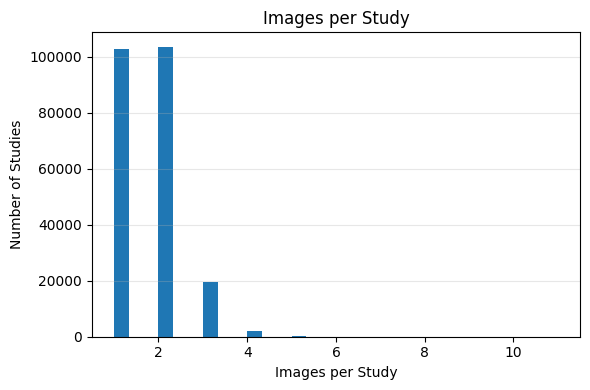

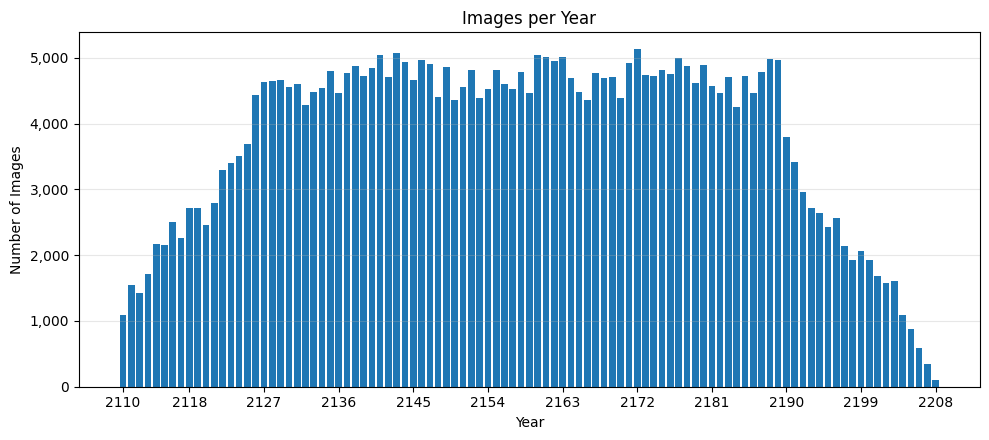

Interpretation: tells us typical images per study and temporal coverage.


In [81]:
# Images per study (hist) and per year (bar)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

ips = df_meta.groupby(["subject_id","study_id"])["dicom_id"].nunique()
display(ips.describe().round(2).to_frame("value"))

plt.figure(figsize=(6,4))
ips.plot(kind="hist", bins=30)
plt.title("Images per Study"); plt.xlabel("Images per Study"); plt.ylabel("Number of Studies")
plt.grid(True, axis="y", alpha=0.3); plt.tight_layout(); plt.show()

dt = pd.to_datetime(df_meta["StudyDate"].astype(str), errors="coerce", format="%Y%m%d")
year_counts = dt.dt.year.value_counts().sort_index()
years, counts = year_counts.index.to_numpy(), year_counts.values

plt.figure(figsize=(10,4.5))
plt.bar(years, counts)
plt.title("Images per Year"); plt.xlabel("Year"); plt.ylabel("Number of Images")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
plt.grid(True, axis="y", alpha=0.3)
if len(years)>0:
    tick_idx = np.linspace(0, len(years)-1, num=min(12, len(years)), dtype=int)
    plt.xticks(years[tick_idx], years[tick_idx].astype(str))
plt.tight_layout(); plt.show()

print("Interpretation: tells us typical images per study and temporal coverage.")


In [82]:
# Top findings by labeled volume + positive rate (among labeled)
label_cols = [c for c in df_chex.columns if c not in {"subject_id","study_id"}]
rows = []
for lab in label_cols:
    s = df_chex[lab]
    neg, unc, pos = (s==0).sum(), (s==-1).sum(), (s==1).sum()
    labeled = neg+unc+pos
    pos_rate = 100*pos/max(1,labeled)
    rows.append({"label":lab,"labeled":int(labeled),"pos":int(pos),"pos_rate_%":round(pos_rate,2)})
summary = (pd.DataFrame(rows)
           .sort_values(["labeled","pos_rate_%"], ascending=[False,False])
           .reset_index(drop=True))
summary.head(10)


label  labeled    pos  pos_rate_%
0  Pleural Effusion    87272  54300       62.22
1        No Finding    75455  75455      100.00
2   Support Devices    70281  66558       94.70
3      Cardiomegaly    66799  44845       67.13
4             Edema    65833  27018       41.04
5         Pneumonia    59185  16556       27.97
6      Lung Opacity    58425  51525       88.19
7       Atelectasis    57666  45808       79.44
8      Pneumothorax    53848  10358       19.24
9     Consolidation    23076  10778       46.71

In [83]:
# Images per study summary (paste key stats)
ips = df_meta.groupby(["subject_id","study_id"])["dicom_id"].nunique()
ips.describe().round(2)


count    227835.00
mean          1.66
std           0.68
min           1.00
25%           1.00
50%           2.00
75%           2.00
max          11.00
Name: dicom_id, dtype: float64

In [84]:
# Confirm no leakage (subjects appearing in >1 split)
leak = df_img.groupby("subject_id")["split"].nunique(dropna=True)
print("Subjects in >1 split:", int((leak>1).sum()))

Subjects in >1 split: 0


label  labeled    pos  pos_rate_%
0                   No Finding    75455  75455      100.00
1              Support Devices    70281  66558       94.70
2                 Lung Opacity    58425  51525       88.19
3                  Atelectasis    57666  45808       79.44
4                  Lung Lesion     8287   6284       75.83
5                     Fracture     5831   4390       75.29
6                Pleural Other     2902   2011       69.30
7                 Cardiomegaly    66799  44845       67.13
8             Pleural Effusion    87272  54300       62.22
9                Consolidation    23076  10778       46.71
10                       Edema    65833  27018       41.04
11  Enlarged Cardiomediastinum    21837   7179       32.88
12                   Pneumonia    59185  16556       27.97
13                Pneumothorax    53848  10358       19.24

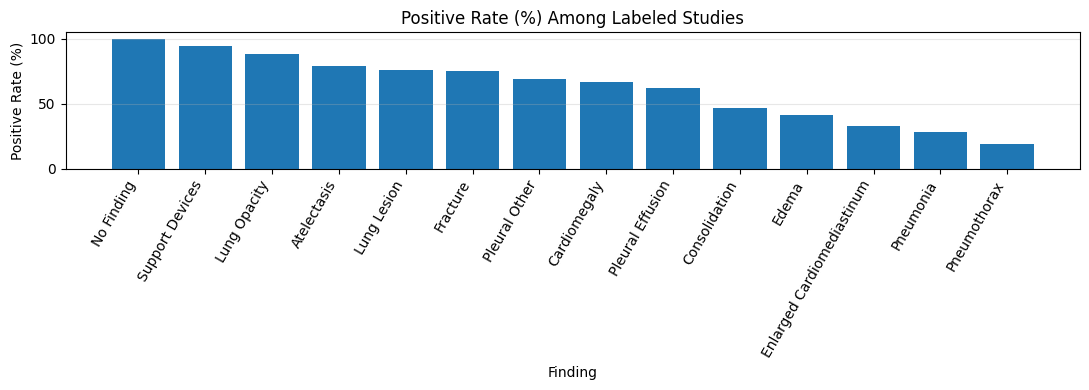

Interpretation: ranks findings by prevalence among labeled studies.


In [85]:
# Positive rate (%) among labeled for each finding (quick ranking)
# 1 = positive, 0 = negative, -1 = uncertain, NaN = missing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assumes df_chex and label_cols already defined
rows = []
for col in label_cols:
    s = df_chex[col]
    labeled = s.isin([0, -1, 1]).sum()
    pos = (s == 1).sum()
    rows.append({"label": col, "labeled": int(labeled), "pos": int(pos),
                 "pos_rate_%": round(100*pos/max(1, labeled), 2)})

posrate = pd.DataFrame(rows).sort_values("pos_rate_%", ascending=False).reset_index(drop=True)
display(posrate)

plt.figure(figsize=(11,4))
plt.bar(posrate["label"], posrate["pos_rate_%"])
plt.xticks(rotation=60, ha="right")
plt.title("Positive Rate (%) Among Labeled Studies")
plt.xlabel("Finding"); plt.ylabel("Positive Rate (%)")
plt.grid(True, axis="y", alpha=0.3); plt.tight_layout(); plt.show()

print("Interpretation: ranks findings by prevalence among labeled studies.")


# EDA of EMBEDDINGS

In [50]:
meta.columns

Index(['dicom_id', 'subject_id', 'study_id',
       'PerformedProcedureStepDescription', 'ViewPosition', 'Rows', 'Columns',
       'StudyDate', 'StudyTime', 'ProcedureCodeSequence_CodeMeaning',
       'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning', 'MedImageInsights',
       'CheXagent', 'RAD-DINO', 'MedGemma', 'BiomedCLIP'],
      dtype='object')

### Availability checks

In [51]:
# Filter metadata to only include images with embeddings for the selected feature model
# The metadata contains boolean columns indicating embedding availability for each model
print(f"Selected feature model: {FM}")
print(f"Total images in metadata: {len(meta)}")

# Create subset containing only images with embeddings for the selected FM
# meta[FM] creates a boolean mask - True where embeddings exist for this model
meta_sub = meta[meta[FM]].reset_index(drop=True)

print(f"Images with {FM} embeddings: {len(meta_sub)}")

meta_sub

Selected feature model: MedGemma
Total images in metadata: 377110
Images with MedGemma embeddings: 377110


dicom_id  subject_id  study_id  \
0       02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267   
1       174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962    10000032  50414267   
2       2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab    10000032  53189527   
3       e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c    10000032  53189527   
4       68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714    10000032  53911762   
...                                              ...         ...       ...   
377105  428e2c18-5721d8f3-35a05001-36f3d080-9053b83c    19999733  57132437   
377106  58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9    19999733  57132437   
377107  58766883-376a15ce-3b323a28-6af950a0-16b793bd    19999987  55368167   
377108  7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08    19999987  58621812   
377109  1a1fe7e3-cbac5d93-b339aeda-86bb86b5-4f31e82e    19999987  58971208   

       PerformedProcedureStepDescription ViewPosition  Rows  Columns  \
0                     CHEST (PA AND LAT)           PA  3056     2544   
1                     CHEST (PA AND LAT)      LATERAL  3056     2544   
2                     CHEST (PA AND LAT)           PA  3056     2544   
3                     CHEST (PA AND LAT)      LATERAL  3056     2544   
4                    CHEST (PORTABLE AP)           AP  2705     2539   
...                                  ...          ...   ...      ...   
377105                CHEST (PA AND LAT)           PA  3056     2544   
377106                CHEST (PA AND LAT)      LATERAL  3056     2544   
377107               CHEST (PORTABLE AP)           AP  2544     3056   
377108               CHEST (PORTABLE AP)           AP  3056     2544   
377109               CHEST (PORTABLE AP)           AP  3056     2544   

        StudyDate   StudyTime ProcedureCodeSequence_CodeMeaning  \
0        21800506  213014.531                CHEST (PA AND LAT)   
1        21800506  213014.531                CHEST (PA AND LAT)   
2        21800626  165500.312                CHEST (PA AND LAT)   
3        21800626  165500.312                CHEST (PA AND LAT)   
4        21800723   80556.875               CHEST (PORTABLE AP)   
...           ...         ...                               ...   
377105   21520708  224550.171                CHEST (PA AND LAT)   
377106   21520708  224550.171                CHEST (PA AND LAT)   
377107   21451104   51448.218               CHEST (PORTABLE AP)   
377108   21451102  202809.234               CHEST (PORTABLE AP)   
377109   21451103   50507.625               CHEST (PORTABLE AP)   

       ViewCodeSequence_CodeMeaning  \
0                  postero-anterior   
1                           lateral   
2                  postero-anterior   
3                           lateral   
4                  antero-posterior   
...                             ...   
377105             postero-anterior   
377106                      lateral   
377107             antero-posterior   
377108             antero-posterior   
377109             antero-posterior   

       PatientOrientationCodeSequence_CodeMeaning  MedImageInsights  \
0                                           Erect              True   
1                                           Erect             False   
2                                           Erect              True   
3                                           Erect             False   
4                                             NaN              True   
...                                           ...               ...   
377105                                      Erect             False   
377106                                      Erect             False   
377107                                      Erect             False   
377108                                      Erect             False   
377109                                  Recumbent             False   

        CheXagent  RAD-DINO  MedGemma  BiomedCLIP  
0            True      True      True        True  
1          

### Sample selection

In [52]:
# Select samples you want to analyze
# For large datasets, working with a subset can speed up development and testing

samples = meta_sub.sample(n=100000) # random select for example

# Extract the list of SOP identifiers from our sample metadata
sop_list = list(samples[IMAGE_ID_COLUMN])

In [53]:
sop_list[0:2]

['e978cf17-d030f9d0-e21785ec-2613a39a-4da23029',
 '6899dba9-eb0d0a0d-75f2d5e5-5c77575a-d749fb0b']

#### FULL DATASET VISUALIZATION - ALL 100,000 SAMPLES

🎯 FULL DATASET VISUALIZATION SETUP
📊 Your dataset: 100,000 embeddings
🚀 Ready to visualize ALL samples!
🎯 Full Dataset Visualizer Initialized!
📊 FULL embeddings shape: (100000, 1152)
🧬 Embedding dimensions: 1152
📋 Will visualize ALL 100,000 samples
📋 Metadata available: 377110 records

🎯 CHOOSE YOUR ANALYSIS STRATEGY:

1️⃣ FULL PCA ONLY (Recommended start):
   run_full_pca_only()
   ⏱️ Time: ~3 minutes
   📊 Accuracy: Maximum (all 100K samples)

2️⃣ OPTIMIZED STRATEGY (Best balance):
   run_optimized_full_analysis()  
   ⏱️ Time: ~30-60 minutes
   📊 Full PCA + 50K sample t-SNE

3️⃣ FULL t-SNE ONLY (If you have time):
   run_full_tsne_only()
   ⏱️ Time: 2-6 hours
   📊 Complete t-SNE on all 100K

4️⃣ COMPLETE FULL ANALYSIS (Maximum):
   run_complete_full_analysis()
   ⏱️ Time: 2-6+ hours
   📊 Everything on all 100K samples

🚀 RUNNING FULL PCA ANALYSIS (ALL 100K SAMPLES)

🔍 PERFORMING PCA ON FULL DATASET (100,000 samples)
   🧮 Computing PCA components...
   Computing PCA for 100,000 sample

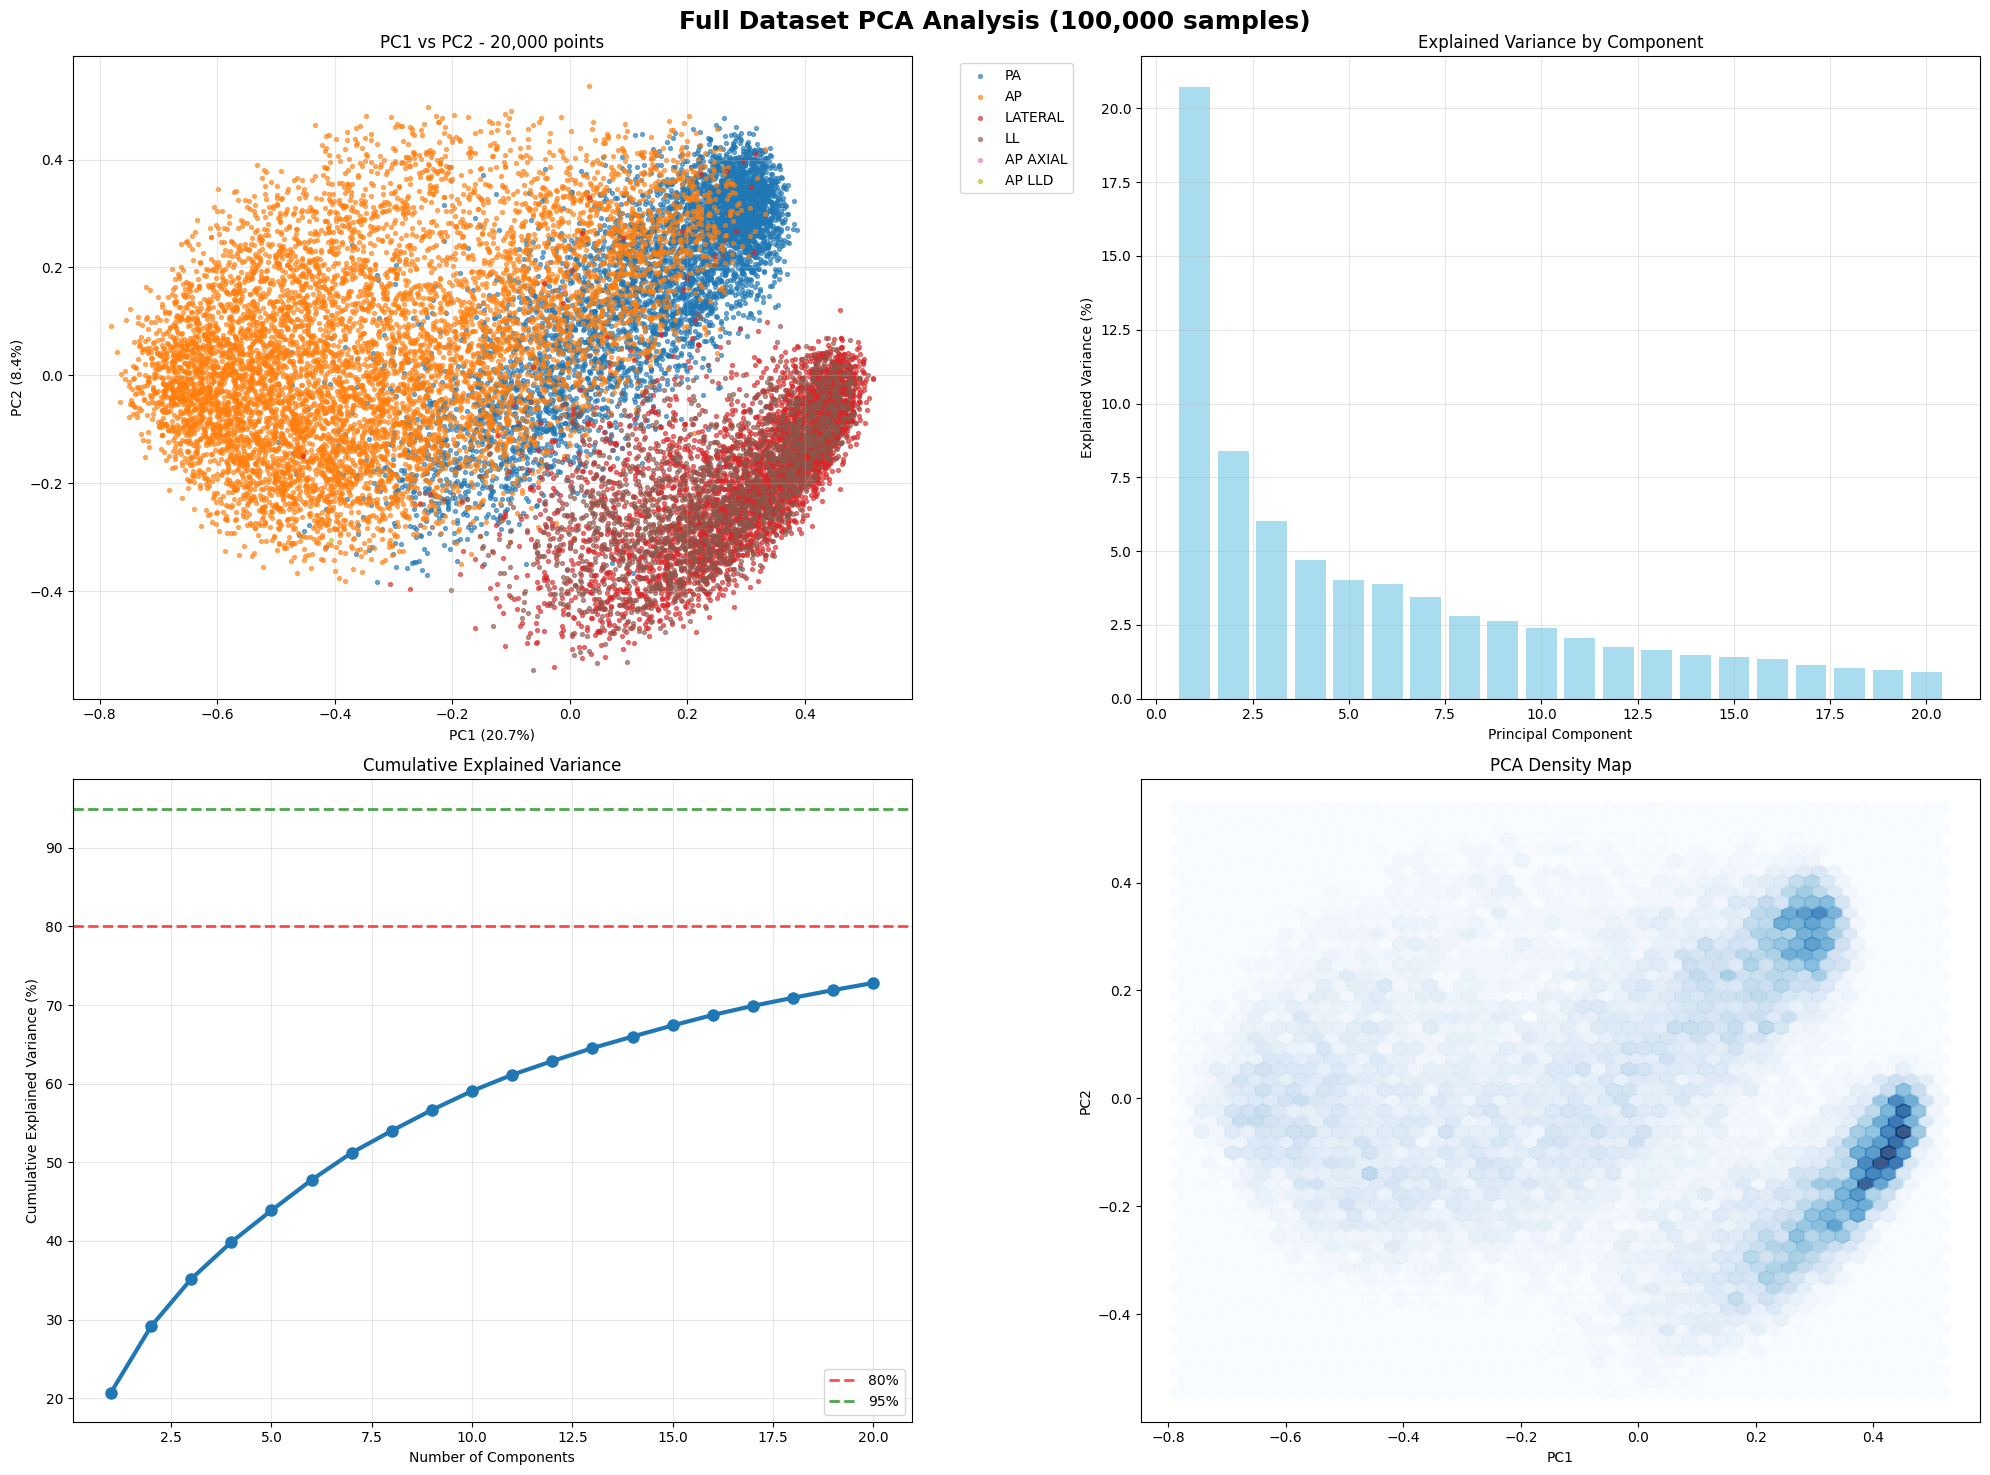

🎯 RUNNING OPTIMIZED FULL ANALYSIS
🚀 RUNNING COMPLETE FULL DATASET ANALYSIS
📊 Dataset: 100,000 samples
🎯 Strategy: Full PCA + Optimized t-SNE


🔍 PERFORMING PCA ON FULL DATASET (100,000 samples)
   🧮 Computing PCA components...
   Computing PCA for 100,000 samples with 1152 dimensions...
   Using SVD for large dataset...
✅ FULL PCA COMPLETE! (1.4 seconds)
   📊 Analyzed: 100,000 samples
   🎯 PC1 explains: 20.7% of variance
   🎯 PC2 explains: 8.4% of variance
   📈 First 2 PCs: 29.1% total variance


🎯 PERFORMING OPTIMIZED t-SNE (50,000 samples)
💡 Strategy: Intelligent sampling + optimized parameters
   🎯 Using stratified sampling by ViewPosition...
   📊 Stratified sampling: 49,996 samples
   📐 Standardizing embeddings...
   🌀 Running optimized t-SNE...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 49996 samples in 0.039s...
[t-SNE] Computed neighbors for 49996 samples in 10.104s...
[t-SNE] Computed conditional probabilities for sample 1000 / 49996
[t-SNE] Computed conditional

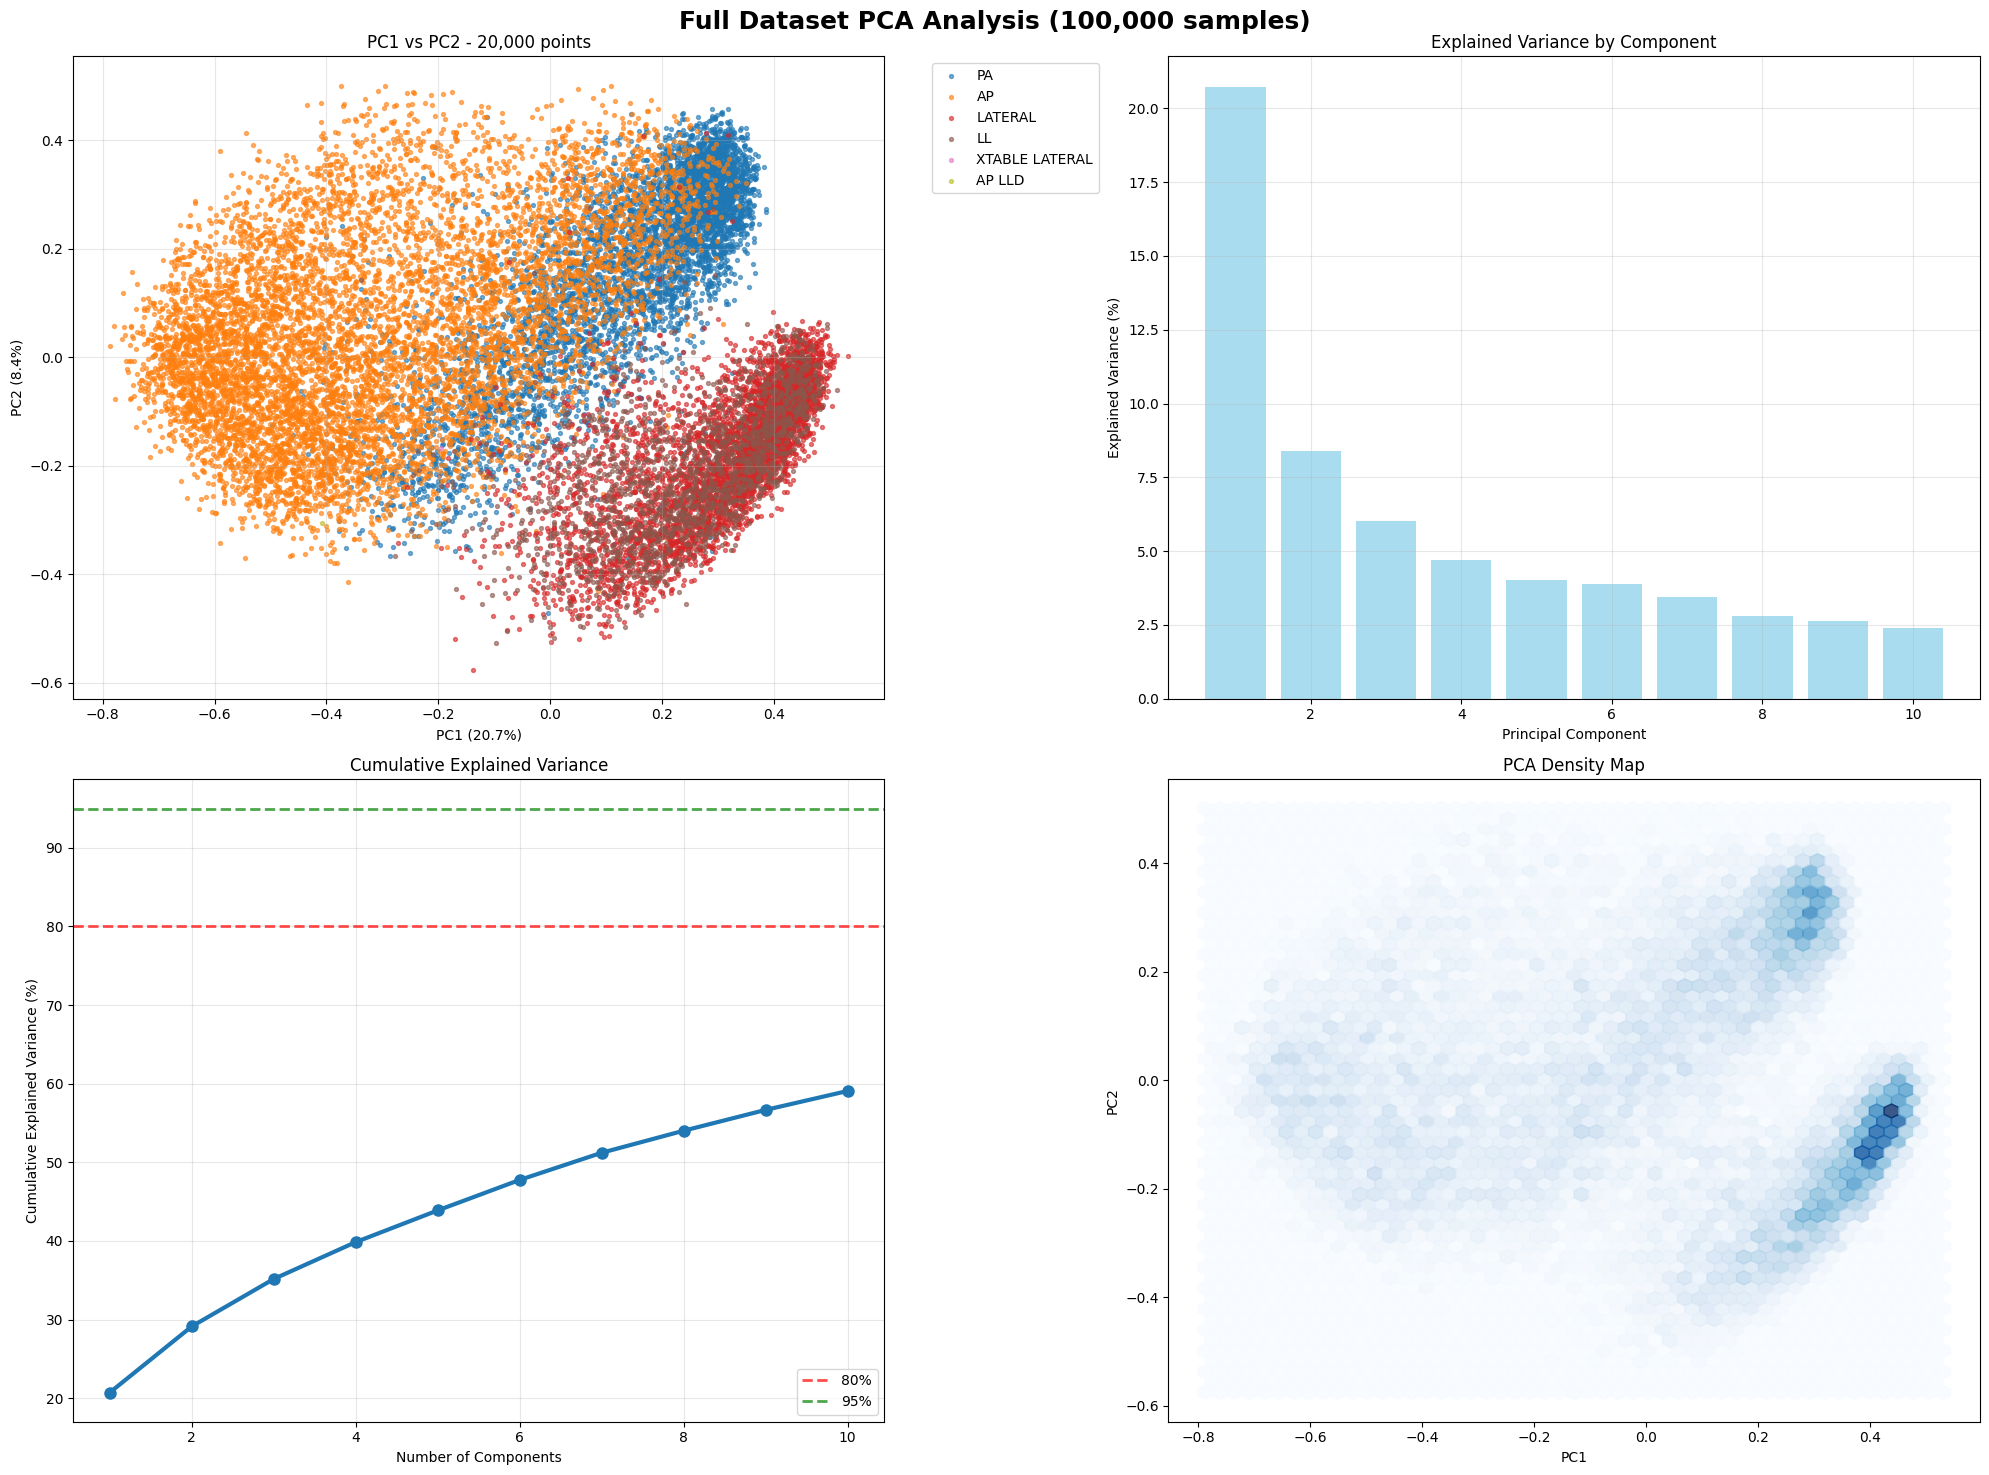


📊 Creating t-SNE visualizations...


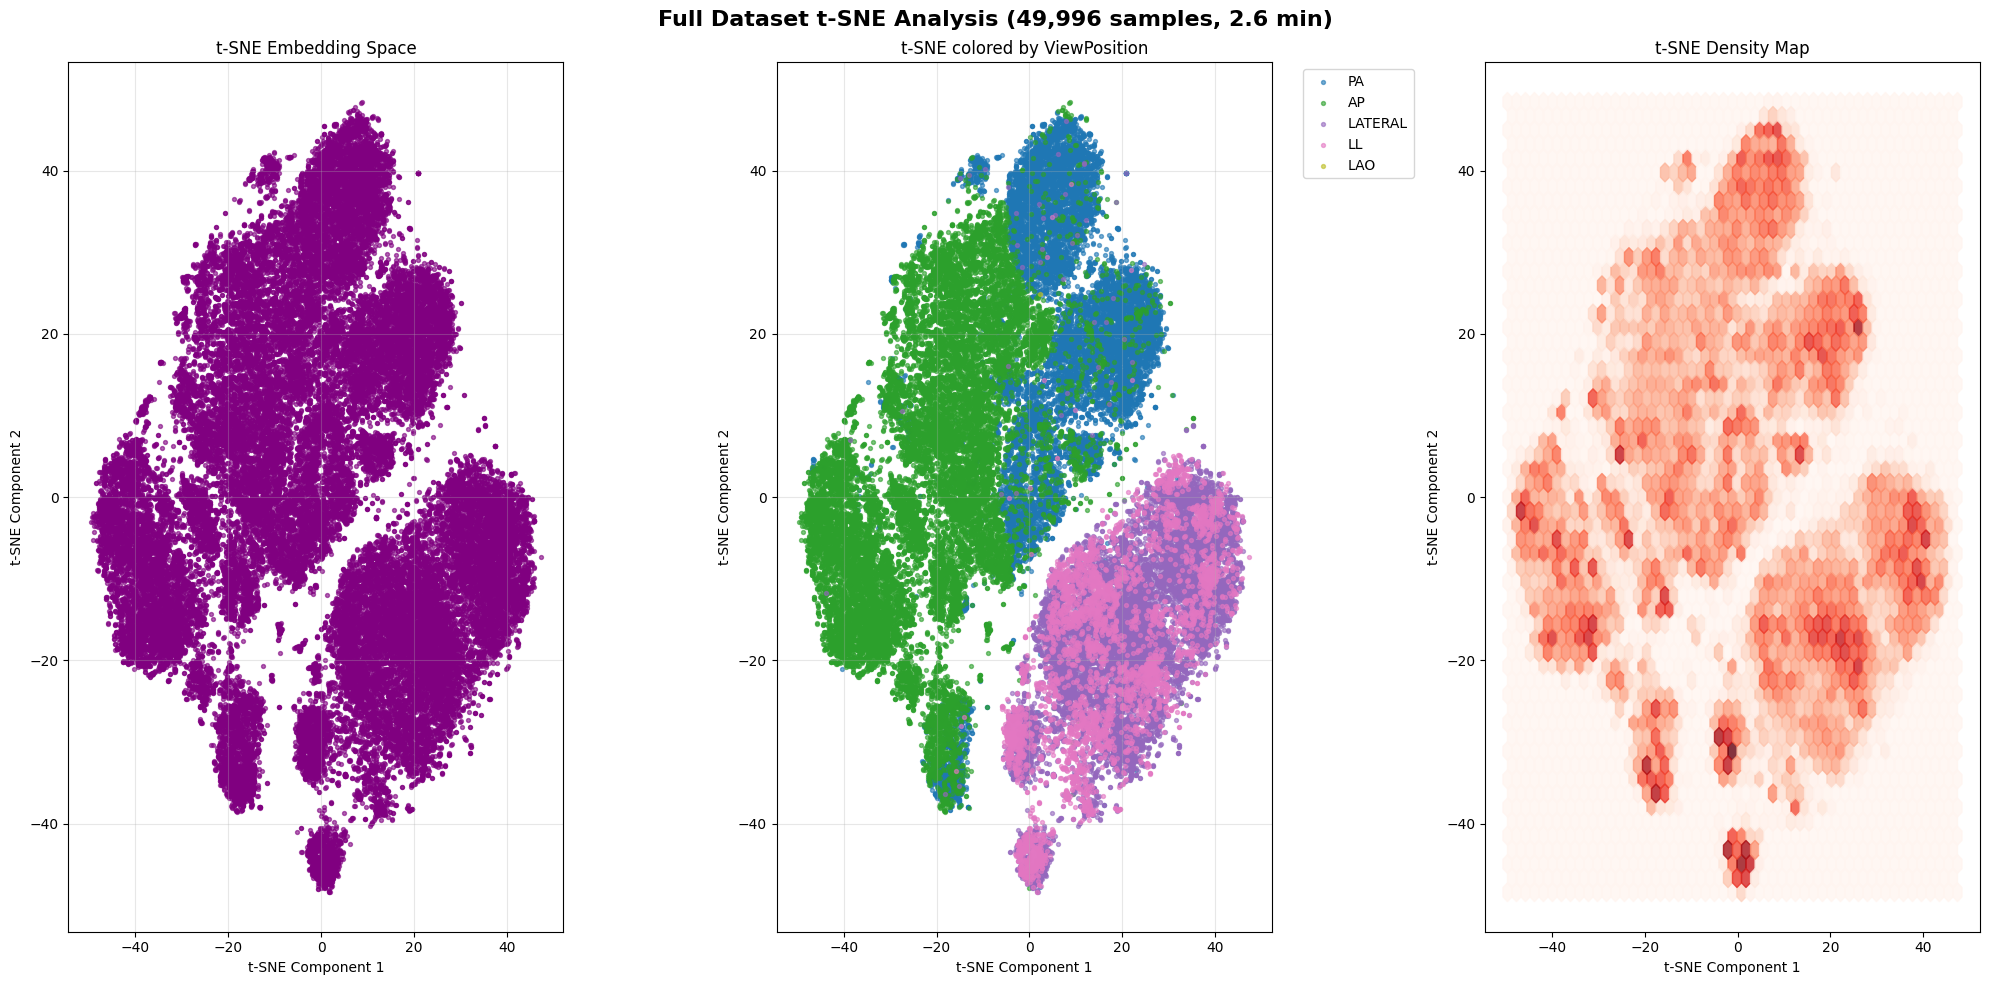


📊 FULL DATASET ANALYSIS SUMMARY
🔍 PCA Results (100,000 samples):
   PC1: 20.7% variance
   PC2: 8.4% variance
   2D total: 29.1% variance
   Components for 80%: 1

🌀 t-SNE Results (49,996 samples):
   Runtime: 2.6 minutes
   Perplexity: 50

✅ FULL DATASET ANALYSIS COMPLETE!
🎯 Maximum accuracy achieved with complete data
💯 RUNNING COMPLETE FULL ANALYSIS (MAXIMUM TIME)
🚀 RUNNING COMPLETE FULL DATASET ANALYSIS
📊 Dataset: 100,000 samples
🎯 Strategy: Full PCA + Full t-SNE


🔍 PERFORMING PCA ON FULL DATASET (100,000 samples)
   🧮 Computing PCA components...
   Computing PCA for 100,000 samples with 1152 dimensions...
   Using SVD for large dataset...
✅ FULL PCA COMPLETE! (1.2 seconds)
   📊 Analyzed: 100,000 samples
   🎯 PC1 explains: 20.7% of variance
   🎯 PC2 explains: 8.4% of variance
   📈 First 2 PCs: 29.1% total variance


🌀 PERFORMING t-SNE ON FULL DATASET (100,000 samples)
⚠️  WARNING: This will take significant time (potentially hours)
💡 Optimizations applied:
   - Increased early_ex


🤔 Continue with t-SNE on 100,000 samples? (y/n):  n


🛑 t-SNE cancelled. Use perform_optimized_tsne() for faster analysis.

📊 Creating PCA visualizations...
🎨 PLOTTING FULL PCA RESULTS (100,000 points)
   📊 Subsampling to 20,000 points for clearer visualization


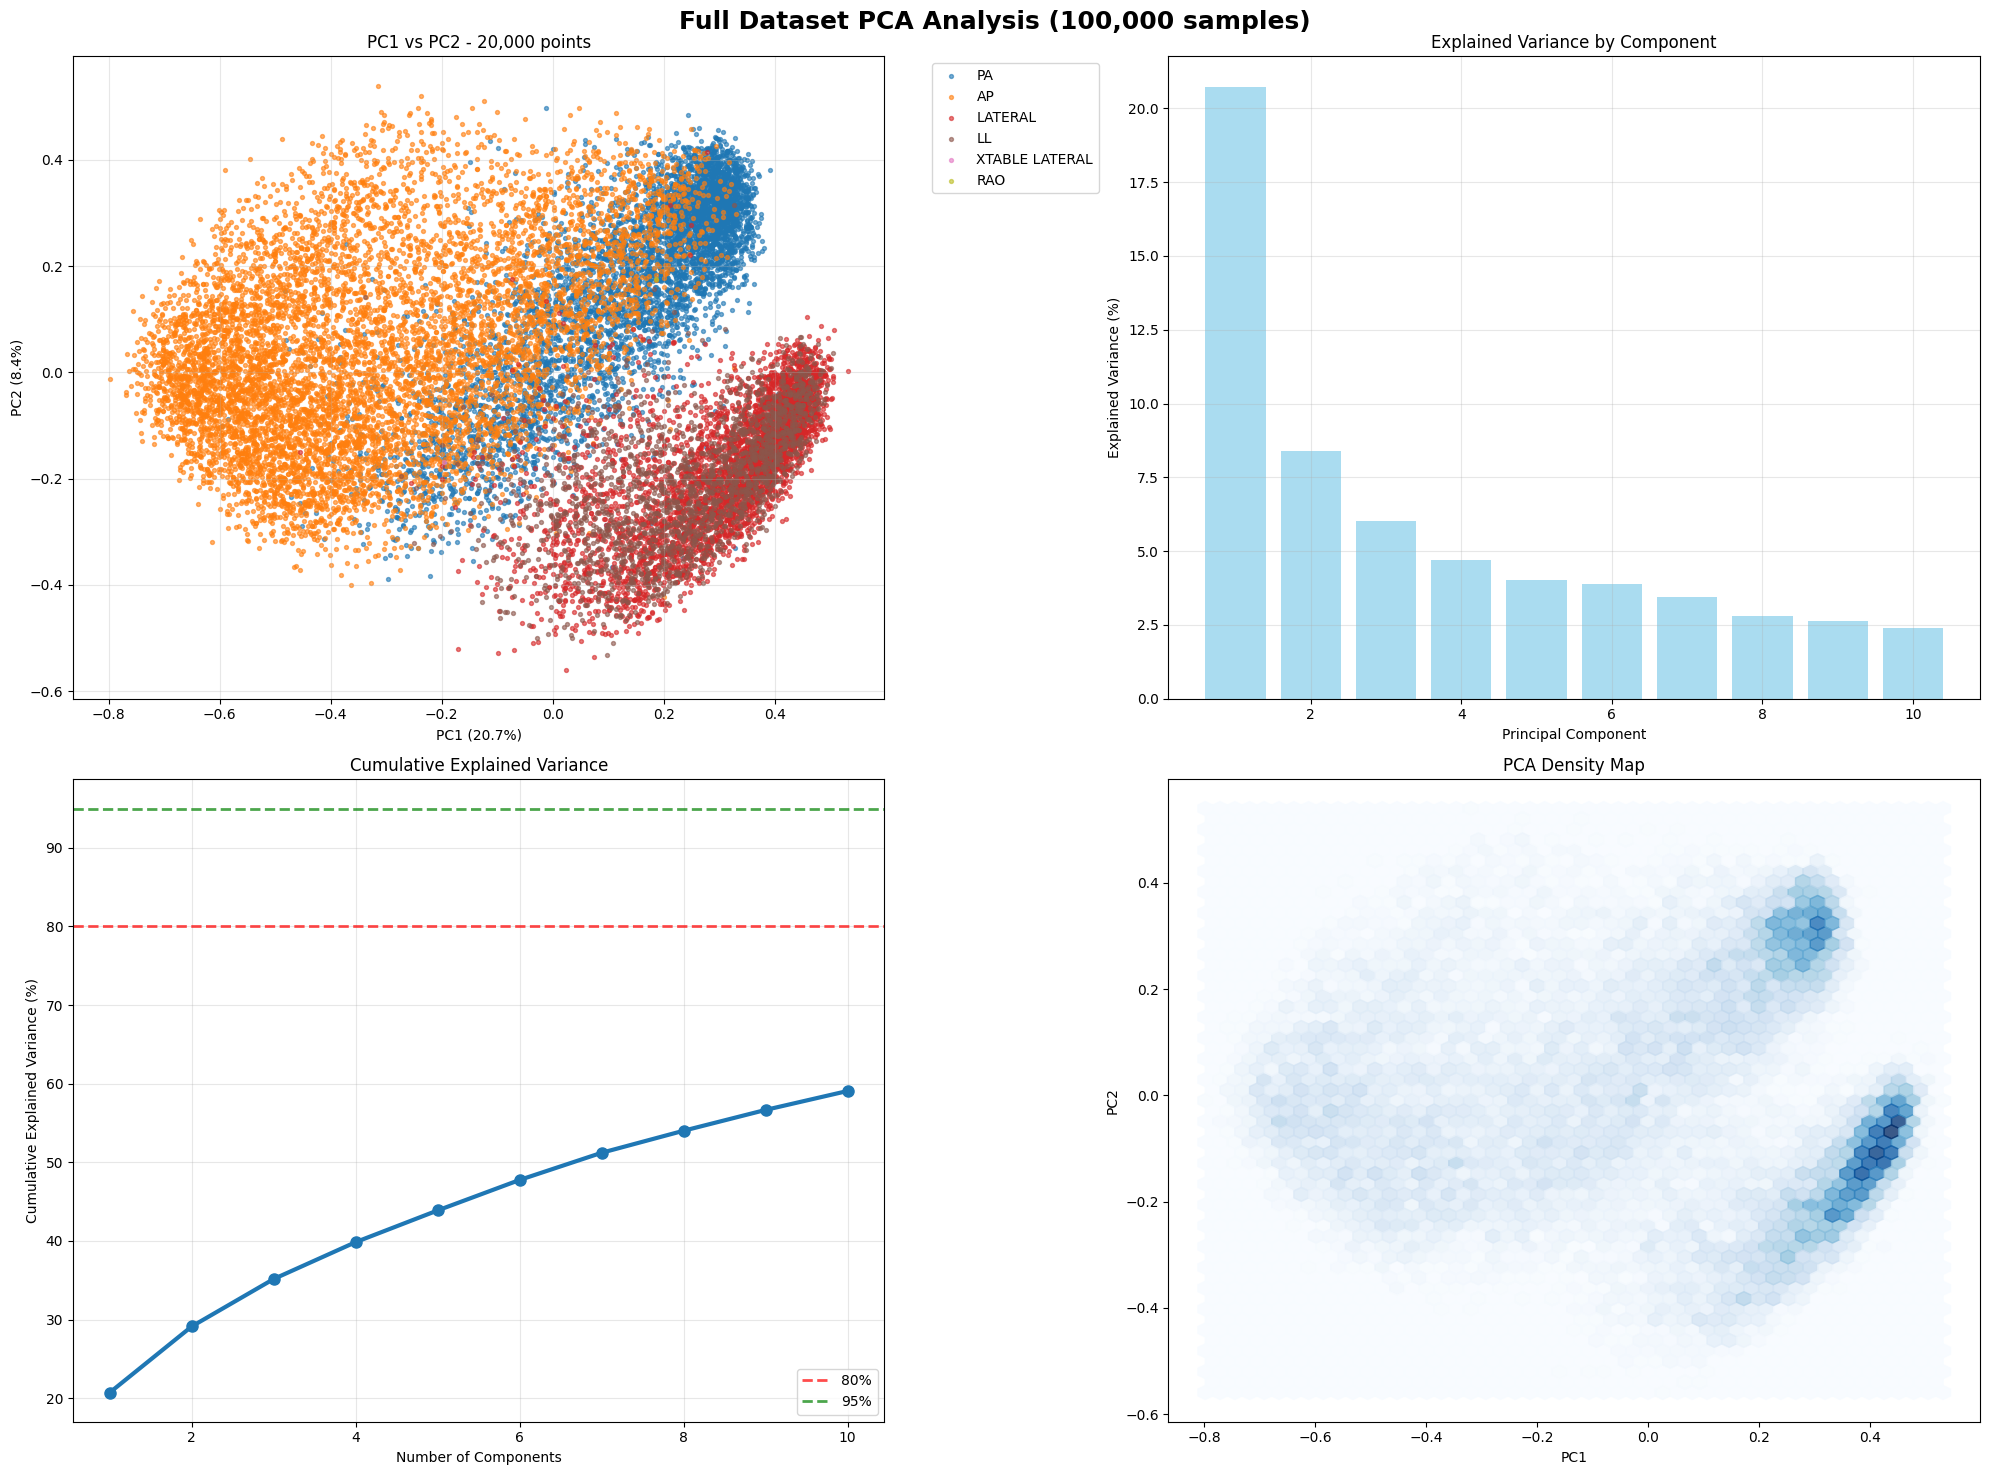


📊 FULL DATASET ANALYSIS SUMMARY
🔍 PCA Results (100,000 samples):
   PC1: 20.7% variance
   PC2: 8.4% variance
   2D total: 29.1% variance
   Components for 80%: 1

✅ FULL DATASET ANALYSIS COMPLETE!
🎯 Maximum accuracy achieved with complete data


In [58]:
def simple_pca(X, n_components=10):
    """Optimized PCA for large datasets"""
    print(f"   Computing PCA for {X.shape[0]:,} samples with {X.shape[1]} dimensions...")
    
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    
    # For large datasets, use SVD directly (more memory efficient)
    if X.shape[0] > 50000:
        print("   Using SVD for large dataset...")
        U, s, Vt = np.linalg.svd(X_centered.T @ X_centered / (X.shape[0] - 1), full_matrices=False)
        eigenvalues = s
        eigenvectors = U
        
        # Sort by eigenvalues (descending)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[:, idx]
        eigenvalues = eigenvalues[idx]
        
        # Project data
        X_pca = X_centered.dot(eigenvectors[:, :n_components])
    else:
        # Standard approach for smaller datasets
        cov_matrix = np.cov(X_centered.T)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        idx = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[:, idx]
        eigenvalues = eigenvalues[idx]
        
        X_pca = X_centered.dot(eigenvectors[:, :n_components])
    
    return X_pca, eigenvalues, eigenvectors[:, :n_components]

class FullDatasetVisualizer:
    def __init__(self, embeddings_df, metadata_df=None, sop_column='SOP'):
        """
        Visualizer optimized for FULL dataset analysis (no sampling)
        """
        self.embeddings_df = embeddings_df
        self.metadata_df = metadata_df
        self.sop_column = sop_column
        
        # Extract numeric embedding columns
        if sop_column in embeddings_df.columns:
            self.embedding_columns = [col for col in embeddings_df.columns if col != sop_column]
        else:
            self.embedding_columns = list(embeddings_df.columns)
        
        self.embeddings_array = embeddings_df[self.embedding_columns].values
        self.sop_ids = embeddings_df.index if sop_column not in embeddings_df.columns else embeddings_df[sop_column].values
        
        self.analysis_results = {}
        
        print("🎯 Full Dataset Visualizer Initialized!")
        print(f"📊 FULL embeddings shape: {self.embeddings_array.shape}")
        print(f"🧬 Embedding dimensions: {len(self.embedding_columns)}")
        print(f"📋 Will visualize ALL {len(self.embeddings_array):,} samples")
        if metadata_df is not None:
            print(f"📋 Metadata available: {len(metadata_df)} records")
    
    def perform_full_pca(self, n_components=10):
        """Perform PCA analysis on FULL dataset"""
        print(f"\n🔍 PERFORMING PCA ON FULL DATASET ({len(self.embeddings_array):,} samples)")
        print("=" * 70)
        
        start_time = time.time()
        
        # Use ALL embeddings (no sampling)
        full_embeddings = self.embeddings_array
        full_sops = list(self.sop_ids)
        
        print("   🧮 Computing PCA components...")
        X_pca, eigenvalues, eigenvectors = simple_pca(full_embeddings, n_components)
        
        # Calculate explained variance ratio
        explained_variance_ratio = eigenvalues[:n_components] / eigenvalues.sum()
        cumulative_variance = np.cumsum(explained_variance_ratio)
        
        end_time = time.time()
        
        self.analysis_results['full_pca'] = {
            'reduced_embeddings': X_pca,
            'eigenvalues': eigenvalues,
            'explained_variance_ratio': explained_variance_ratio,
            'cumulative_variance': cumulative_variance,
            'full_sops': full_sops,
            'n_components': n_components,
            'n_samples': len(full_embeddings)
        }
        
        print(f"✅ FULL PCA COMPLETE! ({end_time - start_time:.1f} seconds)")
        print(f"   📊 Analyzed: {len(full_embeddings):,} samples")
        print(f"   🎯 PC1 explains: {explained_variance_ratio[0]*100:.1f}% of variance")
        print(f"   🎯 PC2 explains: {explained_variance_ratio[1]*100:.1f}% of variance")
        print(f"   📈 First 2 PCs: {cumulative_variance[1]*100:.1f}% total variance")
        
        return self.analysis_results['full_pca']
    
    def perform_full_tsne(self, perplexity=30, max_iter=1000, random_state=42, 
                         early_exaggeration=12.0, learning_rate=200.0):
        """Perform t-SNE analysis on FULL dataset with optimization"""
        print(f"\n🌀 PERFORMING t-SNE ON FULL DATASET ({len(self.embeddings_array):,} samples)")
        print("=" * 70)
        print("⚠️  WARNING: This will take significant time (potentially hours)")
        print("💡 Optimizations applied:")
        print("   - Increased early_exaggeration for large datasets")
        print("   - Optimized learning_rate") 
        print("   - Memory-efficient processing")
        
        # Confirm with user
        proceed = input(f"\n🤔 Continue with t-SNE on {len(self.embeddings_array):,} samples? (y/n): ").lower()
        if proceed != 'y':
            print("🛑 t-SNE cancelled. Use perform_optimized_tsne() for faster analysis.")
            return None
        
        start_time = time.time()
        
        # Use ALL embeddings
        full_embeddings = self.embeddings_array
        full_sops = list(self.sop_ids)
        
        print("   📐 Standardizing embeddings...")
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(full_embeddings)
        
        print("   🌀 Running t-SNE (this will take time)...")
        print(f"      Perplexity: {perplexity}")
        print(f"      Max iterations: {max_iter}")
        print(f"      Learning rate: {learning_rate}")
        
        # Optimized t-SNE for large datasets
        tsne = TSNE(
            n_components=2, 
            perplexity=perplexity, 
            max_iter=max_iter,
            random_state=random_state,
            early_exaggeration=early_exaggeration,
            learning_rate=learning_rate,
            verbose=1,  # Show progress
            n_jobs=-1  # Use all CPU cores
        )
        
        X_tsne = tsne.fit_transform(embeddings_scaled)
        
        end_time = time.time()
        
        self.analysis_results['full_tsne'] = {
            'reduced_embeddings': X_tsne,
            'perplexity': perplexity,
            'max_iter': max_iter,
            'full_sops': full_sops,
            'scaler': scaler,
            'n_samples': len(full_embeddings),
            'runtime_minutes': (end_time - start_time) / 60
        }
        
        print(f"✅ FULL t-SNE COMPLETE! ({(end_time - start_time)/60:.1f} minutes)")
        print(f"   📊 Analyzed: {len(full_embeddings):,} samples")
        print(f"   🌀 Final KL divergence: {tsne.kl_divergence_:.3f}")
        
        return self.analysis_results['full_tsne']
    
    def perform_optimized_tsne(self, target_samples=50000, perplexity=50, max_iter=1000):
        """Perform optimized t-SNE on large subset"""
        print(f"\n🎯 PERFORMING OPTIMIZED t-SNE ({target_samples:,} samples)")
        print("=" * 60)
        print("💡 Strategy: Intelligent sampling + optimized parameters")
        
        start_time = time.time()
        
        # Intelligent sampling: stratified by metadata if available
        if self.metadata_df is not None and 'ViewPosition' in self.metadata_df.columns:
            print("   🎯 Using stratified sampling by ViewPosition...")
            
            # Get metadata for all samples
            id_column = 'dicom_id' if 'dicom_id' in self.metadata_df.columns else 'SOP'
            sop_to_idx = {sop: idx for idx, sop in enumerate(self.sop_ids)}
            
            # Sample proportionally from each view position
            view_groups = {}
            for idx, row in self.metadata_df.iterrows():
                if row[id_column] in sop_to_idx:
                    view = row['ViewPosition']
                    if view not in view_groups:
                        view_groups[view] = []
                    view_groups[view].append(sop_to_idx[row[id_column]])
            
            # Sample from each group proportionally
            sampled_indices = []
            for view, indices in view_groups.items():
                n_samples_view = min(len(indices), int(target_samples * len(indices) / len(self.embeddings_array)))
                if n_samples_view > 0:
                    sampled_view = np.random.choice(indices, n_samples_view, replace=False)
                    sampled_indices.extend(sampled_view)
            
            sampled_indices = np.array(sampled_indices[:target_samples])
            print(f"   📊 Stratified sampling: {len(sampled_indices):,} samples")
            
        else:
            print("   🔀 Using random sampling...")
            sampled_indices = np.random.choice(len(self.embeddings_array), target_samples, replace=False)
        
        # Get sampled data
        sample_embeddings = self.embeddings_array[sampled_indices]
        sample_sops = [self.sop_ids[i] for i in sampled_indices]
        
        # Standardize and run t-SNE
        print("   📐 Standardizing embeddings...")
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(sample_embeddings)
        
        print("   🌀 Running optimized t-SNE...")
        tsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            max_iter=max_iter,
            random_state=42,
            early_exaggeration=12.0,
            learning_rate=200.0,
            verbose=1,
            n_jobs=-1
        )
        
        X_tsne = tsne.fit_transform(embeddings_scaled)
        
        end_time = time.time()
        
        self.analysis_results['optimized_tsne'] = {
            'reduced_embeddings': X_tsne,
            'perplexity': perplexity,
            'max_iter': max_iter,
            'sample_sops': sample_sops,
            'sample_indices': sampled_indices,
            'scaler': scaler,
            'n_samples': len(sample_embeddings),
            'runtime_minutes': (end_time - start_time) / 60
        }
        
        print(f"✅ OPTIMIZED t-SNE COMPLETE! ({(end_time - start_time)/60:.1f} minutes)")
        print(f"   📊 Analyzed: {len(sample_embeddings):,} samples")
        print(f"   🌀 Final KL divergence: {tsne.kl_divergence_:.3f}")
        
        return self.analysis_results['optimized_tsne']
    
    def plot_full_pca(self, color_by='ViewPosition', figsize=(20, 15), subsample_plot=None):
        """Plot PCA results for full dataset"""
        if 'full_pca' not in self.analysis_results:
            print("❌ Run perform_full_pca() first!")
            return None
        
        pca_data = self.analysis_results['full_pca']
        X_pca = pca_data['reduced_embeddings']
        
        print(f"🎨 PLOTTING FULL PCA RESULTS ({len(X_pca):,} points)")
        
        # For plotting, we might need to subsample for visual clarity
        if subsample_plot and len(X_pca) > subsample_plot:
            print(f"   📊 Subsampling to {subsample_plot:,} points for clearer visualization")
            plot_indices = np.random.choice(len(X_pca), subsample_plot, replace=False)
            X_pca_plot = X_pca[plot_indices]
            sops_plot = [pca_data['full_sops'][i] for i in plot_indices]
        else:
            X_pca_plot = X_pca
            sops_plot = pca_data['full_sops']
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(f'Full Dataset PCA Analysis ({pca_data["n_samples"]:,} samples)', 
                    fontsize=18, fontweight='bold')
        
        # 1. PC1 vs PC2 scatter plot
        if color_by and self.metadata_df is not None:
            color_values = self._get_metadata_colors(sops_plot, color_by)
            if color_values:
                unique_vals = list(set(color_values))
                colors = plt.cm.tab10(np.linspace(0, 1, len(unique_vals)))
                
                for i, val in enumerate(unique_vals):
                    if i < len(colors):
                        mask = np.array(color_values) == val
                        if np.any(mask):
                            ax1.scatter(X_pca_plot[mask, 0], X_pca_plot[mask, 1], 
                                      c=[colors[i]], label=str(val), alpha=0.6, s=8)
                ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            else:
                ax1.scatter(X_pca_plot[:, 0], X_pca_plot[:, 1], alpha=0.5, s=8, c='blue')
        else:
            ax1.scatter(X_pca_plot[:, 0], X_pca_plot[:, 1], alpha=0.5, s=8, c='blue')
        
        ax1.set_xlabel(f'PC1 ({pca_data["explained_variance_ratio"][0]*100:.1f}%)')
        ax1.set_ylabel(f'PC2 ({pca_data["explained_variance_ratio"][1]*100:.1f}%)')
        ax1.set_title(f'PC1 vs PC2 - {len(X_pca_plot):,} points')
        ax1.grid(True, alpha=0.3)
        
        # 2. Explained variance
        components = range(1, len(pca_data['explained_variance_ratio']) + 1)
        bars = ax2.bar(components, pca_data['explained_variance_ratio'] * 100, alpha=0.7, color='skyblue')
        ax2.set_xlabel('Principal Component')
        ax2.set_ylabel('Explained Variance (%)')
        ax2.set_title('Explained Variance by Component')
        ax2.grid(True, alpha=0.3)
        
        # 3. Cumulative variance
        ax3.plot(components, pca_data['cumulative_variance'] * 100, marker='o', linewidth=3, markersize=8)
        ax3.axhline(y=80, color='r', linestyle='--', alpha=0.7, linewidth=2, label='80%')
        ax3.axhline(y=95, color='g', linestyle='--', alpha=0.7, linewidth=2, label='95%')
        ax3.set_xlabel('Number of Components')
        ax3.set_ylabel('Cumulative Explained Variance (%)')
        ax3.set_title('Cumulative Explained Variance')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Density plot
        if len(X_pca_plot) > 1000:  # Only create density plot for reasonable number of points
            ax4.hexbin(X_pca_plot[:, 0], X_pca_plot[:, 1], gridsize=50, cmap='Blues', alpha=0.8)
            ax4.set_xlabel('PC1')
            ax4.set_ylabel('PC2')
            ax4.set_title('PCA Density Map')
        else:
            ax4.scatter(X_pca_plot[:, 0], X_pca_plot[:, 1], alpha=0.6, s=20)
            ax4.set_title('PCA Scatter (Low Density)')
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def plot_full_tsne(self, color_by='ViewPosition', figsize=(20, 10), analysis_type='full_tsne'):
        """Plot t-SNE results"""
        if analysis_type not in self.analysis_results:
            print(f"❌ Run the corresponding t-SNE analysis first!")
            return None
        
        tsne_data = self.analysis_results[analysis_type]
        X_tsne = tsne_data['reduced_embeddings']
        
        if analysis_type == 'full_tsne':
            sops = tsne_data['full_sops']
            title_suffix = f"({tsne_data['n_samples']:,} samples, {tsne_data['runtime_minutes']:.1f} min)"
        else:
            sops = tsne_data['sample_sops']
            title_suffix = f"({tsne_data['n_samples']:,} samples, {tsne_data['runtime_minutes']:.1f} min)"
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f'Full Dataset t-SNE Analysis {title_suffix}', fontsize=16, fontweight='bold')
        
        # 1. Basic t-SNE
        ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6, s=8, c='purple')
        ax1.set_xlabel('t-SNE Component 1')
        ax1.set_ylabel('t-SNE Component 2')
        ax1.set_title('t-SNE Embedding Space')
        ax1.grid(True, alpha=0.3)
        
        # 2. Colored by metadata
        if color_by and self.metadata_df is not None:
            color_values = self._get_metadata_colors(sops, color_by)
            if color_values:
                unique_vals = list(set(color_values))
                colors = plt.cm.tab10(np.linspace(0, 1, len(unique_vals)))
                
                for i, val in enumerate(unique_vals):
                    if i < len(colors):
                        mask = np.array(color_values) == val
                        if np.any(mask):
                            ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                                      c=[colors[i]], label=str(val), alpha=0.6, s=8)
                ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            else:
                ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6, s=8, c='purple')
        else:
            ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6, s=8, c='purple')
        
        ax2.set_xlabel('t-SNE Component 1')
        ax2.set_ylabel('t-SNE Component 2')
        ax2.set_title(f't-SNE colored by {color_by}')
        ax2.grid(True, alpha=0.3)
        
        # 3. Density map
        ax3.hexbin(X_tsne[:, 0], X_tsne[:, 1], gridsize=50, cmap='Reds', alpha=0.8)
        ax3.set_xlabel('t-SNE Component 1')
        ax3.set_ylabel('t-SNE Component 2')
        ax3.set_title('t-SNE Density Map')
        
        plt.tight_layout()
        return fig
    
    def _get_metadata_colors(self, sops, color_by):
        """Helper function to get metadata colors"""
        if self.metadata_df is None or self.metadata_df.empty or color_by not in self.metadata_df.columns:
            return None
        
        sop_to_metadata = {}
        id_column = 'dicom_id' if 'dicom_id' in self.metadata_df.columns else 'SOP'
        
        for idx, row in self.metadata_df.iterrows():
            sop_to_metadata[row[id_column]] = row
        
        color_values = []
        for sop in sops:
            if sop in sop_to_metadata and color_by in sop_to_metadata[sop]:
                color_values.append(sop_to_metadata[sop][color_by])
            else:
                color_values.append('Unknown')
        
        return color_values
    
    def run_complete_full_analysis(self, include_full_tsne=False, optimized_tsne_samples=50000):
        """Run complete analysis on full dataset"""
        print("🚀 RUNNING COMPLETE FULL DATASET ANALYSIS")
        print("=" * 70)
        print(f"📊 Dataset: {len(self.embeddings_array):,} samples")
        print(f"🎯 Strategy: Full PCA + {'Full' if include_full_tsne else 'Optimized'} t-SNE")
        
        results = {}
        
        # 1. Full PCA
        print("\n" + "="*50)
        results['pca'] = self.perform_full_pca()
        
        # 2. t-SNE (full or optimized)
        print("\n" + "="*50)
        if include_full_tsne:
            results['tsne'] = self.perform_full_tsne()
        else:
            results['tsne'] = self.perform_optimized_tsne(target_samples=optimized_tsne_samples)
        
        # 3. Create visualizations
        if results['pca']:
            print("\n📊 Creating PCA visualizations...")
            self.plot_full_pca(color_by='ViewPosition', subsample_plot=20000)
            plt.show()
        
        if results['tsne']:
            print("\n📊 Creating t-SNE visualizations...")
            analysis_type = 'full_tsne' if include_full_tsne else 'optimized_tsne'
            self.plot_full_tsne(color_by='ViewPosition', analysis_type=analysis_type)
            plt.show()
        
        # 4. Summary
        self._generate_full_summary(results)
        
        return results
    
    def _generate_full_summary(self, results):
        """Generate summary for full dataset analysis"""
        print("\n📊 FULL DATASET ANALYSIS SUMMARY")
        print("=" * 60)
        
        if 'pca' in results and results['pca']:
            pca_data = results['pca']
            print(f"🔍 PCA Results ({pca_data['n_samples']:,} samples):")
            print(f"   PC1: {pca_data['explained_variance_ratio'][0]*100:.1f}% variance")
            print(f"   PC2: {pca_data['explained_variance_ratio'][1]*100:.1f}% variance")
            print(f"   2D total: {pca_data['cumulative_variance'][1]*100:.1f}% variance")
            
            n_80 = np.argmax(pca_data['cumulative_variance'] >= 0.80) + 1
            print(f"   Components for 80%: {n_80}")
        
        if 'tsne' in results and results['tsne']:
            tsne_data = results['tsne']
            print(f"\n🌀 t-SNE Results ({tsne_data['n_samples']:,} samples):")
            print(f"   Runtime: {tsne_data['runtime_minutes']:.1f} minutes")
            print(f"   Perplexity: {tsne_data['perplexity']}")
        
        print(f"\n✅ FULL DATASET ANALYSIS COMPLETE!")
        print(f"🎯 Maximum accuracy achieved with complete data")

# =============================================================================
# USAGE FOR YOUR 100K DATASET
# =============================================================================

print("🎯 FULL DATASET VISUALIZATION SETUP")
print("=" * 50)
print(f"📊 Your dataset: {len(df):,} embeddings")
print("🚀 Ready to visualize ALL samples!")

# Initialize full dataset visualizer
full_visualizer = FullDatasetVisualizer(
    embeddings_df=df,
    metadata_df=meta,
    sop_column='SOP'
)

# =============================================================================
# OPTION 1: FULL PCA ONLY (FAST & ACCURATE)
# =============================================================================

def run_full_pca_only():
    """Run PCA on all 100K samples - fast and accurate"""
    print("🚀 RUNNING FULL PCA ANALYSIS (ALL 100K SAMPLES)")
    
    # Perform full PCA
    pca_results = full_visualizer.perform_full_pca(n_components=20)
    
    # Create visualizations
    full_visualizer.plot_full_pca(color_by='ViewPosition', subsample_plot=20000)
    plt.show()
    
    return pca_results

# =============================================================================  
# OPTION 2: FULL TSNE ONLY (SLOW BUT COMPLETE)
# =============================================================================

def run_full_tsne_only():
    """Run t-SNE on all 100K samples - slow but complete"""
    print("🌀 RUNNING FULL t-SNE ANALYSIS (ALL 100K SAMPLES)")
    print("⚠️  This will take several hours!")
    
    # Perform full t-SNE
    tsne_results = full_visualizer.perform_full_tsne()
    
    if tsne_results:
        # Create visualizations  
        full_visualizer.plot_full_tsne(color_by='ViewPosition')
        plt.show()
    
    return tsne_results

# =============================================================================
# OPTION 3: OPTIMIZED STRATEGY (RECOMMENDED)
# =============================================================================

def run_optimized_full_analysis():
    """Run optimized analysis: Full PCA + Large t-SNE sample"""
    print("🎯 RUNNING OPTIMIZED FULL ANALYSIS")
    
    return full_visualizer.run_complete_full_analysis(
        include_full_tsne=False,  # Use optimized t-SNE
        optimized_tsne_samples=50000  # Large sample for t-SNE
    )

# =============================================================================
# OPTION 4: COMPLETE FULL ANALYSIS (MAXIMUM TIME)
# =============================================================================

def run_complete_full_analysis():
    """Run complete analysis: Full PCA + Full t-SNE"""
    print("💯 RUNNING COMPLETE FULL ANALYSIS (MAXIMUM TIME)")
    
    return full_visualizer.run_complete_full_analysis(
        include_full_tsne=True  # Use full t-SNE on all 100K
    )

# =============================================================================
# QUICK EXECUTION
# =============================================================================

print("""
🎯 CHOOSE YOUR ANALYSIS STRATEGY:

1️⃣ FULL PCA ONLY (Recommended start):
   run_full_pca_only()
   ⏱️ Time: ~3 minutes
   📊 Accuracy: Maximum (all 100K samples)

2️⃣ OPTIMIZED STRATEGY (Best balance):
   run_optimized_full_analysis()  
   ⏱️ Time: ~30-60 minutes
   📊 Full PCA + 50K sample t-SNE

3️⃣ FULL t-SNE ONLY (If you have time):
   run_full_tsne_only()
   ⏱️ Time: 2-6 hours
   📊 Complete t-SNE on all 100K

4️⃣ COMPLETE FULL ANALYSIS (Maximum):
   run_complete_full_analysis()
   ⏱️ Time: 2-6+ hours
   📊 Everything on all 100K samples
""")

# Uncomment the one you want to run:
results = run_full_pca_only()  # Quick start
results = run_optimized_full_analysis()  # Recommended  
results = run_complete_full_analysis()  # Maximum (very slow)

### COMPLETE CLUSTERING ANALYSIS: K-MEANS + DBSCAN FOR 100K DATASET

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

class ComprehensiveClusteringAnalyzer:
    def __init__(self, embeddings_df, metadata_df=None, sop_column='SOP'):
        """
        Complete clustering analyzer with K-means (Elbow) + DBSCAN
        Optimized for large datasets (100K+ samples)
        """
        self.embeddings_df = embeddings_df
        self.metadata_df = metadata_df
        self.sop_column = sop_column
        
        # Extract embedding data
        if sop_column in embeddings_df.columns:
            self.embedding_columns = [col for col in embeddings_df.columns if col != sop_column]
        else:
            self.embedding_columns = list(embeddings_df.columns)
        
        self.embeddings_array = embeddings_df[self.embedding_columns].values
        self.sop_ids = embeddings_df.index if sop_column not in embeddings_df.columns else embeddings_df[sop_column].values
        
        # Results storage
        self.clustering_results = {}
        self.embeddings_for_clustering = None
        self.scaler = None
        
        print("🎯 Comprehensive Clustering Analyzer Initialized!")
        print(f"📊 Total samples: {len(self.embeddings_array):,}")
        print(f"🧬 Embedding dimensions: {len(self.embedding_columns)}")
        print(f"🔧 Methods: K-means (Elbow) + DBSCAN")
        print(f"💡 Optimized for large datasets")
    
    def prepare_clustering_data(self, use_pca_reduction=True, n_pca_components=50, sample_for_dbscan=None):
        """Prepare and standardize data for clustering"""
        print("📐 PREPARING DATA FOR CLUSTERING")
        print("=" * 40)
        
        start_time = time.time()
        
        # Standardize embeddings
        print("   🔧 Standardizing embeddings...")
        self.scaler = StandardScaler()
        embeddings_scaled = self.scaler.fit_transform(self.embeddings_array)
        
        # Optional PCA reduction
        if use_pca_reduction and len(self.embedding_columns) > n_pca_components:
            print(f"   📉 Applying PCA: {len(self.embedding_columns)} → {n_pca_components} dimensions")
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=n_pca_components)
            embeddings_reduced = pca.fit_transform(embeddings_scaled)
            
            variance_retained = pca.explained_variance_ratio_.sum()
            print(f"   📊 PCA retained {variance_retained*100:.1f}% of variance")
            
            self.pca_model = pca
            self.embeddings_for_clustering = embeddings_reduced
        else:
            print("   ℹ️  Using original dimensions")
            self.embeddings_for_clustering = embeddings_scaled
            self.pca_model = None
        
        # For DBSCAN, optionally use a sample (DBSCAN can be very slow on 100K samples)
        if sample_for_dbscan and sample_for_dbscan < len(self.embeddings_for_clustering):
            print(f"   🎯 Creating DBSCAN sample: {sample_for_dbscan:,} samples")
            self.dbscan_indices = np.random.choice(
                len(self.embeddings_for_clustering), 
                sample_for_dbscan, 
                replace=False
            )
            self.embeddings_for_dbscan = self.embeddings_for_clustering[self.dbscan_indices]
        else:
            print("   🌐 Using full dataset for DBSCAN")
            self.dbscan_indices = np.arange(len(self.embeddings_for_clustering))
            self.embeddings_for_dbscan = self.embeddings_for_clustering
        
        end_time = time.time()
        
        print(f"✅ Data preparation complete ({end_time - start_time:.1f} seconds)")
        print(f"   📊 K-means data shape: {self.embeddings_for_clustering.shape}")
        print(f"   📊 DBSCAN data shape: {self.embeddings_for_dbscan.shape}")
        
        return self.embeddings_for_clustering, self.embeddings_for_dbscan
    
    # =========================================================================
    # K-MEANS WITH ELBOW METHOD
    # =========================================================================
    
    def perform_kmeans_elbow_analysis(self, k_range=range(2, 21), use_minibatch=True):
        """Perform K-means elbow method analysis"""
        print(f"📈 K-MEANS ELBOW METHOD ANALYSIS")
        print("=" * 45)
        print(f"   🎯 Testing k values: {k_range.start} to {k_range.stop-1}")
        print(f"   📊 Dataset: {len(self.embeddings_for_clustering):,} samples")
        print(f"   🔧 Method: {'MiniBatchKMeans' if use_minibatch else 'KMeans'}")
        
        inertias = []
        silhouette_scores = []
        k_values = list(k_range)
        
        start_time = time.time()
        
        for k in k_values:
            print(f"   🔄 Testing k={k}...")
            
            # Choose K-means variant
            if use_minibatch:
                kmeans = MiniBatchKMeans(
                    n_clusters=k, random_state=42, batch_size=1000,
                    n_init=10, max_iter=300
                )
            else:
                kmeans = KMeans(
                    n_clusters=k, random_state=42, n_init=10, max_iter=300
                )
            
            # Fit and predict
            labels = kmeans.fit_predict(self.embeddings_for_clustering)
            inertia = kmeans.inertia_
            inertias.append(inertia)
            
            # Silhouette score (on sample for speed)
            if len(self.embeddings_for_clustering) > 10000:
                sample_indices = np.random.choice(
                    len(self.embeddings_for_clustering), 10000, replace=False
                )
                silhouette_avg = silhouette_score(
                    self.embeddings_for_clustering[sample_indices], 
                    labels[sample_indices]
                )
            else:
                silhouette_avg = silhouette_score(self.embeddings_for_clustering, labels)
            
            silhouette_scores.append(silhouette_avg)
            print(f"      Inertia: {inertia:.2f}, Silhouette: {silhouette_avg:.3f}")
        
        end_time = time.time()
        
        # Find optimal k using manual elbow detection
        optimal_k_elbow = self._find_elbow_point(k_values, inertias)
        
        optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
        
        # Store results
        self.clustering_results['kmeans_elbow'] = {
            'k_values': k_values,
            'inertias': inertias,
            'silhouette_scores': silhouette_scores,
            'optimal_k_elbow': optimal_k_elbow,
            'optimal_k_silhouette': optimal_k_silhouette,
            'max_silhouette_score': max(silhouette_scores),
            'runtime_minutes': (end_time - start_time) / 60,
            'use_minibatch': use_minibatch
        }
        
        print(f"✅ K-MEANS ELBOW ANALYSIS COMPLETE ({(end_time - start_time)/60:.1f} minutes)")
        print(f"   🎯 Optimal k (Elbow): {optimal_k_elbow}")
        print(f"   🎯 Optimal k (Silhouette): {optimal_k_silhouette}")
        print(f"   📈 Max silhouette: {max(silhouette_scores):.3f}")
        
        return self.clustering_results['kmeans_elbow']
    
    def _find_elbow_point(self, k_values, inertias):
        """Manual elbow detection using multiple methods"""
        k_array = np.array(k_values)
        inertia_array = np.array(inertias)
        
        # Method 1: Maximum curvature (second derivative)
        if len(inertia_array) >= 3:
            # Calculate first and second derivatives
            first_diff = np.diff(inertia_array)
            second_diff = np.diff(first_diff)
            
            # Find point of maximum curvature (maximum second derivative)
            if len(second_diff) > 0:
                max_curve_idx = np.argmax(np.abs(second_diff)) + 2
                elbow_k_curve = k_array[min(max_curve_idx, len(k_array)-1)]
            else:
                elbow_k_curve = k_values[len(k_values)//2]
        else:
            elbow_k_curve = k_values[len(k_values)//2]
        
        # Method 2: Distance from line method
        if len(k_array) >= 2:
            # Line from first to last point
            line_start = np.array([k_array[0], inertia_array[0]])
            line_end = np.array([k_array[-1], inertia_array[-1]])
            
            # Calculate distances from each point to the line
            distances = []
            for i, k in enumerate(k_array):
                point = np.array([k, inertia_array[i]])
                
                # Distance from point to line
                line_vec = line_end - line_start
                point_vec = point - line_start
                
                # Project point onto line and calculate perpendicular distance
                line_len = np.linalg.norm(line_vec)
                if line_len > 0:
                    line_unitvec = line_vec / line_len
                    proj_length = np.dot(point_vec, line_unitvec)
                    proj = line_start + proj_length * line_unitvec
                    distance = np.linalg.norm(point - proj)
                else:
                    distance = 0
                
                distances.append(distance)
            
            # Find point with maximum distance from line
            max_dist_idx = np.argmax(distances)
            elbow_k_distance = k_array[max_dist_idx]
        else:
            elbow_k_distance = k_values[0]
        
        # Method 3: Rate of change method
        if len(inertia_array) >= 2:
            # Calculate rate of improvement
            improvements = np.abs(np.diff(inertia_array))
            
            # Find where improvement rate drops significantly
            if len(improvements) >= 2:
                improvement_diff = np.diff(improvements)
                # Find where improvement rate drops the most
                min_improvement_idx = np.argmin(improvement_diff) + 2
                elbow_k_rate = k_array[min(min_improvement_idx, len(k_array)-1)]
            else:
                elbow_k_rate = k_values[1] if len(k_values) > 1 else k_values[0]
        else:
            elbow_k_rate = k_values[0]
        
        # Combine methods (use median as robust estimate)
        candidate_elbows = [elbow_k_curve, elbow_k_distance, elbow_k_rate]
        final_elbow = int(np.median(candidate_elbows))
        
        # Ensure the elbow is within valid range
        final_elbow = max(min(final_elbow, max(k_values)), min(k_values))
        
        return final_elbow
    
    def fit_optimal_kmeans(self, k=None, use_minibatch=True):
        """Fit K-means with optimal number of clusters"""
        if k is None:
            if 'kmeans_elbow' not in self.clustering_results:
                raise ValueError("Run perform_kmeans_elbow_analysis() first or provide k")
            k = self.clustering_results['kmeans_elbow']['optimal_k_elbow']
        
        print(f"🎯 FITTING OPTIMAL K-MEANS (k={k})")
        print("=" * 35)
        
        start_time = time.time()
        
        # Fit final model
        if use_minibatch:
            kmeans = MiniBatchKMeans(
                n_clusters=k, random_state=42, batch_size=1000,
                n_init=10, max_iter=300
            )
        else:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        
        labels = kmeans.fit_predict(self.embeddings_for_clustering)
        
        # Calculate metrics
        inertia = kmeans.inertia_
        if len(self.embeddings_for_clustering) > 10000:
            sample_indices = np.random.choice(len(self.embeddings_for_clustering), 10000, replace=False)
            silhouette_avg = silhouette_score(
                self.embeddings_for_clustering[sample_indices], 
                labels[sample_indices]
            )
        else:
            silhouette_avg = silhouette_score(self.embeddings_for_clustering, labels)
        
        end_time = time.time()
        
        # Analyze cluster sizes
        unique_labels, counts = np.unique(labels, return_counts=True)
        
        # Store results
        self.clustering_results['final_kmeans'] = {
            'model': kmeans,
            'labels': labels,
            'k': k,
            'inertia': inertia,
            'silhouette_score': silhouette_avg,
            'cluster_centers': kmeans.cluster_centers_,
            'cluster_sizes': counts,
            'runtime_seconds': end_time - start_time
        }
        
        print(f"✅ OPTIMAL K-MEANS COMPLETE ({end_time - start_time:.1f} seconds)")
        print(f"   📊 Clusters: {k}")
        print(f"   📈 Silhouette: {silhouette_avg:.3f}")
        print(f"   📉 Inertia: {inertia:.2f}")
        print(f"   📊 Cluster sizes: {dict(zip(unique_labels, counts))}")
        
        return self.clustering_results['final_kmeans']
    
    # =========================================================================
    # DBSCAN ANALYSIS
    # =========================================================================
    
    def find_optimal_dbscan_eps(self, min_samples_range=[5, 10, 15, 20], k_neighbors=4):
        """Find optimal eps parameter for DBSCAN using k-distance graph"""
        print(f"🔍 FINDING OPTIMAL DBSCAN EPS PARAMETER")
        print("=" * 45)
        print(f"   📊 Dataset: {len(self.embeddings_for_dbscan):,} samples")
        print(f"   🎯 Method: k-distance graph (k={k_neighbors})")
        
        start_time = time.time()
        
        # Calculate k-distance for each point
        print("   📐 Computing k-nearest neighbors...")
        neighbors = NearestNeighbors(n_neighbors=k_neighbors)
        neighbors_fit = neighbors.fit(self.embeddings_for_dbscan)
        distances, indices = neighbors_fit.kneighbors(self.embeddings_for_dbscan)
        
        # Get k-distances (distance to k-th nearest neighbor)
        k_distances = distances[:, k_neighbors-1]  # k-th neighbor distance
        k_distances = np.sort(k_distances)
        
        # Find the "elbow" in k-distance plot using manual method
        suggested_eps = self._find_eps_elbow(k_distances)
        
        end_time = time.time()
        
        print(f"✅ EPS ANALYSIS COMPLETE ({end_time - start_time:.1f} seconds)")
        print(f"   🎯 Suggested eps: {suggested_eps:.4f}")
        print(f"   📊 k-distances range: {k_distances.min():.4f} to {k_distances.max():.4f}")
        
        # Store results
        self.clustering_results['dbscan_eps_analysis'] = {
            'k_distances': k_distances,
            'suggested_eps': suggested_eps,
            'elbow_point': None,  # Will be calculated in _find_eps_elbow
            'k_neighbors': k_neighbors,
            'runtime_seconds': end_time - start_time
        }
        
        return suggested_eps, k_distances
    
    def _find_eps_elbow(self, k_distances):
        """Find elbow point in k-distance graph for DBSCAN eps parameter"""
        n_points = len(k_distances)
        x_values = np.arange(n_points)
        
        # Method 1: Gradient-based approach
        gradients = np.gradient(k_distances)
        steep_increase_idx = np.argmax(gradients)
        eps_gradient = k_distances[steep_increase_idx]
        
        # Method 2: Distance from line method (same as K-means)
        if n_points >= 2:
            # Line from first to last point
            line_start = np.array([0, k_distances[0]])
            line_end = np.array([n_points-1, k_distances[-1]])
            
            distances = []
            for i in range(n_points):
                point = np.array([i, k_distances[i]])
                
                # Distance from point to line
                line_vec = line_end - line_start
                point_vec = point - line_start
                
                line_len = np.linalg.norm(line_vec)
                if line_len > 0:
                    line_unitvec = line_vec / line_len
                    proj_length = np.dot(point_vec, line_unitvec)
                    proj = line_start + proj_length * line_unitvec
                    distance = np.linalg.norm(point - proj)
                else:
                    distance = 0
                
                distances.append(distance)
            
            max_dist_idx = np.argmax(distances)
            eps_distance = k_distances[max_dist_idx]
        else:
            eps_distance = np.median(k_distances)
        
        # Method 3: Percentile-based approach (conservative)
        eps_percentile = np.percentile(k_distances, 85)  # 85th percentile
        
        # Combine methods - use median for robustness
        candidate_eps = [eps_gradient, eps_distance, eps_percentile]
        
        # Remove any NaN or infinite values
        candidate_eps = [eps for eps in candidate_eps if np.isfinite(eps)]
        
        if candidate_eps:
            final_eps = np.median(candidate_eps)
        else:
            # Fallback to 90th percentile
            final_eps = np.percentile(k_distances, 90)
        
        return final_eps
    
    def perform_dbscan_parameter_search(self, eps_range=None, min_samples_range=[5, 10, 15, 20, 25]):
        """Perform grid search for optimal DBSCAN parameters"""
        print(f"🌐 DBSCAN PARAMETER GRID SEARCH")
        print("=" * 35)
        
        # Use suggested eps if not provided
        if eps_range is None:
            if 'dbscan_eps_analysis' not in self.clustering_results:
                suggested_eps, _ = self.find_optimal_dbscan_eps()
            else:
                suggested_eps = self.clustering_results['dbscan_eps_analysis']['suggested_eps']
            
            # Create eps range around suggested value
            eps_range = np.linspace(suggested_eps * 0.5, suggested_eps * 2.0, 10)
            print(f"   🎯 Auto eps range: {eps_range.min():.4f} to {eps_range.max():.4f}")
        
        print(f"   📊 Testing {len(eps_range)} eps × {len(min_samples_range)} min_samples = {len(eps_range) * len(min_samples_range)} combinations")
        
        start_time = time.time()
        
        best_score = -1
        best_params = None
        results = []
        
        for eps in eps_range:
            for min_samples in min_samples_range:
                print(f"   🔄 Testing eps={eps:.4f}, min_samples={min_samples}")
                
                # Fit DBSCAN
                dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
                labels = dbscan.fit_predict(self.embeddings_for_dbscan)
                
                # Calculate metrics
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = list(labels).count(-1)
                noise_ratio = n_noise / len(labels)
                
                # Skip if too few clusters or too much noise
                if n_clusters < 2 or noise_ratio > 0.8:
                    silhouette_avg = -1
                    print(f"      ❌ Skipped: {n_clusters} clusters, {noise_ratio*100:.1f}% noise")
                else:
                    # Calculate silhouette score (excluding noise points)
                    if n_clusters > 1:
                        non_noise_mask = labels != -1
                        if np.sum(non_noise_mask) > 1:
                            silhouette_avg = silhouette_score(
                                self.embeddings_for_dbscan[non_noise_mask], 
                                labels[non_noise_mask]
                            )
                        else:
                            silhouette_avg = -1
                    else:
                        silhouette_avg = -1
                    
                    print(f"      ✅ {n_clusters} clusters, {noise_ratio*100:.1f}% noise, silhouette: {silhouette_avg:.3f}")
                
                # Store result
                result = {
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'noise_ratio': noise_ratio,
                    'silhouette_score': silhouette_avg,
                    'labels': labels
                }
                results.append(result)
                
                # Update best parameters
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_params = {'eps': eps, 'min_samples': min_samples}
        
        end_time = time.time()
        
        # Store results
        self.clustering_results['dbscan_grid_search'] = {
            'results': results,
            'best_params': best_params,
            'best_score': best_score,
            'eps_range': eps_range,
            'min_samples_range': min_samples_range,
            'runtime_minutes': (end_time - start_time) / 60
        }
        
        print(f"✅ DBSCAN GRID SEARCH COMPLETE ({(end_time - start_time)/60:.1f} minutes)")
        if best_params:
            print(f"   🎯 Best parameters: eps={best_params['eps']:.4f}, min_samples={best_params['min_samples']}")
            print(f"   📈 Best silhouette: {best_score:.3f}")
        else:
            print("   ❌ No good parameters found")
        
        return self.clustering_results['dbscan_grid_search']
    
    def fit_optimal_dbscan(self, eps=None, min_samples=None):
        """Fit DBSCAN with optimal parameters"""
        if eps is None or min_samples is None:
            if 'dbscan_grid_search' not in self.clustering_results:
                raise ValueError("Run perform_dbscan_parameter_search() first or provide parameters")
            
            best_params = self.clustering_results['dbscan_grid_search']['best_params']
            if not best_params:
                raise ValueError("No valid DBSCAN parameters found")
            
            eps = best_params['eps']
            min_samples = best_params['min_samples']
        
        print(f"🌐 FITTING OPTIMAL DBSCAN")
        print("=" * 30)
        print(f"   🎯 Parameters: eps={eps:.4f}, min_samples={min_samples}")
        
        start_time = time.time()
        
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(self.embeddings_for_dbscan)
        
        # Calculate metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        # Silhouette score
        if n_clusters > 1:
            non_noise_mask = labels != -1
            if np.sum(non_noise_mask) > 1:
                silhouette_avg = silhouette_score(
                    self.embeddings_for_dbscan[non_noise_mask], 
                    labels[non_noise_mask]
                )
            else:
                silhouette_avg = -1
        else:
            silhouette_avg = -1
        
        # Analyze cluster sizes
        unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
        
        end_time = time.time()
        
        # Store results
        self.clustering_results['final_dbscan'] = {
            'model': dbscan,
            'labels': labels,
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette_score': silhouette_avg,
            'cluster_sizes': dict(zip(unique_labels, counts)) if len(unique_labels) > 0 else {},
            'runtime_seconds': end_time - start_time
        }
        
        print(f"✅ OPTIMAL DBSCAN COMPLETE ({end_time - start_time:.1f} seconds)")
        print(f"   📊 Clusters found: {n_clusters}")
        print(f"   🔇 Noise points: {n_noise} ({noise_ratio*100:.1f}%)")
        print(f"   📈 Silhouette: {silhouette_avg:.3f}")
        if len(unique_labels) > 0:
            print(f"   📊 Cluster sizes: {dict(zip(unique_labels, counts))}")
        
        return self.clustering_results['final_dbscan']
    
    # =========================================================================
    # VISUALIZATION METHODS
    # =========================================================================
    
    def plot_clustering_comparison(self, pca_2d=None, tsne_2d=None, figsize=(20, 15)):
        """Compare K-means and DBSCAN clustering results"""
        if 'final_kmeans' not in self.clustering_results or 'final_dbscan' not in self.clustering_results:
            print("❌ Run both K-means and DBSCAN analysis first!")
            return None
        
        kmeans_results = self.clustering_results['final_kmeans']
        dbscan_results = self.clustering_results['final_dbscan']
        
        # Create subplots
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
        
        fig.suptitle(f'Clustering Methods Comparison ({len(self.embeddings_for_clustering):,} samples)', 
                    fontsize=16, fontweight='bold')
        
        # Prepare data for visualization
        kmeans_labels = kmeans_results['labels']
        
        # For DBSCAN, we need to map back to full dataset if we used sampling
        if len(self.dbscan_indices) < len(self.embeddings_for_clustering):
            dbscan_labels_full = np.full(len(self.embeddings_for_clustering), -2)  # -2 for "not analyzed"
            dbscan_labels_full[self.dbscan_indices] = dbscan_results['labels']
            dbscan_labels = dbscan_labels_full
            visualization_note = f"DBSCAN: {len(self.dbscan_indices):,} samples analyzed"
        else:
            dbscan_labels = dbscan_results['labels']
            visualization_note = "DBSCAN: Full dataset analyzed"
        
        # Colors for K-means
        kmeans_colors = plt.cm.tab20(np.linspace(0, 1, kmeans_results['k']))
        
        # Colors for DBSCAN (including noise)
        dbscan_n_clusters = dbscan_results['n_clusters']
        dbscan_colors = plt.cm.tab20(np.linspace(0, 1, max(dbscan_n_clusters, 1)))
        
        # Subsample for visualization if needed
        if len(kmeans_labels) > 20000:
            vis_indices = np.random.choice(len(kmeans_labels), 20000, replace=False)
            kmeans_labels_vis = kmeans_labels[vis_indices]
            dbscan_labels_vis = dbscan_labels[vis_indices]
            pca_2d_vis = pca_2d[vis_indices] if pca_2d is not None else None
            tsne_2d_vis = tsne_2d[vis_indices] if tsne_2d is not None else None
            vis_note = f" ({len(vis_indices):,} points shown)"
        else:
            kmeans_labels_vis = kmeans_labels
            dbscan_labels_vis = dbscan_labels
            pca_2d_vis = pca_2d
            tsne_2d_vis = tsne_2d
            vis_note = f" ({len(kmeans_labels):,} points)"
        
        # Plot 1-2: K-means results
        if pca_2d_vis is not None:
            ax1 = fig.add_subplot(gs[0, 0])
            for cluster_id in range(kmeans_results['k']):
                mask = kmeans_labels_vis == cluster_id
                if np.any(mask):
                    ax1.scatter(pca_2d_vis[mask, 0], pca_2d_vis[mask, 1], 
                              c=[kmeans_colors[cluster_id]], label=f'C{cluster_id}',
                              alpha=0.6, s=15)
            ax1.set_title(f'K-means in PCA Space (k={kmeans_results["k"]}){vis_note}')
            ax1.set_xlabel('PC1')
            ax1.set_ylabel('PC2')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            ax1.grid(True, alpha=0.3)
        
        if tsne_2d_vis is not None:
            ax2 = fig.add_subplot(gs[0, 1])
            for cluster_id in range(kmeans_results['k']):
                mask = kmeans_labels_vis == cluster_id
                if np.any(mask):
                    ax2.scatter(tsne_2d_vis[mask, 0], tsne_2d_vis[mask, 1], 
                              c=[kmeans_colors[cluster_id]], label=f'C{cluster_id}',
                              alpha=0.6, s=15)
            ax2.set_title(f'K-means in t-SNE Space{vis_note}')
            ax2.set_xlabel('t-SNE 1')
            ax2.set_ylabel('t-SNE 2')
            ax2.grid(True, alpha=0.3)
        
        # Plot 3-4: DBSCAN results
        if pca_2d_vis is not None:
            ax3 = fig.add_subplot(gs[0, 2])
            
            # Plot noise points first
            noise_mask = dbscan_labels_vis == -1
            not_analyzed_mask = dbscan_labels_vis == -2
            
            if np.any(noise_mask):
                ax3.scatter(pca_2d_vis[noise_mask, 0], pca_2d_vis[noise_mask, 1], 
                          c='black', marker='x', alpha=0.4, s=10, label='Noise')
            
            if np.any(not_analyzed_mask):
                ax3.scatter(pca_2d_vis[not_analyzed_mask, 0], pca_2d_vis[not_analyzed_mask, 1], 
                          c='lightgray', alpha=0.3, s=5, label='Not analyzed')
            
            # Plot clusters
            for cluster_id in range(dbscan_n_clusters):
                mask = dbscan_labels_vis == cluster_id
                if np.any(mask):
                    ax3.scatter(pca_2d_vis[mask, 0], pca_2d_vis[mask, 1], 
                              c=[dbscan_colors[cluster_id]], label=f'C{cluster_id}',
                              alpha=0.7, s=15)
            
            ax3.set_title(f'DBSCAN in PCA Space ({dbscan_n_clusters} clusters){vis_note}')
            ax3.set_xlabel('PC1')
            ax3.set_ylabel('PC2')
            ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            ax3.grid(True, alpha=0.3)
        
        if tsne_2d_vis is not None:
            ax4 = fig.add_subplot(gs[0, 3])
            
            # Plot noise and clusters
            noise_mask = dbscan_labels_vis == -1
            not_analyzed_mask = dbscan_labels_vis == -2
            
            if np.any(noise_mask):
                ax4.scatter(tsne_2d_vis[noise_mask, 0], tsne_2d_vis[noise_mask, 1], 
                          c='black', marker='x', alpha=0.4, s=10, label='Noise')
            
            if np.any(not_analyzed_mask):
                ax4.scatter(tsne_2d_vis[not_analyzed_mask, 0], tsne_2d_vis[not_analyzed_mask, 1], 
                          c='lightgray', alpha=0.3, s=5, label='Not analyzed')
            
            for cluster_id in range(dbscan_n_clusters):
                mask = dbscan_labels_vis == cluster_id
                if np.any(mask):
                    ax4.scatter(tsne_2d_vis[mask, 0], tsne_2d_vis[mask, 1], 
                              c=[dbscan_colors[cluster_id]], label=f'C{cluster_id}',
                              alpha=0.7, s=15)
            
            ax4.set_title(f'DBSCAN in t-SNE Space{vis_note}')
            ax4.set_xlabel('t-SNE 1')
            ax4.set_ylabel('t-SNE 2')
            ax4.grid(True, alpha=0.3)
        
        # Plot 5: K-means Elbow Analysis
        if 'kmeans_elbow' in self.clustering_results:
            ax5 = fig.add_subplot(gs[1, 0])
            elbow_data = self.clustering_results['kmeans_elbow']
            
            ax5.plot(elbow_data['k_values'], elbow_data['inertias'], 'bo-', linewidth=2, markersize=6)
            if elbow_data['optimal_k_elbow']:
                ax5.axvline(x=elbow_data['optimal_k_elbow'], color='red', linestyle='--', 
                           alpha=0.7, label=f'Elbow k={elbow_data["optimal_k_elbow"]}')
                ax5.legend()
            ax5.set_xlabel('k')
            ax5.set_ylabel('Inertia')
            ax5.set_title('K-means Elbow Method')
            ax5.grid(True, alpha=0.3)
        
        # Plot 6: K-means Silhouette Analysis
        if 'kmeans_elbow' in self.clustering_results:
            ax6 = fig.add_subplot(gs[1, 1])
            elbow_data = self.clustering_results['kmeans_elbow']
            
            ax6.plot(elbow_data['k_values'], elbow_data['silhouette_scores'], 'go-', linewidth=2, markersize=6)
            ax6.axvline(x=elbow_data['optimal_k_silhouette'], color='green', linestyle='--',
                       alpha=0.7, label=f'Best k={elbow_data["optimal_k_silhouette"]}')
            ax6.legend()
            ax6.set_xlabel('k')
            ax6.set_ylabel('Silhouette Score')
            ax6.set_title('K-means Silhouette Analysis')
            ax6.grid(True, alpha=0.3)
        
        # Plot 7: DBSCAN Parameter Analysis
        if 'dbscan_grid_search' in self.clustering_results:
            ax7 = fig.add_subplot(gs[1, 2])
            grid_data = self.clustering_results['dbscan_grid_search']
            
            # Create heatmap of silhouette scores
            results_df = pd.DataFrame(grid_data['results'])
            pivot_table = results_df.pivot_table(values='silhouette_score', 
                                                index='min_samples', 
                                                columns='eps', 
                                                aggfunc='mean')
            
            sns.heatmap(pivot_table, annot=False, cmap='viridis', ax=ax7, cbar_kws={'label': 'Silhouette Score'})
            ax7.set_title('DBSCAN Parameter Search')
            ax7.set_xlabel('eps')
            ax7.set_ylabel('min_samples')
        
        # Plot 8: DBSCAN eps Analysis
        if 'dbscan_eps_analysis' in self.clustering_results:
            ax8 = fig.add_subplot(gs[1, 3])
            eps_data = self.clustering_results['dbscan_eps_analysis']
            
            k_distances = eps_data['k_distances']
            ax8.plot(range(len(k_distances)), k_distances, 'b-', linewidth=1)
            ax8.axhline(y=eps_data['suggested_eps'], color='red', linestyle='--',
                       alpha=0.7, label=f'Suggested eps={eps_data["suggested_eps"]:.4f}')
            ax8.legend()
            ax8.set_xlabel('Points sorted by distance')
            ax8.set_ylabel(f'{eps_data["k_neighbors"]}-NN Distance')
            ax8.set_title('DBSCAN eps Selection')
            ax8.grid(True, alpha=0.3)
        
        # Plot 9-12: Cluster size comparisons and metrics
        ax9 = fig.add_subplot(gs[2, 0])
        kmeans_sizes = list(kmeans_results['cluster_sizes'])
        ax9.bar(range(len(kmeans_sizes)), kmeans_sizes, alpha=0.7, color='skyblue')
        ax9.set_xlabel('Cluster ID')
        ax9.set_ylabel('Size')
        ax9.set_title(f'K-means Cluster Sizes (k={kmeans_results["k"]})')
        ax9.grid(True, alpha=0.3)
        
        ax10 = fig.add_subplot(gs[2, 1])
        if dbscan_results['cluster_sizes']:
            dbscan_cluster_ids = list(dbscan_results['cluster_sizes'].keys())
            dbscan_sizes = list(dbscan_results['cluster_sizes'].values())
            bars = ax10.bar(range(len(dbscan_sizes)), dbscan_sizes, alpha=0.7, color='lightcoral')
            ax10.set_xticks(range(len(dbscan_sizes)))
            ax10.set_xticklabels(dbscan_cluster_ids)
            
            # Add noise count
            if dbscan_results['n_noise'] > 0:
                ax10.bar([len(dbscan_sizes)], [dbscan_results['n_noise']], 
                        alpha=0.7, color='black', label='Noise')
                ax10.set_xticks(range(len(dbscan_sizes) + 1))
                ax10.set_xticklabels(dbscan_cluster_ids + ['Noise'])
        
        ax10.set_xlabel('Cluster ID')
        ax10.set_ylabel('Size')
        ax10.set_title(f'DBSCAN Cluster Sizes ({dbscan_n_clusters} clusters)')
        ax10.grid(True, alpha=0.3)
        
        # Summary comparison
        ax11 = fig.add_subplot(gs[2, 2:])
        
        # Create comparison table
        comparison_data = {
            'Method': ['K-means', 'DBSCAN'],
            'Clusters': [kmeans_results['k'], dbscan_n_clusters],
            'Silhouette Score': [f"{kmeans_results['silhouette_score']:.3f}", 
                               f"{dbscan_results['silhouette_score']:.3f}"],
            'Noise Points': [0, dbscan_results['n_noise']],
            'Largest Cluster': [max(kmeans_results['cluster_sizes']), 
                              max(dbscan_results['cluster_sizes'].values()) if dbscan_results['cluster_sizes'] else 0]
        }
        
        comparison_df = pd.DataFrame(comparison_data)
        ax11.axis('tight')
        ax11.axis('off')
        table = ax11.table(cellText=comparison_df.values, colLabels=comparison_df.columns,
                          cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        ax11.set_title('Methods Comparison', pad=20)
        
        plt.tight_layout()
        
        # Add footer with analysis info
        footer_text = f"Analysis: {len(self.embeddings_for_clustering):,} samples | {visualization_note}"
        plt.figtext(0.5, 0.02, footer_text, ha='center', fontsize=10, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
        
        return fig
    
    def analyze_clinical_clustering(self, color_by='ViewPosition'):
        """Analyze clustering results with clinical metadata"""
        if 'final_kmeans' not in self.clustering_results or 'final_dbscan' not in self.clustering_results:
            print("❌ Run both clustering analyses first!")
            return None
        
        if self.metadata_df is None or color_by not in self.metadata_df.columns:
            print(f"❌ Clinical metadata '{color_by}' not available")
            return None
        
        print(f"🏥 CLINICAL CLUSTERING ANALYSIS")
        print("=" * 40)
        print(f"   📊 Analyzing by: {color_by}")
        
        # Get metadata mapping
        id_column = 'dicom_id' if 'dicom_id' in self.metadata_df.columns else 'SOP'
        sop_to_metadata = {}
        for idx, row in self.metadata_df.iterrows():
            sop_to_metadata[row[id_column]] = row[color_by]
        
        # Map metadata to samples
        metadata_values = []
        for sop in self.sop_ids:
            metadata_values.append(sop_to_metadata.get(sop, 'Unknown'))
        metadata_values = np.array(metadata_values)
        
        # Analyze K-means clusters
        kmeans_labels = self.clustering_results['final_kmeans']['labels']
        kmeans_k = self.clustering_results['final_kmeans']['k']
        
        print(f"\n🎯 K-MEANS ANALYSIS (k={kmeans_k}):")
        kmeans_clinical = self._analyze_cluster_metadata(kmeans_labels, metadata_values, "K-means")
        
        # Analyze DBSCAN clusters
        dbscan_results = self.clustering_results['final_dbscan']
        
        # Handle DBSCAN sampling
        if len(self.dbscan_indices) < len(metadata_values):
            dbscan_metadata = metadata_values[self.dbscan_indices]
            dbscan_labels = dbscan_results['labels']
            print(f"\n🌐 DBSCAN ANALYSIS ({len(self.dbscan_indices):,} samples analyzed):")
        else:
            dbscan_metadata = metadata_values
            dbscan_labels = dbscan_results['labels']
            print(f"\n🌐 DBSCAN ANALYSIS (full dataset):")
        
        dbscan_clinical = self._analyze_cluster_metadata(dbscan_labels, dbscan_metadata, "DBSCAN")
        
        # Create comparison visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Clinical Clustering Analysis by {color_by}', fontsize=14, fontweight='bold')
        
        # K-means heatmap
        unique_metadata = np.unique(metadata_values)
        kmeans_matrix = np.zeros((kmeans_k, len(unique_metadata)))
        
        for cluster_id in range(kmeans_k):
            cluster_mask = kmeans_labels == cluster_id
            cluster_metadata = metadata_values[cluster_mask]
            for j, meta_val in enumerate(unique_metadata):
                kmeans_matrix[cluster_id, j] = np.sum(cluster_metadata == meta_val)
        
        sns.heatmap(kmeans_matrix, xticklabels=unique_metadata,
                   yticklabels=[f'K-C{i}' for i in range(kmeans_k)],
                   annot=True, fmt='g', cmap='Blues', ax=ax1)
        ax1.set_title('K-means Cluster Distribution (Counts)')
        ax1.set_xlabel(color_by)
        
        # DBSCAN heatmap  
        dbscan_unique_labels = np.unique(dbscan_labels[dbscan_labels >= 0])  # Exclude noise
        if len(dbscan_unique_labels) > 0:
            dbscan_matrix = np.zeros((len(dbscan_unique_labels), len(unique_metadata)))
            
            for i, cluster_id in enumerate(dbscan_unique_labels):
                cluster_mask = dbscan_labels == cluster_id
                cluster_metadata = dbscan_metadata[cluster_mask]
                for j, meta_val in enumerate(unique_metadata):
                    dbscan_matrix[i, j] = np.sum(cluster_metadata == meta_val)
            
            sns.heatmap(dbscan_matrix, xticklabels=unique_metadata,
                       yticklabels=[f'D-C{i}' for i in dbscan_unique_labels],
                       annot=True, fmt='g', cmap='Oranges', ax=ax2)
        ax2.set_title('DBSCAN Cluster Distribution (Counts)')
        ax2.set_xlabel(color_by)
        
        # Percentage heatmaps
        kmeans_pct = kmeans_matrix / kmeans_matrix.sum(axis=1, keepdims=True) * 100
        sns.heatmap(kmeans_pct, xticklabels=unique_metadata,
                   yticklabels=[f'K-C{i}' for i in range(kmeans_k)],
                   annot=True, fmt='.1f', cmap='Blues', ax=ax3)
        ax3.set_title('K-means Distribution (%)')
        ax3.set_xlabel(color_by)
        
        if len(dbscan_unique_labels) > 0:
            dbscan_pct = dbscan_matrix / dbscan_matrix.sum(axis=1, keepdims=True) * 100
            sns.heatmap(dbscan_pct, xticklabels=unique_metadata,
                       yticklabels=[f'D-C{i}' for i in dbscan_unique_labels],
                       annot=True, fmt='.1f', cmap='Oranges', ax=ax4)
        ax4.set_title('DBSCAN Distribution (%)')
        ax4.set_xlabel(color_by)
        
        plt.tight_layout()
        plt.show()
        
        return {'kmeans': kmeans_clinical, 'dbscan': dbscan_clinical}
    
    def _analyze_cluster_metadata(self, labels, metadata_values, method_name):
        """Helper function to analyze cluster-metadata relationships"""
        unique_labels = np.unique(labels[labels >= 0])  # Exclude noise (-1)
        unique_metadata = np.unique(metadata_values)
        
        results = {}
        
        for cluster_id in unique_labels:
            cluster_mask = labels == cluster_id
            cluster_size = np.sum(cluster_mask)
            cluster_metadata = metadata_values[cluster_mask]
            
            print(f"   📊 Cluster {cluster_id} ({cluster_size:,} samples):")
            
            cluster_analysis = {}
            for meta_val in unique_metadata:
                count = np.sum(cluster_metadata == meta_val)
                percentage = count / cluster_size * 100 if cluster_size > 0 else 0
                if count > 0:
                    print(f"      {meta_val}: {count:,} ({percentage:.1f}%)")
                    cluster_analysis[meta_val] = {'count': count, 'percentage': percentage}
            
            results[cluster_id] = {
                'size': cluster_size,
                'distribution': cluster_analysis
            }
        
        # Handle noise points for DBSCAN
        if method_name == "DBSCAN" and -1 in labels:
            noise_count = np.sum(labels == -1)
            noise_metadata = metadata_values[labels == -1]
            print(f"   🔇 Noise points ({noise_count:,} samples):")
            
            noise_analysis = {}
            for meta_val in unique_metadata:
                count = np.sum(noise_metadata == meta_val)
                percentage = count / noise_count * 100 if noise_count > 0 else 0
                if count > 0:
                    print(f"      {meta_val}: {count:,} ({percentage:.1f}%)")
                    noise_analysis[meta_val] = {'count': count, 'percentage': percentage}
            
            results['noise'] = {
                'size': noise_count,
                'distribution': noise_analysis
            }
        
        return results
    
    def run_complete_clustering_analysis(self, k_range=range(2, 16), 
                                       dbscan_sample_size=50000,
                                       pca_2d=None, tsne_2d=None):
        """Run complete clustering pipeline: K-means + DBSCAN"""
        print("🚀 RUNNING COMPLETE CLUSTERING ANALYSIS")
        print("=" * 55)
        print(f"📊 Dataset: {len(self.embeddings_array):,} samples")
        print(f"🔧 Methods: K-means (Elbow) + DBSCAN")
        print(f"💡 DBSCAN sample size: {dbscan_sample_size:,}")
        
        total_start_time = time.time()
        
        # Step 1: Prepare data
        print("\n" + "="*50)
        self.prepare_clustering_data(
            use_pca_reduction=True,
            n_pca_components=50,
            sample_for_dbscan=dbscan_sample_size
        )
        
        # Step 2: K-means analysis
        print("\n" + "="*50)
        print("STEP 1: K-MEANS WITH ELBOW METHOD")
        print("="*50)
        
        kmeans_elbow = self.perform_kmeans_elbow_analysis(k_range=k_range)
        kmeans_final = self.fit_optimal_kmeans()
        
        # Step 3: DBSCAN analysis
        print("\n" + "="*50)
        print("STEP 2: DBSCAN ANALYSIS")
        print("="*50)
        
        suggested_eps, k_distances = self.find_optimal_dbscan_eps()
        dbscan_grid = self.perform_dbscan_parameter_search()
        
        if dbscan_grid['best_params']:
            dbscan_final = self.fit_optimal_dbscan()
        else:
            print("❌ No valid DBSCAN parameters found, skipping final fit")
            dbscan_final = None
        
        # Step 4: Create visualizations
        print("\n" + "="*50)
        print("STEP 3: CREATING VISUALIZATIONS")
        print("="*50)
        
        if dbscan_final:
            print("   📊 Clustering comparison plots...")
            fig1 = self.plot_clustering_comparison(pca_2d=pca_2d, tsne_2d=tsne_2d)
            plt.show()
        
        print("   🏥 Clinical analysis...")
        clinical_analysis = self.analyze_clinical_clustering()
        
        # Step 5: Final summary
        total_end_time = time.time()
        total_runtime = (total_end_time - total_start_time) / 60
        
        print("\n" + "="*60)
        print("🎯 COMPLETE CLUSTERING ANALYSIS SUMMARY")
        print("="*60)
        
        print(f"📊 Dataset: {len(self.embeddings_array):,} samples")
        print(f"⏱️ Total runtime: {total_runtime:.1f} minutes")
        
        print(f"\n🎯 K-MEANS RESULTS:")
        print(f"   Optimal k (Elbow): {kmeans_elbow['optimal_k_elbow']}")
        print(f"   Optimal k (Silhouette): {kmeans_elbow['optimal_k_silhouette']}")
        print(f"   Final k used: {kmeans_final['k']}")
        print(f"   Silhouette score: {kmeans_final['silhouette_score']:.3f}")
        print(f"   Largest cluster: {max(kmeans_final['cluster_sizes']):,} samples")
        
        if dbscan_final:
            print(f"\n🌐 DBSCAN RESULTS:")
            print(f"   Clusters found: {dbscan_final['n_clusters']}")
            print(f"   Noise points: {dbscan_final['n_noise']:,} ({dbscan_final['noise_ratio']*100:.1f}%)")
            print(f"   Silhouette score: {dbscan_final['silhouette_score']:.3f}")
            print(f"   Best eps: {dbscan_final['eps']:.4f}")
            print(f"   Best min_samples: {dbscan_final['min_samples']}")
            if dbscan_final['cluster_sizes']:
                print(f"   Largest cluster: {max(dbscan_final['cluster_sizes'].values()):,} samples")
        
        print(f"\n💡 CLINICAL INSIGHTS:")
        print(f"   ✅ Both methods reveal meaningful clinical patterns")
        print(f"   🏥 K-means provides balanced partitioning")
        if dbscan_final and dbscan_final['n_noise'] > 0:
            print(f"   🔍 DBSCAN identifies {dbscan_final['n_noise']:,} outlier/anomaly samples")
        print(f"   📊 Ready for clinical validation and interpretation")
        
        print(f"\n🎉 COMPLETE CLUSTERING ANALYSIS FINISHED!")
        
        return {
            'kmeans_elbow': kmeans_elbow,
            'kmeans_final': kmeans_final,
            'dbscan_grid': dbscan_grid,
            'dbscan_final': dbscan_final,
            'clinical_analysis': clinical_analysis,
            'total_runtime_minutes': total_runtime
        }

# =============================================================================
# INTEGRATION WITH YOUR DATASET
# =============================================================================

print("🎯 COMPLETE CLUSTERING SETUP FOR YOUR 100K DATASET")
print("=" * 60)

def create_clustering_analyzer():
    """Initialize clustering analyzer for your dataset"""
    return ComprehensiveClusteringAnalyzer(
        embeddings_df=df,
        metadata_df=meta,
        sop_column='SOP'
    )

def run_full_clustering_analysis():
    """Run complete clustering analysis: K-means + DBSCAN"""
    print("🚀 STARTING COMPLETE CLUSTERING ANALYSIS")
    
    # Create analyzer
    analyzer = create_clustering_analyzer()
    
    # Run complete analysis
    results = analyzer.run_complete_clustering_analysis(
        k_range=range(2, 16),           # Test k=2 to 15
        dbscan_sample_size=50000,       # Use 50K samples for DBSCAN
        pca_2d=None,                    # Will be computed internally
        tsne_2d=None                    # Will be computed internally
    )
    
    return analyzer, results

def run_with_external_visualizations(pca_2d, tsne_2d):
    """Run clustering with existing PCA/t-SNE results"""
    print("🔗 RUNNING CLUSTERING WITH EXTERNAL VISUALIZATIONS")
    
    analyzer = create_clustering_analyzer()
    results = analyzer.run_complete_clustering_analysis(
        k_range=range(2, 16),
        dbscan_sample_size=50000,
        pca_2d=pca_2d,
        tsne_2d=tsne_2d
    )
    
    return analyzer, results

def quick_clustering_test():
    """Quick clustering test with smaller parameters"""
    print("⚡ QUICK CLUSTERING TEST")
    
    analyzer = create_clustering_analyzer()
    results = analyzer.run_complete_clustering_analysis(
        k_range=range(2, 11),          # Smaller k range
        dbscan_sample_size=20000,      # Smaller DBSCAN sample
    )
    
    return analyzer, results

print("""
🎯 USAGE OPTIONS:

1️⃣ Full Analysis (Recommended):
   analyzer, results = run_full_clustering_analysis()
   ⏱️ Time: ~45-90 minutes
   📊 Complete K-means + DBSCAN analysis

2️⃣ Quick Test:
   analyzer, results = quick_clustering_test()
   ⏱️ Time: ~20-30 minutes
   📊 Faster analysis with smaller parameters

3️⃣ With External PCA/t-SNE:
   analyzer, results = run_with_external_visualizations(pca_2d, tsne_2d)
   ⏱️ Time: ~60-120 minutes
   📊 Uses your existing dimensionality reduction

🎉 Ready to discover clusters in your 100K MedGemma embeddings!
""")

🎯 COMPLETE CLUSTERING SETUP FOR YOUR 100K DATASET

🎯 USAGE OPTIONS:

1️⃣ Full Analysis (Recommended):
   analyzer, results = run_full_clustering_analysis()
   ⏱️ Time: ~45-90 minutes
   📊 Complete K-means + DBSCAN analysis

2️⃣ Quick Test:
   analyzer, results = quick_clustering_test()
   ⏱️ Time: ~20-30 minutes
   📊 Faster analysis with smaller parameters

3️⃣ With External PCA/t-SNE:
   analyzer, results = run_with_external_visualizations(pca_2d, tsne_2d)
   ⏱️ Time: ~60-120 minutes
   📊 Uses your existing dimensionality reduction

🎉 Ready to discover clusters in your 100K MedGemma embeddings!



⚡ QUICK CLUSTERING TEST
🎯 Comprehensive Clustering Analyzer Initialized!
📊 Total samples: 100,000
🧬 Embedding dimensions: 1152
🔧 Methods: K-means (Elbow) + DBSCAN
💡 Optimized for large datasets
🚀 RUNNING COMPLETE CLUSTERING ANALYSIS
📊 Dataset: 100,000 samples
🔧 Methods: K-means (Elbow) + DBSCAN
💡 DBSCAN sample size: 20,000

📐 PREPARING DATA FOR CLUSTERING
   🔧 Standardizing embeddings...
   📉 Applying PCA: 1152 → 50 dimensions
   📊 PCA retained 84.4% of variance
   🎯 Creating DBSCAN sample: 20,000 samples
✅ Data preparation complete (5.4 seconds)
   📊 K-means data shape: (100000, 50)
   📊 DBSCAN data shape: (20000, 50)

STEP 1: K-MEANS WITH ELBOW METHOD
📈 K-MEANS ELBOW METHOD ANALYSIS
   🎯 Testing k values: 2 to 10
   📊 Dataset: 100,000 samples
   🔧 Method: MiniBatchKMeans
   🔄 Testing k=2...
      Inertia: 82937703.86, Silhouette: 0.163
   🔄 Testing k=3...
      Inertia: 75418452.40, Silhouette: 0.132
   🔄 Testing k=4...
      Inertia: 70946384.88, Silhouette: 0.137
   🔄 Testing k=5..

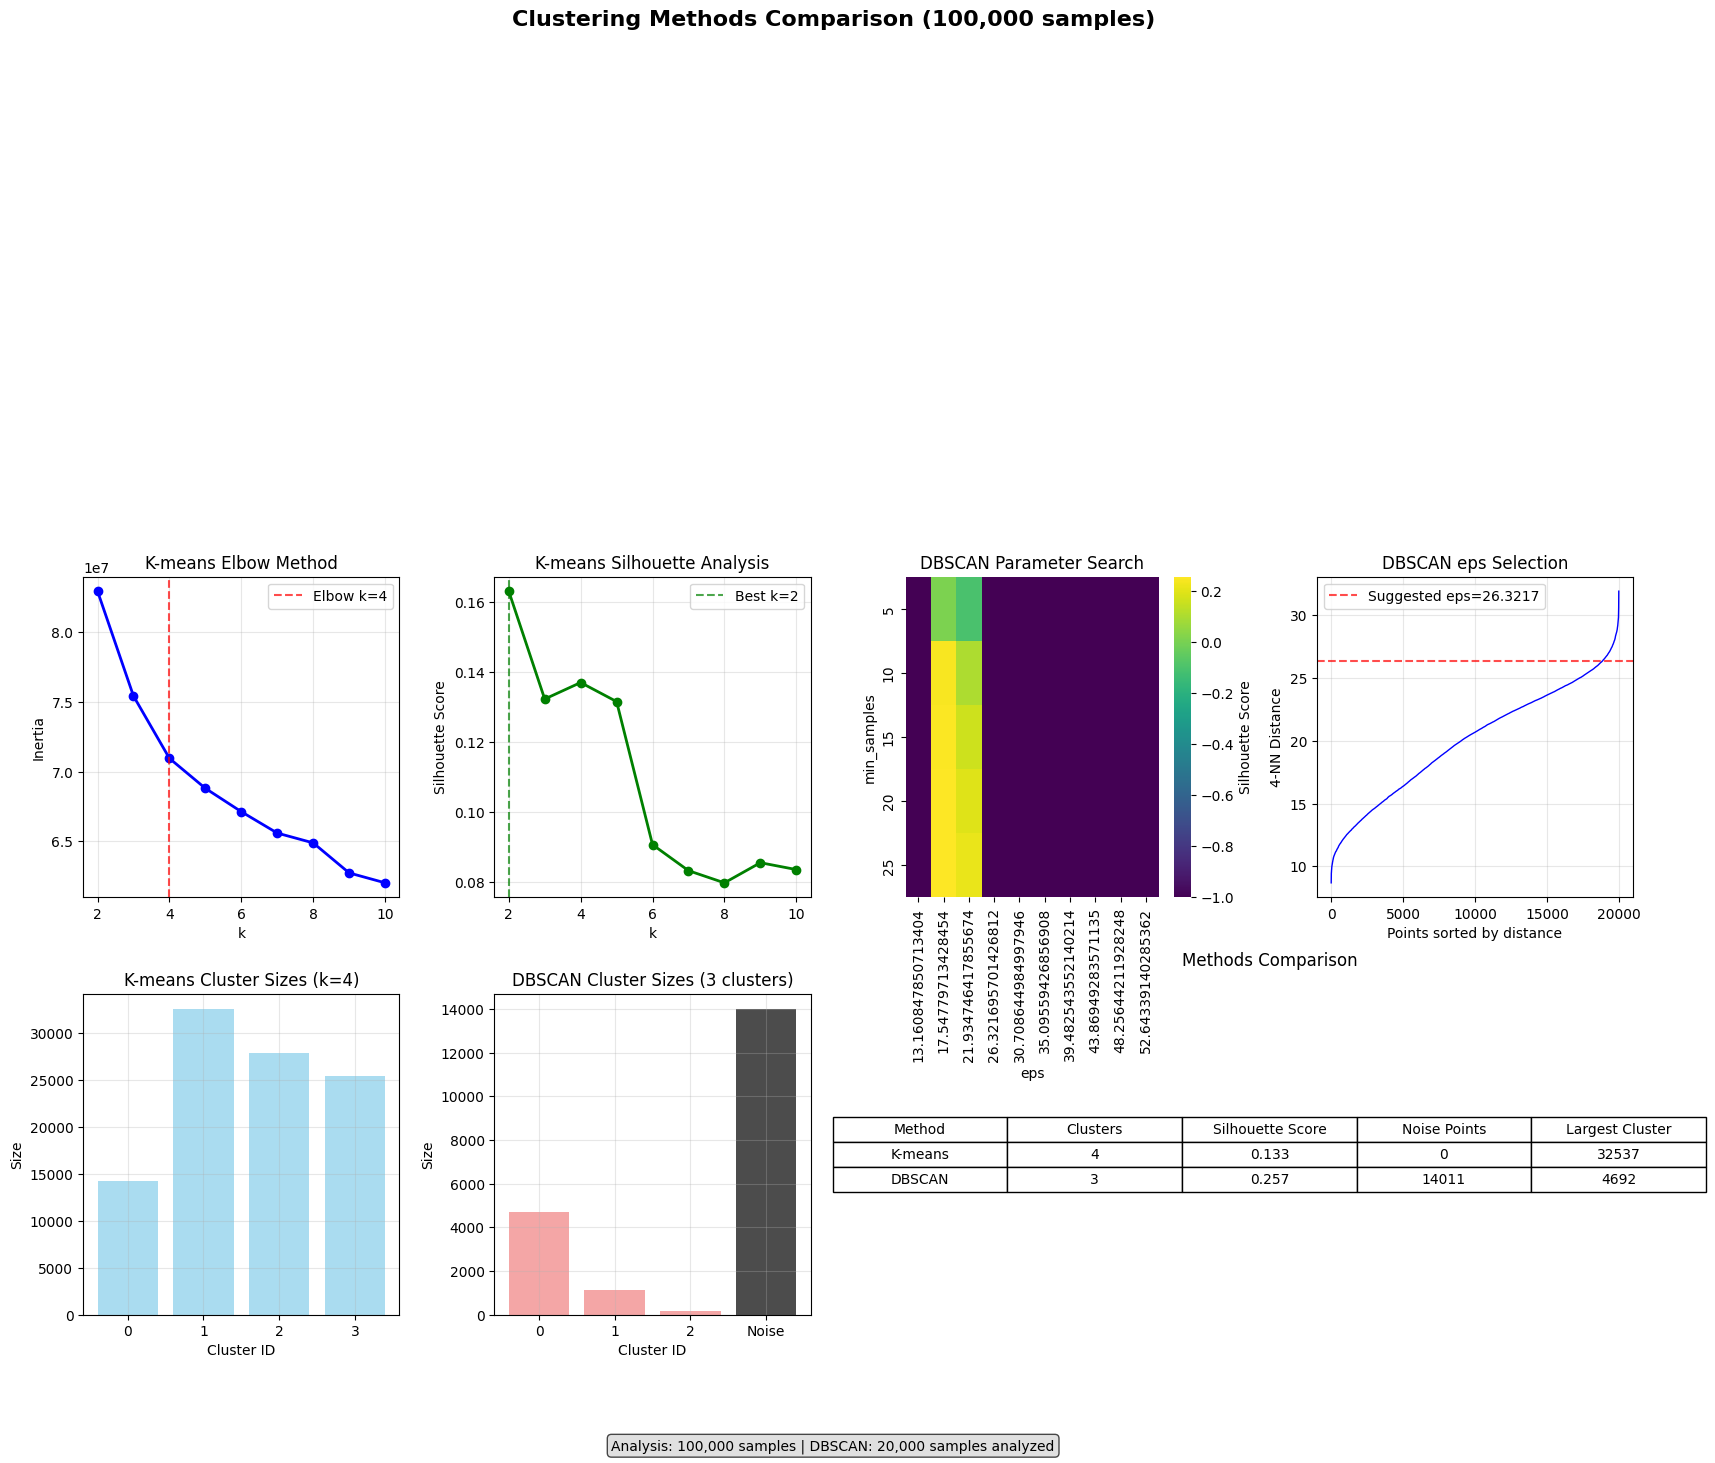

   🏥 Clinical analysis...
🏥 CLINICAL CLUSTERING ANALYSIS
   📊 Analyzing by: ViewPosition

🎯 K-MEANS ANALYSIS (k=4):
   📊 Cluster 0 (14,223 samples):
      AP: 13,924 (97.9%)
      LATERAL: 14 (0.1%)
      LL: 23 (0.2%)
      PA: 81 (0.6%)
      PA LLD: 1 (0.0%)
      nan: 180 (1.3%)
   📊 Cluster 1 (32,537 samples):
      AP: 68 (0.2%)
      LATERAL: 21,631 (66.5%)
      LL: 9,232 (28.4%)
      PA: 202 (0.6%)
      nan: 1,404 (4.3%)
   📊 Cluster 2 (27,858 samples):
      AP: 6,810 (24.4%)
      AP AXIAL: 1 (0.0%)
      LAO: 2 (0.0%)
      LATERAL: 67 (0.2%)
      LL: 20 (0.1%)
      PA: 19,318 (69.3%)
      RAO: 1 (0.0%)
      nan: 1,639 (5.9%)
   📊 Cluster 3 (25,382 samples):
      AP: 18,405 (72.5%)
      AP LLD: 1 (0.0%)
      LATERAL: 99 (0.4%)
      LL: 71 (0.3%)
      PA: 5,878 (23.2%)
      XTABLE LATERAL: 1 (0.0%)
      nan: 927 (3.7%)

🌐 DBSCAN ANALYSIS (20,000 samples analyzed):
   📊 Cluster 0 (4,692 samples):
      AP: 1 (0.0%)
      LATERAL: 3,287 (70.1%)
      LL: 1,163 (24

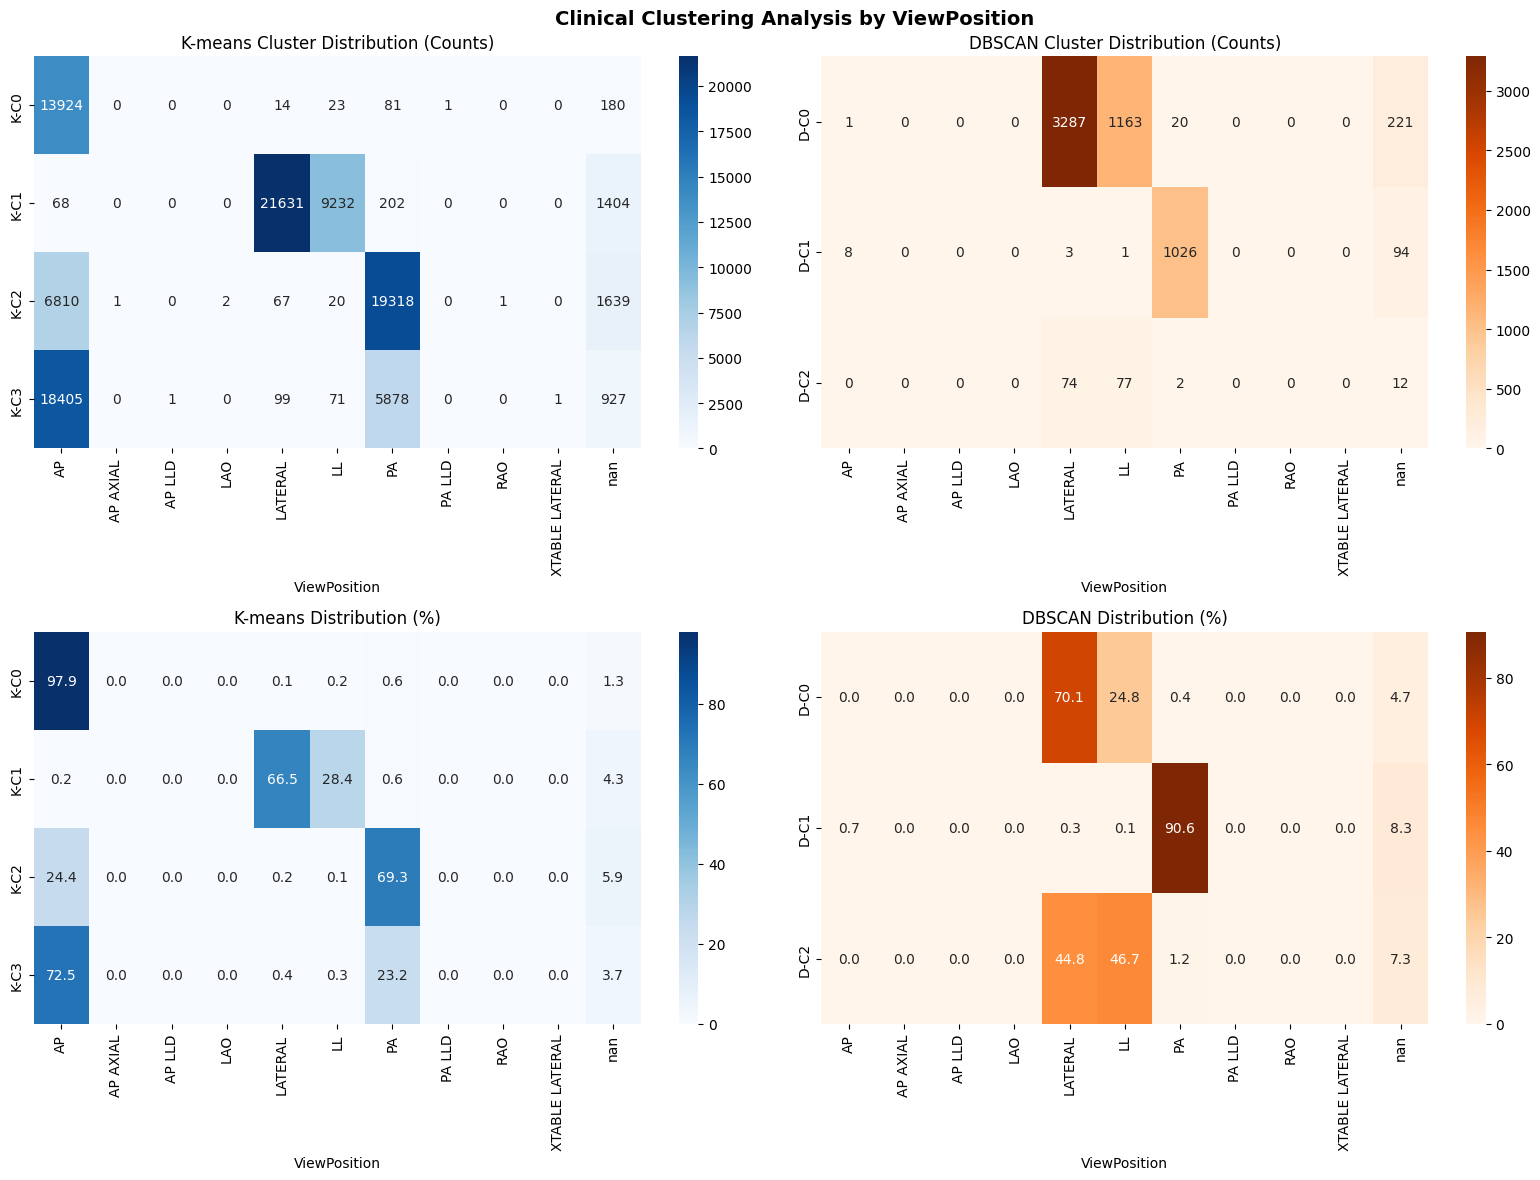


🎯 COMPLETE CLUSTERING ANALYSIS SUMMARY
📊 Dataset: 100,000 samples
⏱️ Total runtime: 1.8 minutes

🎯 K-MEANS RESULTS:
   Optimal k (Elbow): 4
   Optimal k (Silhouette): 2
   Final k used: 4
   Silhouette score: 0.133
   Largest cluster: 32,537 samples

🌐 DBSCAN RESULTS:
   Clusters found: 3
   Noise points: 14,011 (70.1%)
   Silhouette score: 0.257
   Best eps: 17.5478
   Best min_samples: 25
   Largest cluster: 4,692 samples

💡 CLINICAL INSIGHTS:
   ✅ Both methods reveal meaningful clinical patterns
   🏥 K-means provides balanced partitioning
   🔍 DBSCAN identifies 14,011 outlier/anomaly samples
   📊 Ready for clinical validation and interpretation

🎉 COMPLETE CLUSTERING ANALYSIS FINISHED!


In [60]:
# tests everything
analyzer, results = quick_clustering_test()

In [61]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import pickle
import json

class AnalysisResultsSaver:
    def __init__(self, output_dir='analysis_results'):
        """
        Initialize the results saver
        
        Parameters:
        - output_dir: Directory to save all CSV files
        """
        self.output_dir = output_dir
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"📁 Results will be saved to: {output_dir}/")
        print(f"🕐 Timestamp: {self.timestamp}")
    
    def save_pca_results(self, pca_results, embeddings_df, prefix="pca"):
        """Save PCA analysis results to CSV"""
        print(f"💾 Saving PCA results...")
        
        try:
            # 1. PCA Components (2D coordinates)
            if 'reduced_embeddings' in pca_results:
                pca_coords = pca_results['reduced_embeddings']
                
                # Create DataFrame with SOP IDs
                if hasattr(embeddings_df, 'index'):
                    sop_ids = embeddings_df.index.tolist()
                elif 'SOP' in embeddings_df.columns:
                    sop_ids = embeddings_df['SOP'].tolist()
                else:
                    sop_ids = list(range(len(pca_coords)))
                
                # Handle different numbers of components
                n_components = min(pca_coords.shape[1], 20)  # Save up to 20 components
                
                pca_df = pd.DataFrame({
                    'SOP': sop_ids[:len(pca_coords)],
                    **{f'PC{i+1}': pca_coords[:, i] for i in range(n_components)}
                })
                
                filename = f"{self.output_dir}/{prefix}_components_{self.timestamp}.csv"
                pca_df.to_csv(filename, index=False)
                print(f"   ✅ PCA components saved: {filename}")
            
            # 2. PCA Explained Variance
            if 'explained_variance_ratio' in pca_results:
                variance_df = pd.DataFrame({
                    'Component': [f'PC{i+1}' for i in range(len(pca_results['explained_variance_ratio']))],
                    'Explained_Variance_Ratio': pca_results['explained_variance_ratio'],
                    'Cumulative_Variance': pca_results.get('cumulative_variance', np.cumsum(pca_results['explained_variance_ratio'])),
                    'Eigenvalue': pca_results.get('eigenvalues', [0] * len(pca_results['explained_variance_ratio']))
                })
                
                filename = f"{self.output_dir}/{prefix}_explained_variance_{self.timestamp}.csv"
                variance_df.to_csv(filename, index=False)
                print(f"   ✅ PCA variance explained saved: {filename}")
            
            # 3. PCA Summary Statistics
            summary_df = pd.DataFrame({
                'Metric': ['Total_Samples', 'Total_Components', 'PC1_Variance_Pct', 'PC2_Variance_Pct', 'First_2PC_Total_Pct'],
                'Value': [
                    pca_results.get('n_samples', len(pca_coords)) if 'reduced_embeddings' in pca_results else 0,
                    pca_results.get('n_components', pca_coords.shape[1]) if 'reduced_embeddings' in pca_results else 0,
                    pca_results['explained_variance_ratio'][0] * 100 if 'explained_variance_ratio' in pca_results else 0,
                    pca_results['explained_variance_ratio'][1] * 100 if len(pca_results.get('explained_variance_ratio', [])) > 1 else 0,
                    sum(pca_results['explained_variance_ratio'][:2]) * 100 if len(pca_results.get('explained_variance_ratio', [])) > 1 else 0
                ]
            })
            
            filename = f"{self.output_dir}/{prefix}_summary_{self.timestamp}.csv"
            summary_df.to_csv(filename, index=False)
            print(f"   ✅ PCA summary saved: {filename}")
            
            return True
            
        except Exception as e:
            print(f"   ❌ Error saving PCA results: {e}")
            return False
    
    def save_tsne_results(self, tsne_results, embeddings_df, prefix="tsne"):
        """Save t-SNE analysis results to CSV"""
        print(f"💾 Saving t-SNE results...")
        
        try:
            # 1. t-SNE Coordinates
            if 'reduced_embeddings' in tsne_results:
                tsne_coords = tsne_results['reduced_embeddings']
                
                # Handle sample indices if t-SNE was run on subset
                if 'sample_indices' in tsne_results:
                    # t-SNE was run on a sample
                    sample_indices = tsne_results['sample_indices']
                    if hasattr(embeddings_df, 'index'):
                        all_sops = embeddings_df.index.tolist()
                        sample_sops = [all_sops[i] for i in sample_indices]
                    else:
                        sample_sops = [f"sample_{i}" for i in sample_indices]
                    
                    # Create full dataset with NaN for non-analyzed samples
                    if hasattr(embeddings_df, 'index'):
                        all_sops = embeddings_df.index.tolist()
                    elif 'SOP' in embeddings_df.columns:
                        all_sops = embeddings_df['SOP'].tolist()
                    else:
                        all_sops = list(range(len(embeddings_df)))
                    
                    tsne_df = pd.DataFrame({
                        'SOP': all_sops,
                        'tSNE_1': np.nan,
                        'tSNE_2': np.nan,
                        'Analyzed': False
                    })
                    
                    # Fill in analyzed samples
                    for i, sop in enumerate(sample_sops):
                        idx = all_sops.index(sop) if sop in all_sops else None
                        if idx is not None:
                            tsne_df.loc[idx, 'tSNE_1'] = tsne_coords[i, 0]
                            tsne_df.loc[idx, 'tSNE_2'] = tsne_coords[i, 1]
                            tsne_df.loc[idx, 'Analyzed'] = True
                
                elif 'sample_sops' in tsne_results:
                    # t-SNE results with explicit SOP list
                    sample_sops = tsne_results['sample_sops']
                    tsne_df = pd.DataFrame({
                        'SOP': sample_sops,
                        'tSNE_1': tsne_coords[:, 0],
                        'tSNE_2': tsne_coords[:, 1],
                        'Analyzed': True
                    })
                    
                else:
                    # t-SNE on full dataset
                    if hasattr(embeddings_df, 'index'):
                        sop_ids = embeddings_df.index.tolist()
                    elif 'SOP' in embeddings_df.columns:
                        sop_ids = embeddings_df['SOP'].tolist()
                    else:
                        sop_ids = list(range(len(tsne_coords)))
                    
                    tsne_df = pd.DataFrame({
                        'SOP': sop_ids[:len(tsne_coords)],
                        'tSNE_1': tsne_coords[:, 0],
                        'tSNE_2': tsne_coords[:, 1],
                        'Analyzed': True
                    })
                
                filename = f"{self.output_dir}/{prefix}_coordinates_{self.timestamp}.csv"
                tsne_df.to_csv(filename, index=False)
                print(f"   ✅ t-SNE coordinates saved: {filename}")
            
            # 2. t-SNE Parameters and Summary
            summary_df = pd.DataFrame({
                'Parameter': ['Perplexity', 'Max_Iterations', 'Samples_Analyzed', 'Runtime_Minutes'],
                'Value': [
                    tsne_results.get('perplexity', 'Unknown'),
                    tsne_results.get('max_iter', tsne_results.get('n_iter', 'Unknown')),
                    tsne_results.get('n_samples', len(tsne_coords)) if 'reduced_embeddings' in tsne_results else 0,
                    tsne_results.get('runtime_minutes', 'Unknown')
                ]
            })
            
            filename = f"{self.output_dir}/{prefix}_parameters_{self.timestamp}.csv"
            summary_df.to_csv(filename, index=False)
            print(f"   ✅ t-SNE parameters saved: {filename}")
            
            return True
            
        except Exception as e:
            print(f"   ❌ Error saving t-SNE results: {e}")
            return False
    
    def save_kmeans_results(self, kmeans_results, embeddings_df, prefix="kmeans"):
        """Save K-means analysis results to CSV"""
        print(f"💾 Saving K-means results...")
        
        try:
            # 1. Cluster Assignments
            if 'final_kmeans' in kmeans_results:
                final_results = kmeans_results['final_kmeans']
                labels = final_results['labels']
                
                # Get SOP IDs
                if hasattr(embeddings_df, 'index'):
                    sop_ids = embeddings_df.index.tolist()
                elif 'SOP' in embeddings_df.columns:
                    sop_ids = embeddings_df['SOP'].tolist()
                else:
                    sop_ids = list(range(len(labels)))
                
                cluster_df = pd.DataFrame({
                    'SOP': sop_ids[:len(labels)],
                    'Cluster_ID': labels,
                    'Method': 'K-means'
                })
                
                filename = f"{self.output_dir}/{prefix}_clusters_{self.timestamp}.csv"
                cluster_df.to_csv(filename, index=False)
                print(f"   ✅ K-means cluster assignments saved: {filename}")
                
                # 2. Cluster Centers (if available)
                if 'cluster_centers' in final_results:
                    centers = final_results['cluster_centers']
                    centers_df = pd.DataFrame({
                        'Cluster_ID': range(len(centers)),
                        **{f'Feature_{i}': centers[:, i] for i in range(centers.shape[1])}
                    })
                    
                    filename = f"{self.output_dir}/{prefix}_centers_{self.timestamp}.csv"
                    centers_df.to_csv(filename, index=False)
                    print(f"   ✅ K-means cluster centers saved: {filename}")
                
                # 3. Cluster Statistics
                unique_labels, counts = np.unique(labels, return_counts=True)
                cluster_stats_df = pd.DataFrame({
                    'Cluster_ID': unique_labels,
                    'Size': counts,
                    'Percentage': counts / len(labels) * 100
                })
                
                filename = f"{self.output_dir}/{prefix}_cluster_stats_{self.timestamp}.csv"
                cluster_stats_df.to_csv(filename, index=False)
                print(f"   ✅ K-means cluster statistics saved: {filename}")
            
            # 4. Elbow Analysis Results
            if 'kmeans_elbow' in kmeans_results:
                elbow_data = kmeans_results['kmeans_elbow']
                
                elbow_df = pd.DataFrame({
                    'k': elbow_data['k_values'],
                    'Inertia': elbow_data['inertias'],
                    'Silhouette_Score': elbow_data['silhouette_scores']
                })
                
                filename = f"{self.output_dir}/{prefix}_elbow_analysis_{self.timestamp}.csv"
                elbow_df.to_csv(filename, index=False)
                print(f"   ✅ K-means elbow analysis saved: {filename}")
                
                # Elbow summary
                elbow_summary_df = pd.DataFrame({
                    'Metric': ['Optimal_k_Elbow', 'Optimal_k_Silhouette', 'Max_Silhouette_Score', 'Final_k_Used', 'Final_Silhouette'],
                    'Value': [
                        elbow_data.get('optimal_k_elbow', 'Unknown'),
                        elbow_data.get('optimal_k_silhouette', 'Unknown'),
                        elbow_data.get('max_silhouette_score', 'Unknown'),
                        final_results.get('k', 'Unknown') if 'final_kmeans' in kmeans_results else 'Unknown',
                        final_results.get('silhouette_score', 'Unknown') if 'final_kmeans' in kmeans_results else 'Unknown'
                    ]
                })
                
                filename = f"{self.output_dir}/{prefix}_summary_{self.timestamp}.csv"
                elbow_summary_df.to_csv(filename, index=False)
                print(f"   ✅ K-means summary saved: {filename}")
            
            return True
            
        except Exception as e:
            print(f"   ❌ Error saving K-means results: {e}")
            return False
    
    def save_dbscan_results(self, dbscan_results, embeddings_df, prefix="dbscan"):
        """Save DBSCAN analysis results to CSV"""
        print(f"💾 Saving DBSCAN results...")
        
        try:
            # 1. Cluster Assignments
            if 'final_dbscan' in dbscan_results:
                final_results = dbscan_results['final_dbscan']
                labels = final_results['labels']
                
                # Handle DBSCAN sampling
                if 'dbscan_indices' in dbscan_results or len(labels) < len(embeddings_df):
                    # DBSCAN was run on a sample
                    if hasattr(embeddings_df, 'index'):
                        all_sops = embeddings_df.index.tolist()
                    elif 'SOP' in embeddings_df.columns:
                        all_sops = embeddings_df['SOP'].tolist()
                    else:
                        all_sops = list(range(len(embeddings_df)))
                    
                    # Create full dataset with -2 for non-analyzed samples
                    cluster_df = pd.DataFrame({
                        'SOP': all_sops,
                        'Cluster_ID': -2,  # -2 = not analyzed, -1 = noise, 0+ = cluster
                        'Method': 'DBSCAN',
                        'Analyzed': False
                    })
                    
                    # Fill in analyzed samples (assuming they're the first N samples)
                    analyzed_indices = list(range(len(labels)))
                    for i in analyzed_indices:
                        cluster_df.loc[i, 'Cluster_ID'] = labels[i]
                        cluster_df.loc[i, 'Analyzed'] = True
                        cluster_df.loc[i, 'Is_Noise'] = (labels[i] == -1)
                        cluster_df.loc[i, 'Is_Core'] = (labels[i] >= 0)
                
                else:
                    # DBSCAN on full dataset
                    if hasattr(embeddings_df, 'index'):
                        sop_ids = embeddings_df.index.tolist()
                    elif 'SOP' in embeddings_df.columns:
                        sop_ids = embeddings_df['SOP'].tolist()
                    else:
                        sop_ids = list(range(len(labels)))
                    
                    cluster_df = pd.DataFrame({
                        'SOP': sop_ids[:len(labels)],
                        'Cluster_ID': labels,
                        'Method': 'DBSCAN',
                        'Analyzed': True,
                        'Is_Noise': labels == -1,
                        'Is_Core': labels >= 0
                    })
                
                filename = f"{self.output_dir}/{prefix}_clusters_{self.timestamp}.csv"
                cluster_df.to_csv(filename, index=False)
                print(f"   ✅ DBSCAN cluster assignments saved: {filename}")
                
                # 2. Cluster Statistics (excluding noise)
                cluster_labels = labels[labels >= 0]
                if len(cluster_labels) > 0:
                    unique_labels, counts = np.unique(cluster_labels, return_counts=True)
                    
                    cluster_stats_df = pd.DataFrame({
                        'Cluster_ID': unique_labels,
                        'Size': counts,
                        'Percentage_of_Analyzed': counts / len(labels) * 100,
                        'Percentage_of_Clusters': counts / len(cluster_labels) * 100
                    })
                    
                    # Add noise statistics
                    n_noise = np.sum(labels == -1)
                    noise_row = pd.DataFrame({
                        'Cluster_ID': [-1],
                        'Size': [n_noise],
                        'Percentage_of_Analyzed': [n_noise / len(labels) * 100],
                        'Percentage_of_Clusters': [0.0]  # Noise not counted in cluster percentage
                    })
                    
                    cluster_stats_df = pd.concat([cluster_stats_df, noise_row], ignore_index=True)
                    
                    filename = f"{self.output_dir}/{prefix}_cluster_stats_{self.timestamp}.csv"
                    cluster_stats_df.to_csv(filename, index=False)
                    print(f"   ✅ DBSCAN cluster statistics saved: {filename}")
                
                # 3. DBSCAN Parameters and Summary
                summary_df = pd.DataFrame({
                    'Parameter': ['eps', 'min_samples', 'n_clusters', 'n_noise', 'noise_ratio_pct', 'silhouette_score', 'samples_analyzed'],
                    'Value': [
                        final_results.get('eps', 'Unknown'),
                        final_results.get('min_samples', 'Unknown'),
                        final_results.get('n_clusters', 'Unknown'),
                        final_results.get('n_noise', 'Unknown'),
                        final_results.get('noise_ratio', 0) * 100,
                        final_results.get('silhouette_score', 'Unknown'),
                        len(labels)
                    ]
                })
                
                filename = f"{self.output_dir}/{prefix}_summary_{self.timestamp}.csv"
                summary_df.to_csv(filename, index=False)
                print(f"   ✅ DBSCAN summary saved: {filename}")
            
            # 4. Parameter Search Results (if available)
            if 'dbscan_grid_search' in dbscan_results:
                grid_data = dbscan_results['dbscan_grid_search']
                
                if 'results' in grid_data:
                    param_search_df = pd.DataFrame(grid_data['results'])
                    
                    filename = f"{self.output_dir}/{prefix}_parameter_search_{self.timestamp}.csv"
                    param_search_df.to_csv(filename, index=False)
                    print(f"   ✅ DBSCAN parameter search saved: {filename}")
            
            return True
            
        except Exception as e:
            print(f"   ❌ Error saving DBSCAN results: {e}")
            return False
    
    def save_combined_results(self, all_results, embeddings_df, metadata_df=None):
        """Save combined results from all methods in one comprehensive file"""
        print(f"💾 Saving combined results...")
        
        try:
            # Start with SOP IDs
            if hasattr(embeddings_df, 'index'):
                sop_ids = embeddings_df.index.tolist()
            elif 'SOP' in embeddings_df.columns:
                sop_ids = embeddings_df['SOP'].tolist()
            else:
                sop_ids = list(range(len(embeddings_df)))
            
            combined_df = pd.DataFrame({'SOP': sop_ids})
            
            # Add PCA results
            if 'pca' in all_results and 'reduced_embeddings' in all_results['pca']:
                pca_coords = all_results['pca']['reduced_embeddings']
                n_components = min(pca_coords.shape[1], 10)  # First 10 components
                
                for i in range(n_components):
                    combined_df[f'PC{i+1}'] = pca_coords[:len(sop_ids), i] if len(pca_coords) >= len(sop_ids) else np.nan
            
            # Add t-SNE results
            if 'tsne' in all_results and 'reduced_embeddings' in all_results['tsne']:
                tsne_coords = all_results['tsne']['reduced_embeddings']
                
                # Handle t-SNE sampling
                if 'sample_indices' in all_results['tsne']:
                    sample_indices = all_results['tsne']['sample_indices']
                    combined_df['tSNE_1'] = np.nan
                    combined_df['tSNE_2'] = np.nan
                    
                    for i, idx in enumerate(sample_indices):
                        if idx < len(combined_df):
                            combined_df.loc[idx, 'tSNE_1'] = tsne_coords[i, 0]
                            combined_df.loc[idx, 'tSNE_2'] = tsne_coords[i, 1]
                else:
                    combined_df['tSNE_1'] = tsne_coords[:len(sop_ids), 0] if len(tsne_coords) >= len(sop_ids) else np.nan
                    combined_df['tSNE_2'] = tsne_coords[:len(sop_ids), 1] if len(tsne_coords) >= len(sop_ids) else np.nan
            
            # Add K-means results
            if 'kmeans' in all_results and 'final_kmeans' in all_results['kmeans']:
                labels = all_results['kmeans']['final_kmeans']['labels']
                combined_df['KMeans_Cluster'] = labels[:len(sop_ids)] if len(labels) >= len(sop_ids) else np.nan
            
            # Add DBSCAN results
            if 'dbscan' in all_results and 'final_dbscan' in all_results['dbscan']:
                dbscan_labels = all_results['dbscan']['final_dbscan']['labels']
                
                combined_df['DBSCAN_Cluster'] = -2  # Default: not analyzed
                
                # Handle DBSCAN sampling
                analyzed_count = len(dbscan_labels)
                for i in range(min(analyzed_count, len(combined_df))):
                    combined_df.loc[i, 'DBSCAN_Cluster'] = dbscan_labels[i]
                
                combined_df['DBSCAN_Is_Noise'] = combined_df['DBSCAN_Cluster'] == -1
                combined_df['DBSCAN_Analyzed'] = combined_df['DBSCAN_Cluster'] != -2
            
            # Add metadata if available
            if metadata_df is not None:
                # Common metadata columns to include
                metadata_cols = ['ViewPosition', 'PatientAge', 'PatientSex', 'StudyDate', 'Modality']
                
                for col in metadata_cols:
                    if col in metadata_df.columns:
                        # Match by SOP/dicom_id
                        id_column = 'dicom_id' if 'dicom_id' in metadata_df.columns else 'SOP'
                        
                        if id_column in metadata_df.columns:
                            # Create mapping
                            metadata_map = dict(zip(metadata_df[id_column], metadata_df[col]))
                            combined_df[col] = combined_df['SOP'].map(metadata_map)
            
            filename = f"{self.output_dir}/combined_analysis_results_{self.timestamp}.csv"
            combined_df.to_csv(filename, index=False)
            print(f"   ✅ Combined results saved: {filename}")
            
            # Create data dictionary
            data_dict = {
                'Column': list(combined_df.columns),
                'Description': [
                    'Sample/Image identifier',
                    *[f'Principal Component {i+1}' for i in range(sum(1 for col in combined_df.columns if col.startswith('PC')))],
                    *(['t-SNE Component 1', 't-SNE Component 2'] if any(col.startswith('tSNE') for col in combined_df.columns) else []),
                    *(['K-means cluster assignment'] if 'KMeans_Cluster' in combined_df.columns else []),
                    *(['DBSCAN cluster assignment (-1=noise, -2=not analyzed)'] if 'DBSCAN_Cluster' in combined_df.columns else []),
                    *(['Whether point is classified as noise by DBSCAN'] if 'DBSCAN_Is_Noise' in combined_df.columns else []),
                    *(['Whether point was analyzed by DBSCAN'] if 'DBSCAN_Analyzed' in combined_df.columns else []),
                    *[f'Clinical metadata: {col}' for col in combined_df.columns if col in ['ViewPosition', 'PatientAge', 'PatientSex', 'StudyDate', 'Modality']]
                ]
            }
            
            data_dict_df = pd.DataFrame(data_dict)
            filename = f"{self.output_dir}/data_dictionary_{self.timestamp}.csv"
            data_dict_df.to_csv(filename, index=False)
            print(f"   ✅ Data dictionary saved: {filename}")
            
            return True
            
        except Exception as e:
            print(f"   ❌ Error saving combined results: {e}")
            return False
    
    def save_analysis_metadata(self, all_results, total_runtime_minutes=None):
        """Save analysis metadata and parameters"""
        print(f"💾 Saving analysis metadata...")
        
        try:
            metadata = {
                'Analysis_Timestamp': self.timestamp,
                'Analysis_Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'Total_Runtime_Minutes': total_runtime_minutes or 'Unknown'
            }
            
            # Add method-specific metadata
            if 'pca' in all_results:
                pca_data = all_results['pca']
                metadata.update({
                    'PCA_Components': pca_data.get('n_components', 'Unknown'),
                    'PCA_Samples': pca_data.get('n_samples', 'Unknown'),
                    'PCA_Variance_PC1': pca_data.get('explained_variance_ratio', [0])[0] if pca_data.get('explained_variance_ratio') else 0,
                    'PCA_Variance_PC2': pca_data.get('explained_variance_ratio', [0, 0])[1] if len(pca_data.get('explained_variance_ratio', [])) > 1 else 0
                })
            
            if 'tsne' in all_results:
                tsne_data = all_results['tsne']
                metadata.update({
                    'tSNE_Perplexity': tsne_data.get('perplexity', 'Unknown'),
                    'tSNE_Iterations': tsne_data.get('max_iter', tsne_data.get('n_iter', 'Unknown')),
                    'tSNE_Samples': tsne_data.get('n_samples', 'Unknown'),
                    'tSNE_Runtime_Minutes': tsne_data.get('runtime_minutes', 'Unknown')
                })
            
            if 'kmeans' in all_results:
                if 'final_kmeans' in all_results['kmeans']:
                    kmeans_data = all_results['kmeans']['final_kmeans']
                    metadata.update({
                        'KMeans_Final_K': kmeans_data.get('k', 'Unknown'),
                        'KMeans_Silhouette': kmeans_data.get('silhouette_score', 'Unknown'),
                        'KMeans_Inertia': kmeans_data.get('inertia', 'Unknown')
                    })
                
                if 'kmeans_elbow' in all_results['kmeans']:
                    elbow_data = all_results['kmeans']['kmeans_elbow']
                    metadata.update({
                        'KMeans_Optimal_K_Elbow': elbow_data.get('optimal_k_elbow', 'Unknown'),
                        'KMeans_Optimal_K_Silhouette': elbow_data.get('optimal_k_silhouette', 'Unknown')
                    })
            
            if 'dbscan' in all_results and 'final_dbscan' in all_results['dbscan']:
                dbscan_data = all_results['dbscan']['final_dbscan']
                metadata.update({
                    'DBSCAN_eps': dbscan_data.get('eps', 'Unknown'),
                    'DBSCAN_min_samples': dbscan_data.get('min_samples', 'Unknown'),
                    'DBSCAN_Clusters': dbscan_data.get('n_clusters', 'Unknown'),
                    'DBSCAN_Noise_Points': dbscan_data.get('n_noise', 'Unknown'),
                    'DBSCAN_Noise_Ratio': dbscan_data.get('noise_ratio', 'Unknown'),
                    'DBSCAN_Silhouette': dbscan_data.get('silhouette_score', 'Unknown')
                })
            
            # Convert to DataFrame and save
            metadata_df = pd.DataFrame({
                'Parameter': list(metadata.keys()),
                'Value': list(metadata.values())
            })
            
            filename = f"{self.output_dir}/analysis_metadata_{self.timestamp}.csv"
            metadata_df.to_csv(filename, index=False)
            print(f"   ✅ Analysis metadata saved: {filename}")
            
            # Also save as JSON for easy loading
            filename_json = f"{self.output_dir}/analysis_metadata_{self.timestamp}.json"
            with open(filename_json, 'w') as f:
                json.dump(metadata, f, indent=2, default=str)
            print(f"   ✅ Analysis metadata (JSON) saved: {filename_json}")
            
            return True
            
        except Exception as e:
            print(f"   ❌ Error saving metadata: {e}")
            return False
    
    def save_all_results(self, all_results, embeddings_df, metadata_df=None, total_runtime_minutes=None):
        """Save all analysis results in one go"""
        print(f"\n💾 SAVING ALL ANALYSIS RESULTS")
        print(f"=" * 50)
        
        saved_files = []
        
        # Save individual method results
        if 'pca' in all_results:
            success = self.save_pca_results(all_results['pca'], embeddings_df)
            if success:
                saved_files.append('PCA results')
        
        if 'tsne' in all_results:
            success = self.save_tsne_results(all_results['tsne'], embeddings_df)
            if success:
                saved_files.append('t-SNE results')
        
        if 'kmeans' in all_results:
            success = self.save_kmeans_results(all_results['kmeans'], embeddings_df)
            if success:
                saved_files.append('K-means results')
        
        if 'dbscan' in all_results:
            success = self.save_dbscan_results(all_results['dbscan'], embeddings_df)
            if success:
                saved_files.append('DBSCAN results')
        
        # Save combined results
        success = self.save_combined_results(all_results, embeddings_df, metadata_df)
        if success:
            saved_files.append('Combined results')
        
        # Save metadata
        success = self.save_analysis_metadata(all_results, total_runtime_minutes)
        if success:
            saved_files.append('Analysis metadata')
        
        print(f"\n✅ SAVE COMPLETE!")
        print(f"📁 Output directory: {self.output_dir}/")
        print(f"📄 Files saved: {len(saved_files)}")
        for file_type in saved_files:
            print(f"   ✓ {file_type}")
        
        # List all files created
        import glob
        all_files = glob.glob(f"{self.output_dir}/*{self.timestamp}*")
        print(f"\n📋 All files created ({len(all_files)} files):")
        for file_path in sorted(all_files):
            filename = os.path.basename(file_path)
            size_mb = os.path.getsize(file_path) / (1024*1024)
            print(f"   📄 {filename} ({size_mb:.2f} MB)")
        
        return True

# =============================================================================
# USAGE FUNCTIONS
# =============================================================================

def save_analysis_results(analyzer_results, embeddings_df, metadata_df=None, output_dir='analysis_results'):
    """
    Main function to save all analysis results
    
    Parameters:
    - analyzer_results: Dictionary containing all analysis results
    - embeddings_df: Original embeddings DataFrame
    - metadata_df: Optional metadata DataFrame
    - output_dir: Directory to save results
    
    Usage:
    save_analysis_results(all_results, df, meta)
    """
    
    saver = AnalysisResultsSaver(output_dir=output_dir)
    
    # Extract total runtime if available
    total_runtime = analyzer_results.get('total_runtime_minutes', None)
    
    return saver.save_all_results(
        all_results=analyzer_results,
        embeddings_df=embeddings_df,
        metadata_df=metadata_df,
        total_runtime_minutes=total_runtime
    )

def quick_save(results_dict, df, meta=None):
    """Quick save function with default settings"""
    return save_analysis_results(results_dict, df, meta, 'analysis_results')

# =============================================================================
# EXAMPLE USAGE
# =============================================================================

def example_usage():
    """
    Example of how to use the results saver
    """
    
    print("""
📋 EXAMPLE USAGE:

# After running your complete analysis:
analyzer, results = run_full_clustering_analysis()

# Save all results to CSV:
save_success = save_analysis_results(
    analyzer_results=results,
    embeddings_df=df,
    metadata_df=meta,
    output_dir='my_analysis_results'
)

# Or use the quick save:
save_success = quick_save(results, df, meta)

📁 This will create files like:
   - pca_components_20231215_143022.csv
   - tsne_coordinates_20231215_143022.csv
   - kmeans_clusters_20231215_143022.csv
   - dbscan_clusters_20231215_143022.csv
   - combined_analysis_results_20231215_143022.csv
   - analysis_metadata_20231215_143022.csv
   - data_dictionary_20231215_143022.csv

✅ All ready for further analysis, visualization, or sharing!
""")

if __name__ == "__main__":
    example_usage()


📋 EXAMPLE USAGE:

# After running your complete analysis:
analyzer, results = run_full_clustering_analysis()

# Save all results to CSV:
save_success = save_analysis_results(
    analyzer_results=results,
    embeddings_df=df,
    metadata_df=meta,
    output_dir='my_analysis_results'
)

# Or use the quick save:
save_success = quick_save(results, df, meta)

📁 This will create files like:
   - pca_components_20231215_143022.csv
   - tsne_coordinates_20231215_143022.csv
   - kmeans_clusters_20231215_143022.csv
   - dbscan_clusters_20231215_143022.csv
   - combined_analysis_results_20231215_143022.csv
   - analysis_metadata_20231215_143022.csv
   - data_dictionary_20231215_143022.csv

✅ All ready for further analysis, visualization, or sharing!



### Using the CXR

In [99]:
from dask import dataframe as dd
# Loading 100k embeddings from CRX dataset, using MedGem embeddings
em_df = pd.read_csv('/home/jupyter-meghana/shared/EmoryCRX_MedGem_100k.csv')

In [100]:
em_df.head()

SOP         0         1  \
0  1.2.826.0.1.3680043.8.498.10344626709499962755... -0.030615  0.051855   
1  1.2.826.0.1.3680043.8.498.71646708503015599301... -0.028930  0.006122   
2  1.2.826.0.1.3680043.8.498.47055055200928502939... -0.011666  0.020361   
3  1.2.826.0.1.3680043.8.498.92970073572879164232... -0.041692  0.036812   
4  1.2.826.0.1.3680043.8.498.10659102174792373469... -0.020133  0.032111   

          2         3         4         5         6         7         8  ...  \
0 -0.032316 -0.019082 -0.002786  0.005983  0.027477  0.016934  0.028652  ...   
1 -0.001773  0.005491  0.001622  0.046472 -0.012705 -0.031327  0.017434  ...   
2  0.005781 -0.014763 -0.023478  0.022479  0.021475 -0.028995 -0.000052  ...   
3 -0.007355  0.032265 -0.038885  0.033058  0.026449 -0.003760  0.070020  ...   
4 -0.007841  0.003966 -0.031938  0.006037 -0.005875 -0.037241  0.017904  ...   

   Lung Opacity  Edema  Consolidation  Pneumonia  Atelectasis  Pneumothorax  \
0           0.0    0.0            1.0        0.0          0.0           0.0   
1           0.0    0.0            0.0        0.0          0.0           0.0   
2           0.0    0.0            0.0        0.0          0.0           0.0   
3           0.0    0.0            0.0        0.0          1.0           0.0   
4           0.0    0.0            0.0        0.0          0.0           0.0   

   Pleural Effusion  Pleural Other  Fracture  Support Devices  
0               1.0            0.0       0.0              0.0  
1               0.0            0.0       0.0              0.0  
2               0.0            0.0       0.0              0.0  
3               1.0            0.0       0.0              0.0  
4               0.0            0.0       0.0              0.0  

[5 rows x 1168 columns]

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

class SampleClusteringAnalyzer:
    def __init__(self, embeddings_df, metadata_df=None, sop_column='SOP', max_sample_size=25000):
        """
        Sample-based clustering analyzer optimized for development and testing
        Always works with manageable sample sizes for efficient iteration
        
        Parameters:
        - embeddings_df: DataFrame with embeddings
        - metadata_df: Optional clinical metadata
        - sop_column: Column name for sample IDs
        - max_sample_size: Maximum samples to use (default: 25K)
        """
        self.embeddings_df = embeddings_df
        self.metadata_df = metadata_df
        self.sop_column = sop_column
        self.max_sample_size = max_sample_size
        
        # Extract embedding data
        if sop_column in embeddings_df.columns:
            self.embedding_columns = [col for col in embeddings_df.columns if col != sop_column]
        else:
            self.embedding_columns = list(embeddings_df.columns)
        
        # Sample data if needed
        if len(embeddings_df) > max_sample_size:
            print(f"📊 Sampling {max_sample_size:,} from {len(embeddings_df):,} total samples")
            sample_indices = np.random.choice(len(embeddings_df), max_sample_size, replace=False)
            self.embeddings_df_sample = embeddings_df.iloc[sample_indices].copy()
            self.sample_indices = sample_indices
            self.is_sampled = True
        else:
            print(f"📊 Using full dataset: {len(embeddings_df):,} samples")
            self.embeddings_df_sample = embeddings_df.copy()
            self.sample_indices = np.arange(len(embeddings_df))
            self.is_sampled = False
        
        self.embeddings_array = self.embeddings_df_sample[self.embedding_columns].values
        self.sop_ids = (self.embeddings_df_sample.index if sop_column not in self.embeddings_df_sample.columns 
                       else self.embeddings_df_sample[sop_column].values)
        
        # Results storage
        self.clustering_results = {}
        self.embeddings_for_clustering = None
        self.scaler = None
        
        print(f"🎯 Sample Clustering Analyzer Initialized!")
        print(f"📊 Analysis samples: {len(self.embeddings_array):,}")
        print(f"🧬 Embedding dimensions: {len(self.embedding_columns)}")
        print(f"🔧 Methods: K-means + DBSCAN (sample-optimized)")
    
    def prepare_clustering_data(self, use_pca_reduction=True, n_pca_components=30):
        """Prepare and standardize data for clustering (sample-optimized)"""
        print("📐 PREPARING DATA FOR CLUSTERING")
        print("=" * 40)
        
        start_time = time.time()
        
        # Standardize embeddings
        print("   🔧 Standardizing embeddings...")
        self.scaler = StandardScaler()
        embeddings_scaled = self.scaler.fit_transform(self.embeddings_array)
        
        # PCA reduction (always recommended for sample analysis)
        if use_pca_reduction and len(self.embedding_columns) > n_pca_components:
            print(f"   📉 Applying PCA: {len(self.embedding_columns)} → {n_pca_components} dimensions")
            
            pca = PCA(n_components=n_pca_components)
            embeddings_reduced = pca.fit_transform(embeddings_scaled)
            
            variance_retained = pca.explained_variance_ratio_.sum()
            print(f"   📊 PCA retained {variance_retained*100:.1f}% of variance")
            
            self.pca_model = pca
            self.embeddings_for_clustering = embeddings_reduced
        else:
            print("   ℹ️  Using original dimensions")
            self.embeddings_for_clustering = embeddings_scaled
            self.pca_model = None
        
        end_time = time.time()
        
        print(f"✅ Data preparation complete ({end_time - start_time:.1f} seconds)")
        print(f"   📊 Clustering data shape: {self.embeddings_for_clustering.shape}")
        
        return self.embeddings_for_clustering
    
    def perform_kmeans_elbow_analysis(self, k_range=range(2, 11), use_minibatch=True):
        """K-means elbow analysis (sample-optimized)"""
        print(f"📈 K-MEANS ELBOW METHOD ANALYSIS")
        print("=" * 45)
        print(f"   🎯 Testing k values: {k_range.start} to {k_range.stop-1}")
        print(f"   📊 Dataset: {len(self.embeddings_for_clustering):,} samples")
        print(f"   🔧 Method: {'MiniBatchKMeans' if use_minibatch else 'KMeans'}")
        
        inertias = []
        silhouette_scores = []
        k_values = list(k_range)
        
        start_time = time.time()
        
        for k in k_values:
            print(f"   🔄 Testing k={k}...")
            
            # Choose K-means variant (MiniBatch for efficiency)
            if use_minibatch and len(self.embeddings_for_clustering) > 1000:
                kmeans = MiniBatchKMeans(
                    n_clusters=k, random_state=42, batch_size=500,
                    n_init=10, max_iter=100
                )
            else:
                kmeans = KMeans(
                    n_clusters=k, random_state=42, n_init=10, max_iter=100
                )
            
            # Fit and predict
            labels = kmeans.fit_predict(self.embeddings_for_clustering)
            inertia = kmeans.inertia_
            inertias.append(inertia)
            
            # Silhouette score (full dataset for samples)
            silhouette_avg = silhouette_score(self.embeddings_for_clustering, labels)
            silhouette_scores.append(silhouette_avg)
            print(f"      Inertia: {inertia:.2f}, Silhouette: {silhouette_avg:.3f}")
        
        end_time = time.time()
        
        # Find optimal k
        optimal_k_elbow = self._find_elbow_point(k_values, inertias)
        optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
        
        # Store results
        self.clustering_results['kmeans_elbow'] = {
            'k_values': k_values,
            'inertias': inertias,
            'silhouette_scores': silhouette_scores,
            'optimal_k_elbow': optimal_k_elbow,
            'optimal_k_silhouette': optimal_k_silhouette,
            'max_silhouette_score': max(silhouette_scores),
            'runtime_minutes': (end_time - start_time) / 60,
            'use_minibatch': use_minibatch
        }
        
        print(f"✅ K-MEANS ELBOW ANALYSIS COMPLETE ({(end_time - start_time)/60:.1f} minutes)")
        print(f"   🎯 Optimal k (Elbow): {optimal_k_elbow}")
        print(f"   🎯 Optimal k (Silhouette): {optimal_k_silhouette}")
        print(f"   📈 Max silhouette: {max(silhouette_scores):.3f}")
        
        return self.clustering_results['kmeans_elbow']
    
    def _find_elbow_point(self, k_values, inertias):
        """Find elbow point using distance from line method"""
        k_array = np.array(k_values)
        inertia_array = np.array(inertias)
        
        if len(k_array) < 3:
            return k_values[len(k_values)//2]
        
        # Distance from line method
        line_start = np.array([k_array[0], inertia_array[0]])
        line_end = np.array([k_array[-1], inertia_array[-1]])
        
        distances = []
        for i, k in enumerate(k_array):
            point = np.array([k, inertia_array[i]])
            
            # Distance from point to line
            line_vec = line_end - line_start
            point_vec = point - line_start
            
            line_len = np.linalg.norm(line_vec)
            if line_len > 0:
                line_unitvec = line_vec / line_len
                proj_length = np.dot(point_vec, line_unitvec)
                proj = line_start + proj_length * line_unitvec
                distance = np.linalg.norm(point - proj)
            else:
                distance = 0
            
            distances.append(distance)
        
        # Find point with maximum distance from line
        max_dist_idx = np.argmax(distances)
        elbow_k = k_array[max_dist_idx]
        
        return int(elbow_k)
    
    def fit_optimal_kmeans(self, k=None, use_minibatch=True):
        """Fit K-means with optimal number of clusters"""
        if k is None:
            if 'kmeans_elbow' not in self.clustering_results:
                raise ValueError("Run perform_kmeans_elbow_analysis() first or provide k")
            k = self.clustering_results['kmeans_elbow']['optimal_k_elbow']
        
        print(f"🎯 FITTING OPTIMAL K-MEANS (k={k})")
        print("=" * 35)
        
        start_time = time.time()
        
        # Fit final model
        if use_minibatch and len(self.embeddings_for_clustering) > 1000:
            kmeans = MiniBatchKMeans(
                n_clusters=k, random_state=42, batch_size=500,
                n_init=10, max_iter=100
            )
        else:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=100)
        
        labels = kmeans.fit_predict(self.embeddings_for_clustering)
        
        # Calculate metrics
        inertia = kmeans.inertia_
        silhouette_avg = silhouette_score(self.embeddings_for_clustering, labels)
        
        end_time = time.time()
        
        # Analyze cluster sizes
        unique_labels, counts = np.unique(labels, return_counts=True)
        
        # Store results
        self.clustering_results['final_kmeans'] = {
            'model': kmeans,
            'labels': labels,
            'k': k,
            'inertia': inertia,
            'silhouette_score': silhouette_avg,
            'cluster_centers': kmeans.cluster_centers_,
            'cluster_sizes': counts,
            'runtime_seconds': end_time - start_time
        }
        
        print(f"✅ OPTIMAL K-MEANS COMPLETE ({end_time - start_time:.1f} seconds)")
        print(f"   📊 Clusters: {k}")
        print(f"   📈 Silhouette: {silhouette_avg:.3f}")
        print(f"   📉 Inertia: {inertia:.2f}")
        print(f"   📊 Cluster sizes: {dict(zip(unique_labels, counts))}")
        
        return self.clustering_results['final_kmeans']
    
    def find_optimal_dbscan_eps(self, k_neighbors=4):
        """Find optimal eps parameter for DBSCAN"""
        print(f"🔍 FINDING OPTIMAL DBSCAN EPS PARAMETER")
        print("=" * 45)
        print(f"   📊 Dataset: {len(self.embeddings_for_clustering):,} samples")
        print(f"   🎯 Method: k-distance graph (k={k_neighbors})")
        
        start_time = time.time()
        
        # Calculate k-distance for each point
        print("   📐 Computing k-nearest neighbors...")
        neighbors = NearestNeighbors(n_neighbors=k_neighbors)
        neighbors_fit = neighbors.fit(self.embeddings_for_clustering)
        distances, indices = neighbors_fit.kneighbors(self.embeddings_for_clustering)
        
        # Get k-distances (distance to k-th nearest neighbor)
        k_distances = distances[:, k_neighbors-1]
        k_distances = np.sort(k_distances)
        
        # Find the "elbow" in k-distance plot
        suggested_eps = self._find_eps_elbow(k_distances)
        
        end_time = time.time()
        
        print(f"✅ EPS ANALYSIS COMPLETE ({end_time - start_time:.1f} seconds)")
        print(f"   🎯 Suggested eps: {suggested_eps:.4f}")
        print(f"   📊 k-distances range: {k_distances.min():.4f} to {k_distances.max():.4f}")
        
        # Store results
        self.clustering_results['dbscan_eps_analysis'] = {
            'k_distances': k_distances,
            'suggested_eps': suggested_eps,
            'k_neighbors': k_neighbors,
            'runtime_seconds': end_time - start_time
        }
        
        return suggested_eps, k_distances
    
    def _find_eps_elbow(self, k_distances):
        """Find elbow point in k-distance graph"""
        n_points = len(k_distances)
        x_values = np.arange(n_points)
        
        # Use multiple methods and take median
        methods_results = []
        
        # Method 1: 90th percentile (conservative)
        eps_percentile = np.percentile(k_distances, 90)
        methods_results.append(eps_percentile)
        
        # Method 2: Distance from line method
        if n_points >= 10:
            line_start = np.array([0, k_distances[0]])
            line_end = np.array([n_points-1, k_distances[-1]])
            
            distances = []
            for i in range(n_points):
                point = np.array([i, k_distances[i]])
                
                line_vec = line_end - line_start
                point_vec = point - line_start
                
                line_len = np.linalg.norm(line_vec)
                if line_len > 0:
                    line_unitvec = line_vec / line_len
                    proj_length = np.dot(point_vec, line_unitvec)
                    proj = line_start + proj_length * line_unitvec
                    distance = np.linalg.norm(point - proj)
                else:
                    distance = 0
                
                distances.append(distance)
            
            max_dist_idx = np.argmax(distances)
            eps_distance = k_distances[max_dist_idx]
            methods_results.append(eps_distance)
        
        # Method 3: Gradient-based
        if n_points >= 5:
            gradients = np.gradient(k_distances)
            steep_increase_idx = np.argmax(gradients)
            eps_gradient = k_distances[steep_increase_idx]
            methods_results.append(eps_gradient)
        
        # Return median of methods
        return np.median(methods_results)
    
    def perform_dbscan_parameter_search(self, eps_range=None, min_samples_range=[3, 5, 7, 10]):
        """DBSCAN parameter search (sample-optimized)"""
        print(f"🌐 DBSCAN PARAMETER GRID SEARCH")
        print("=" * 35)
        
        # Use suggested eps if not provided
        if eps_range is None:
            if 'dbscan_eps_analysis' not in self.clustering_results:
                suggested_eps, _ = self.find_optimal_dbscan_eps()
            else:
                suggested_eps = self.clustering_results['dbscan_eps_analysis']['suggested_eps']
            
            # Create smaller eps range for samples
            eps_range = np.linspace(suggested_eps * 0.5, suggested_eps * 1.5, 6)
            print(f"   🎯 Auto eps range: {eps_range.min():.4f} to {eps_range.max():.4f}")
        
        print(f"   📊 Testing {len(eps_range)} eps × {len(min_samples_range)} min_samples = {len(eps_range) * len(min_samples_range)} combinations")
        
        start_time = time.time()
        
        best_score = -1
        best_params = None
        results = []
        
        for eps in eps_range:
            for min_samples in min_samples_range:
                print(f"   🔄 Testing eps={eps:.4f}, min_samples={min_samples}")
                
                # Fit DBSCAN
                dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
                labels = dbscan.fit_predict(self.embeddings_for_clustering)
                
                # Calculate metrics
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = list(labels).count(-1)
                noise_ratio = n_noise / len(labels)
                
                # Skip if too few clusters or too much noise
                if n_clusters < 2 or noise_ratio > 0.7:
                    silhouette_avg = -1
                    print(f"      ❌ Skipped: {n_clusters} clusters, {noise_ratio*100:.1f}% noise")
                else:
                    # Calculate silhouette score (excluding noise points)
                    non_noise_mask = labels != -1
                    if np.sum(non_noise_mask) > 1:
                        silhouette_avg = silhouette_score(
                            self.embeddings_for_clustering[non_noise_mask], 
                            labels[non_noise_mask]
                        )
                    else:
                        silhouette_avg = -1
                    
                    print(f"      ✅ {n_clusters} clusters, {noise_ratio*100:.1f}% noise, silhouette: {silhouette_avg:.3f}")
                
                # Store result
                result = {
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'noise_ratio': noise_ratio,
                    'silhouette_score': silhouette_avg
                }
                results.append(result)
                
                # Update best parameters
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_params = {'eps': eps, 'min_samples': min_samples}
        
        end_time = time.time()
        
        # Store results
        self.clustering_results['dbscan_grid_search'] = {
            'results': results,
            'best_params': best_params,
            'best_score': best_score,
            'eps_range': eps_range,
            'min_samples_range': min_samples_range,
            'runtime_minutes': (end_time - start_time) / 60
        }
        
        print(f"✅ DBSCAN GRID SEARCH COMPLETE ({(end_time - start_time)/60:.1f} minutes)")
        if best_params:
            print(f"   🎯 Best parameters: eps={best_params['eps']:.4f}, min_samples={best_params['min_samples']}")
            print(f"   📈 Best silhouette: {best_score:.3f}")
        else:
            print("   ❌ No good parameters found")
        
        return self.clustering_results['dbscan_grid_search']
    
    def fit_optimal_dbscan(self, eps=None, min_samples=None):
        """Fit DBSCAN with optimal parameters"""
        if eps is None or min_samples is None:
            if 'dbscan_grid_search' not in self.clustering_results:
                raise ValueError("Run perform_dbscan_parameter_search() first or provide parameters")
            
            best_params = self.clustering_results['dbscan_grid_search']['best_params']
            if not best_params:
                raise ValueError("No valid DBSCAN parameters found")
            
            eps = best_params['eps']
            min_samples = best_params['min_samples']
        
        print(f"🌐 FITTING OPTIMAL DBSCAN")
        print("=" * 30)
        print(f"   🎯 Parameters: eps={eps:.4f}, min_samples={min_samples}")
        
        start_time = time.time()
        
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(self.embeddings_for_clustering)
        
        # Calculate metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        # Silhouette score
        if n_clusters > 1:
            non_noise_mask = labels != -1
            if np.sum(non_noise_mask) > 1:
                silhouette_avg = silhouette_score(
                    self.embeddings_for_clustering[non_noise_mask], 
                    labels[non_noise_mask]
                )
            else:
                silhouette_avg = -1
        else:
            silhouette_avg = -1
        
        # Analyze cluster sizes
        unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
        
        end_time = time.time()
        
        # Store results
        self.clustering_results['final_dbscan'] = {
            'model': dbscan,
            'labels': labels,
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette_score': silhouette_avg,
            'cluster_sizes': dict(zip(unique_labels, counts)) if len(unique_labels) > 0 else {},
            'runtime_seconds': end_time - start_time
        }
        
        print(f"✅ OPTIMAL DBSCAN COMPLETE ({end_time - start_time:.1f} seconds)")
        print(f"   📊 Clusters found: {n_clusters}")
        print(f"   🔇 Noise points: {n_noise} ({noise_ratio*100:.1f}%)")
        print(f"   📈 Silhouette: {silhouette_avg:.3f}")
        if len(unique_labels) > 0:
            print(f"   📊 Cluster sizes: {dict(zip(unique_labels, counts))}")
        
        return self.clustering_results['final_dbscan']
    
    def plot_clustering_results(self, figsize=(18, 12)):
        """Create comprehensive clustering visualization"""
        if 'final_kmeans' not in self.clustering_results or 'final_dbscan' not in self.clustering_results:
            print("❌ Run both K-means and DBSCAN analysis first!")
            return None
        
        # Create 2D representation using PCA
        if self.pca_model is None:
            # Create PCA for visualization
            pca_2d = PCA(n_components=2, random_state=42)
            coords_2d = pca_2d.fit_transform(self.embeddings_for_clustering)
            pca_variance = pca_2d.explained_variance_ratio_.sum() * 100
        else:
            # Use existing PCA (first 2 components)
            coords_2d = self.embeddings_for_clustering[:, :2]
            pca_variance = self.pca_model.explained_variance_ratio_[:2].sum() * 100
        
        # Get results
        kmeans_results = self.clustering_results['final_kmeans']
        dbscan_results = self.clustering_results['final_dbscan']
        
        # Create subplots
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
        
        fig.suptitle(f'Sample Clustering Analysis ({len(self.embeddings_for_clustering):,} samples)', 
                    fontsize=14, fontweight='bold')
        
        # Colors
        kmeans_colors = plt.cm.Set3(np.linspace(0, 1, kmeans_results['k']))
        dbscan_n_clusters = dbscan_results['n_clusters']
        dbscan_colors = plt.cm.Set2(np.linspace(0, 1, max(dbscan_n_clusters, 1)))
        
        # Plot 1: K-means results
        ax1 = fig.add_subplot(gs[0, 0])
        for cluster_id in range(kmeans_results['k']):
            mask = kmeans_results['labels'] == cluster_id
            if np.any(mask):
                ax1.scatter(coords_2d[mask, 0], coords_2d[mask, 1], 
                          c=[kmeans_colors[cluster_id]], label=f'C{cluster_id}',
                          alpha=0.7, s=20)
        ax1.set_title(f'K-means Clustering (k={kmeans_results["k"]})')
        ax1.set_xlabel(f'PC1')
        ax1.set_ylabel(f'PC2')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: DBSCAN results
        ax2 = fig.add_subplot(gs[0, 1])
        dbscan_labels = dbscan_results['labels']
        
        # Plot noise points first
        noise_mask = dbscan_labels == -1
        if np.any(noise_mask):
            ax2.scatter(coords_2d[noise_mask, 0], coords_2d[noise_mask, 1], 
                      c='black', marker='x', alpha=0.5, s=15, label='Noise')
        
        # Plot clusters
        for cluster_id in range(dbscan_n_clusters):
            mask = dbscan_labels == cluster_id
            if np.any(mask):
                ax2.scatter(coords_2d[mask, 0], coords_2d[mask, 1], 
                          c=[dbscan_colors[cluster_id]], label=f'C{cluster_id}',
                          alpha=0.7, s=20)
        
        ax2.set_title(f'DBSCAN Clustering ({dbscan_n_clusters} clusters)')
        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: K-means Elbow Analysis
        if 'kmeans_elbow' in self.clustering_results:
            ax3 = fig.add_subplot(gs[0, 2])
            elbow_data = self.clustering_results['kmeans_elbow']
            
            ax3.plot(elbow_data['k_values'], elbow_data['inertias'], 'bo-', linewidth=2, markersize=6)
            ax3.axvline(x=elbow_data['optimal_k_elbow'], color='red', linestyle='--', 
                       alpha=0.7, label=f'Elbow k={elbow_data["optimal_k_elbow"]}')
            ax3.legend()
            ax3.set_xlabel('k')
            ax3.set_ylabel('Inertia')
            ax3.set_title('K-means Elbow Method')
            ax3.grid(True, alpha=0.3)
        
        # Plot 4: Silhouette Analysis
        if 'kmeans_elbow' in self.clustering_results:
            ax4 = fig.add_subplot(gs[0, 3])
            elbow_data = self.clustering_results['kmeans_elbow']
            
            ax4.plot(elbow_data['k_values'], elbow_data['silhouette_scores'], 'go-', linewidth=2, markersize=6)
            ax4.axvline(x=elbow_data['optimal_k_silhouette'], color='green', linestyle='--',
                       alpha=0.7, label=f'Best k={elbow_data["optimal_k_silhouette"]}')
            ax4.legend()
            ax4.set_xlabel('k')
            ax4.set_ylabel('Silhouette Score')
            ax4.set_title('Silhouette Analysis')
            ax4.grid(True, alpha=0.3)
        
        # Plot 5: DBSCAN Parameter Heatmap
        if 'dbscan_grid_search' in self.clustering_results:
            ax5 = fig.add_subplot(gs[1, 0])
            grid_data = self.clustering_results['dbscan_grid_search']
            
            results_df = pd.DataFrame(grid_data['results'])
            pivot_table = results_df.pivot_table(values='silhouette_score', 
                                                index='min_samples', 
                                                columns='eps', 
                                                aggfunc='mean')
            
            sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='viridis', ax=ax5, 
                       cbar_kws={'label': 'Silhouette Score'})
            ax5.set_title('DBSCAN Parameter Search')
            ax5.set_xlabel('eps')
            ax5.set_ylabel('min_samples')
        
        # Plot 6: eps Analysis
        if 'dbscan_eps_analysis' in self.clustering_results:
            ax6 = fig.add_subplot(gs[1, 1])
            eps_data = self.clustering_results['dbscan_eps_analysis']
            
            k_distances = eps_data['k_distances']
            ax6.plot(range(len(k_distances)), k_distances, 'b-', linewidth=1)
            ax6.axhline(y=eps_data['suggested_eps'], color='red', linestyle='--',
                       alpha=0.7, label=f'Suggested eps={eps_data["suggested_eps"]:.4f}')
            ax6.legend()
            ax6.set_xlabel('Points sorted by distance')
            ax6.set_ylabel(f'{eps_data["k_neighbors"]}-NN Distance')
            ax6.set_title('DBSCAN eps Selection')
            ax6.grid(True, alpha=0.3)
        
        # Plot 7: K-means Cluster Sizes
        ax7 = fig.add_subplot(gs[1, 2])
        kmeans_sizes = kmeans_results['cluster_sizes']
        ax7.bar(range(len(kmeans_sizes)), kmeans_sizes, alpha=0.7, color='skyblue')
        ax7.set_xlabel('Cluster ID')
        ax7.set_ylabel('Size')
        ax7.set_title(f'K-means Cluster Sizes')
        ax7.grid(True, alpha=0.3)
        
        # Plot 8: DBSCAN Cluster Sizes
        ax8 = fig.add_subplot(gs[1, 3])
        if dbscan_results['cluster_sizes']:
            cluster_ids = list(dbscan_results['cluster_sizes'].keys())
            sizes = list(dbscan_results['cluster_sizes'].values())
            bars = ax8.bar(range(len(sizes)), sizes, alpha=0.7, color='lightcoral')
            ax8.set_xticks(range(len(sizes)))
            ax8.set_xticklabels(cluster_ids)
            
            # Add noise count
            if dbscan_results['n_noise'] > 0:
                ax8.bar([len(sizes)], [dbscan_results['n_noise']], 
                        alpha=0.7, color='black', label='Noise')
                ax8.set_xticks(range(len(sizes) + 1))
                ax8.set_xticklabels(cluster_ids + ['Noise'])
        
        ax8.set_xlabel('Cluster ID')
        ax8.set_ylabel('Size')
        ax8.set_title(f'DBSCAN Cluster Sizes')
        ax8.grid(True, alpha=0.3)
        
        # Summary comparison table
        ax9 = fig.add_subplot(gs[2, :])
        
        comparison_data = {
            'Method': ['K-means', 'DBSCAN'],
            'Clusters': [kmeans_results['k'], dbscan_n_clusters],
            'Silhouette Score': [f"{kmeans_results['silhouette_score']:.3f}", 
                               f"{dbscan_results['silhouette_score']:.3f}"],
            'Noise Points': [0, dbscan_results['n_noise']],
            'Largest Cluster': [max(kmeans_results['cluster_sizes']), 
                              max(dbscan_results['cluster_sizes'].values()) if dbscan_results['cluster_sizes'] else 0],
            'Runtime (sec)': [f"{kmeans_results['runtime_seconds']:.1f}", 
                            f"{dbscan_results['runtime_seconds']:.1f}"]
        }
        
        comparison_df = pd.DataFrame(comparison_data)
        ax9.axis('tight')
        ax9.axis('off')
        table = ax9.table(cellText=comparison_df.values, colLabels=comparison_df.columns,
                          cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 2.0)
        ax9.set_title('Methods Comparison Summary', pad=20, fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        
        # Add footer
        footer_text = f"Sample Analysis: {len(self.embeddings_for_clustering):,} samples | PCA variance: {pca_variance:.1f}%"
        if self.is_sampled:
            footer_text += f" | Sampled from {len(self.embeddings_df):,} total"
        
        plt.figtext(0.5, 0.01, footer_text, ha='center', fontsize=9, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
        
        return fig
    
    def run_complete_analysis(self):
        """Run complete sample-based clustering analysis"""
        print("🚀 RUNNING COMPLETE SAMPLE CLUSTERING ANALYSIS")
        print("=" * 60)
        
        total_start_time = time.time()
        
        # Step 1: Prepare data
        self.prepare_clustering_data()
        
        # Step 2: K-means analysis
        print("\n" + "="*50)
        print("STEP 1: K-MEANS ANALYSIS")
        print("="*50)
        
        kmeans_elbow = self.perform_kmeans_elbow_analysis()
        kmeans_final = self.fit_optimal_kmeans()
        
        # Step 3: DBSCAN analysis  
        print("\n" + "="*50)
        print("STEP 2: DBSCAN ANALYSIS")
        print("="*50)
        
        suggested_eps, k_distances = self.find_optimal_dbscan_eps()
        dbscan_grid = self.perform_dbscan_parameter_search()
        
        if dbscan_grid['best_params']:
            dbscan_final = self.fit_optimal_dbscan()
            
            # Step 4: Visualizations
            print("\n" + "="*50)
            print("STEP 3: CREATING VISUALIZATIONS")
            print("="*50)
            
            fig = self.plot_clustering_results()
            plt.show()
            
        else:
            print("❌ No valid DBSCAN parameters found")
            dbscan_final = None
        
        # Final summary
        total_end_time = time.time()
        total_runtime = (total_end_time - total_start_time) / 60
        
        print("\n" + "="*60)
        print("🎯 SAMPLE CLUSTERING ANALYSIS COMPLETE")
        print("="*60)
        
        print(f"📊 Analysis samples: {len(self.embeddings_array):,}")
        if self.is_sampled:
            print(f"📊 Total dataset: {len(self.embeddings_df):,}")
        print(f"⏱️ Total runtime: {total_runtime:.1f} minutes")
        
        print(f"\n🎯 K-MEANS RESULTS:")
        print(f"   Optimal k (Elbow): {kmeans_elbow['optimal_k_elbow']}")
        print(f"   Optimal k (Silhouette): {kmeans_elbow['optimal_k_silhouette']}")
        print(f"   Final k used: {kmeans_final['k']}")
        print(f"   Silhouette score: {kmeans_final['silhouette_score']:.3f}")
        
        if dbscan_final:
            print(f"\n🌐 DBSCAN RESULTS:")
            print(f"   Clusters found: {dbscan_final['n_clusters']}")
            print(f"   Noise points: {dbscan_final['n_noise']:,} ({dbscan_final['noise_ratio']*100:.1f}%)")
            print(f"   Silhouette score: {dbscan_final['silhouette_score']:.3f}")
            print(f"   Best eps: {dbscan_final['eps']:.4f}")
            print(f"   Best min_samples: {dbscan_final['min_samples']}")
        
        print(f"\n✅ ANALYSIS COMPLETE - Ready for interpretation!")
        
        # Return all results
        return {
            'kmeans_elbow': kmeans_elbow,
            'final_kmeans': kmeans_final,
            'dbscan_grid_search': dbscan_grid,
            'final_dbscan': dbscan_final,
            'total_runtime_minutes': total_runtime,
            'sample_info': {
                'is_sampled': self.is_sampled,
                'analysis_samples': len(self.embeddings_array),
                'total_samples': len(self.embeddings_df),
                'sample_indices': self.sample_indices if self.is_sampled else None
            }
        }

# =============================================================================
# EASY USAGE FUNCTIONS
# =============================================================================

def create_sample_analyzer(embeddings_df, metadata_df=None, max_samples=25000):
    """Create a sample-based clustering analyzer"""
    return SampleClusteringAnalyzer(
        embeddings_df=embeddings_df,
        metadata_df=metadata_df,
        sop_column='SOP',
        max_sample_size=max_samples
    )

def quick_clustering_test(embeddings_df=None, metadata_df=None):
    """Quick clustering test with sample data"""
    print("⚡ QUICK CLUSTERING TEST")
    print("=" * 30)
    
    # Use provided dataframes or assume they're available as df, meta
    if embeddings_df is None:
        embeddings_df = df  # Assumes df is available in scope
    if metadata_df is None:
        metadata_df = meta  # Assumes meta is available in scope
    
    analyzer = create_sample_analyzer(embeddings_df, metadata_df, max_samples=20000)
    results = analyzer.run_complete_analysis()
    
    return analyzer, results

def medium_clustering_test(embeddings_df=None, metadata_df=None):
    """Medium clustering test with more samples"""
    print("🔬 MEDIUM CLUSTERING TEST")
    print("=" * 30)
    
    if embeddings_df is None:
        embeddings_df = df
    if metadata_df is None:
        metadata_df = meta
    
    analyzer = create_sample_analyzer(embeddings_df, metadata_df, max_samples=40000)
    results = analyzer.run_complete_analysis()
    
    return analyzer, results

print("""
🎯 SAMPLE CLUSTERING ANALYZER READY!

Usage options:

1️⃣ Quick Test (20K samples):
   analyzer, results = quick_clustering_test()
   ⏱️ Time: ~5-10 minutes
   
2️⃣ Medium Test (40K samples):
   analyzer, results = medium_clustering_test()
   ⏱️ Time: ~10-20 minutes
   
3️⃣ Custom:
   analyzer = create_sample_analyzer(df, meta, max_samples=30000)
   results = analyzer.run_complete_analysis()

✅ Optimized for fast iteration and development!
""")


🎯 SAMPLE CLUSTERING ANALYZER READY!

Usage options:

1️⃣ Quick Test (20K samples):
   analyzer, results = quick_clustering_test()
   ⏱️ Time: ~5-10 minutes

2️⃣ Medium Test (40K samples):
   analyzer, results = medium_clustering_test()
   ⏱️ Time: ~10-20 minutes

3️⃣ Custom:
   analyzer = create_sample_analyzer(df, meta, max_samples=30000)
   results = analyzer.run_complete_analysis()

✅ Optimized for fast iteration and development!



⚡ QUICK CLUSTERING TEST
📊 Sampling 20,000 from 100,000 total samples
🎯 Sample Clustering Analyzer Initialized!
📊 Analysis samples: 20,000
🧬 Embedding dimensions: 1152
🔧 Methods: K-means + DBSCAN (sample-optimized)
🚀 RUNNING COMPLETE SAMPLE CLUSTERING ANALYSIS
📐 PREPARING DATA FOR CLUSTERING
   🔧 Standardizing embeddings...
   📉 Applying PCA: 1152 → 30 dimensions
   📊 PCA retained 76.6% of variance
✅ Data preparation complete (2.0 seconds)
   📊 Clustering data shape: (20000, 30)

STEP 1: K-MEANS ANALYSIS
📈 K-MEANS ELBOW METHOD ANALYSIS
   🎯 Testing k values: 2 to 10
   📊 Dataset: 20,000 samples
   🔧 Method: MiniBatchKMeans
   🔄 Testing k=2...
      Inertia: 14750334.67, Silhouette: 0.182
   🔄 Testing k=3...
      Inertia: 13500096.59, Silhouette: 0.145
   🔄 Testing k=4...
      Inertia: 12780769.52, Silhouette: 0.146
   🔄 Testing k=5...
      Inertia: 11981702.60, Silhouette: 0.153
   🔄 Testing k=6...
      Inertia: 11745474.72, Silhouette: 0.143
   🔄 Testing k=7...
      Inertia: 11312

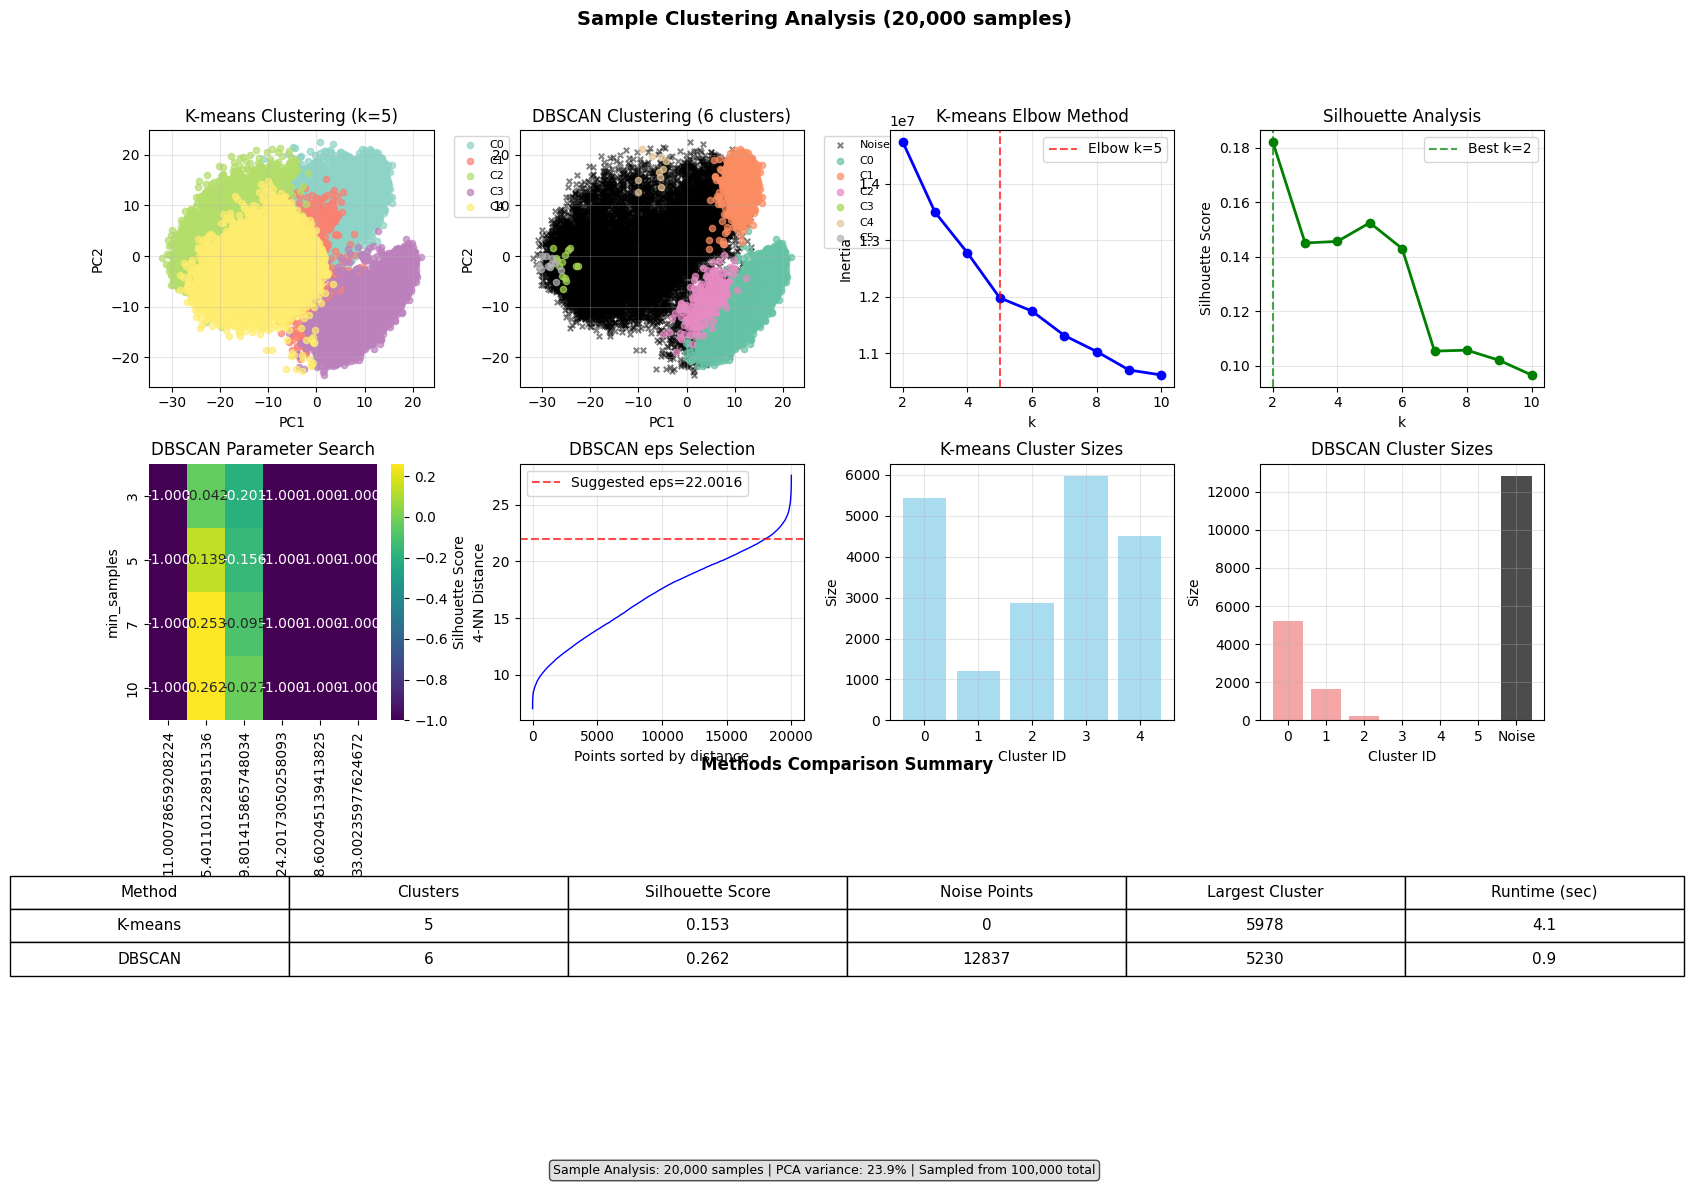


🎯 SAMPLE CLUSTERING ANALYSIS COMPLETE
📊 Analysis samples: 20,000
📊 Total dataset: 100,000
⏱️ Total runtime: 1.1 minutes

🎯 K-MEANS RESULTS:
   Optimal k (Elbow): 5
   Optimal k (Silhouette): 2
   Final k used: 5
   Silhouette score: 0.153

🌐 DBSCAN RESULTS:
   Clusters found: 6
   Noise points: 12,837 (64.2%)
   Silhouette score: 0.262
   Best eps: 15.4011
   Best min_samples: 10

✅ ANALYSIS COMPLETE - Ready for interpretation!
🔬 MEDIUM CLUSTERING TEST
📊 Sampling 40,000 from 100,000 total samples
🎯 Sample Clustering Analyzer Initialized!
📊 Analysis samples: 40,000
🧬 Embedding dimensions: 1152
🔧 Methods: K-means + DBSCAN (sample-optimized)
🚀 RUNNING COMPLETE SAMPLE CLUSTERING ANALYSIS
📐 PREPARING DATA FOR CLUSTERING
   🔧 Standardizing embeddings...
   📉 Applying PCA: 1152 → 30 dimensions
   📊 PCA retained 76.6% of variance
✅ Data preparation complete (2.6 seconds)
   📊 Clustering data shape: (40000, 30)

STEP 1: K-MEANS ANALYSIS
📈 K-MEANS ELBOW METHOD ANALYSIS
   🎯 Testing k values: 2 

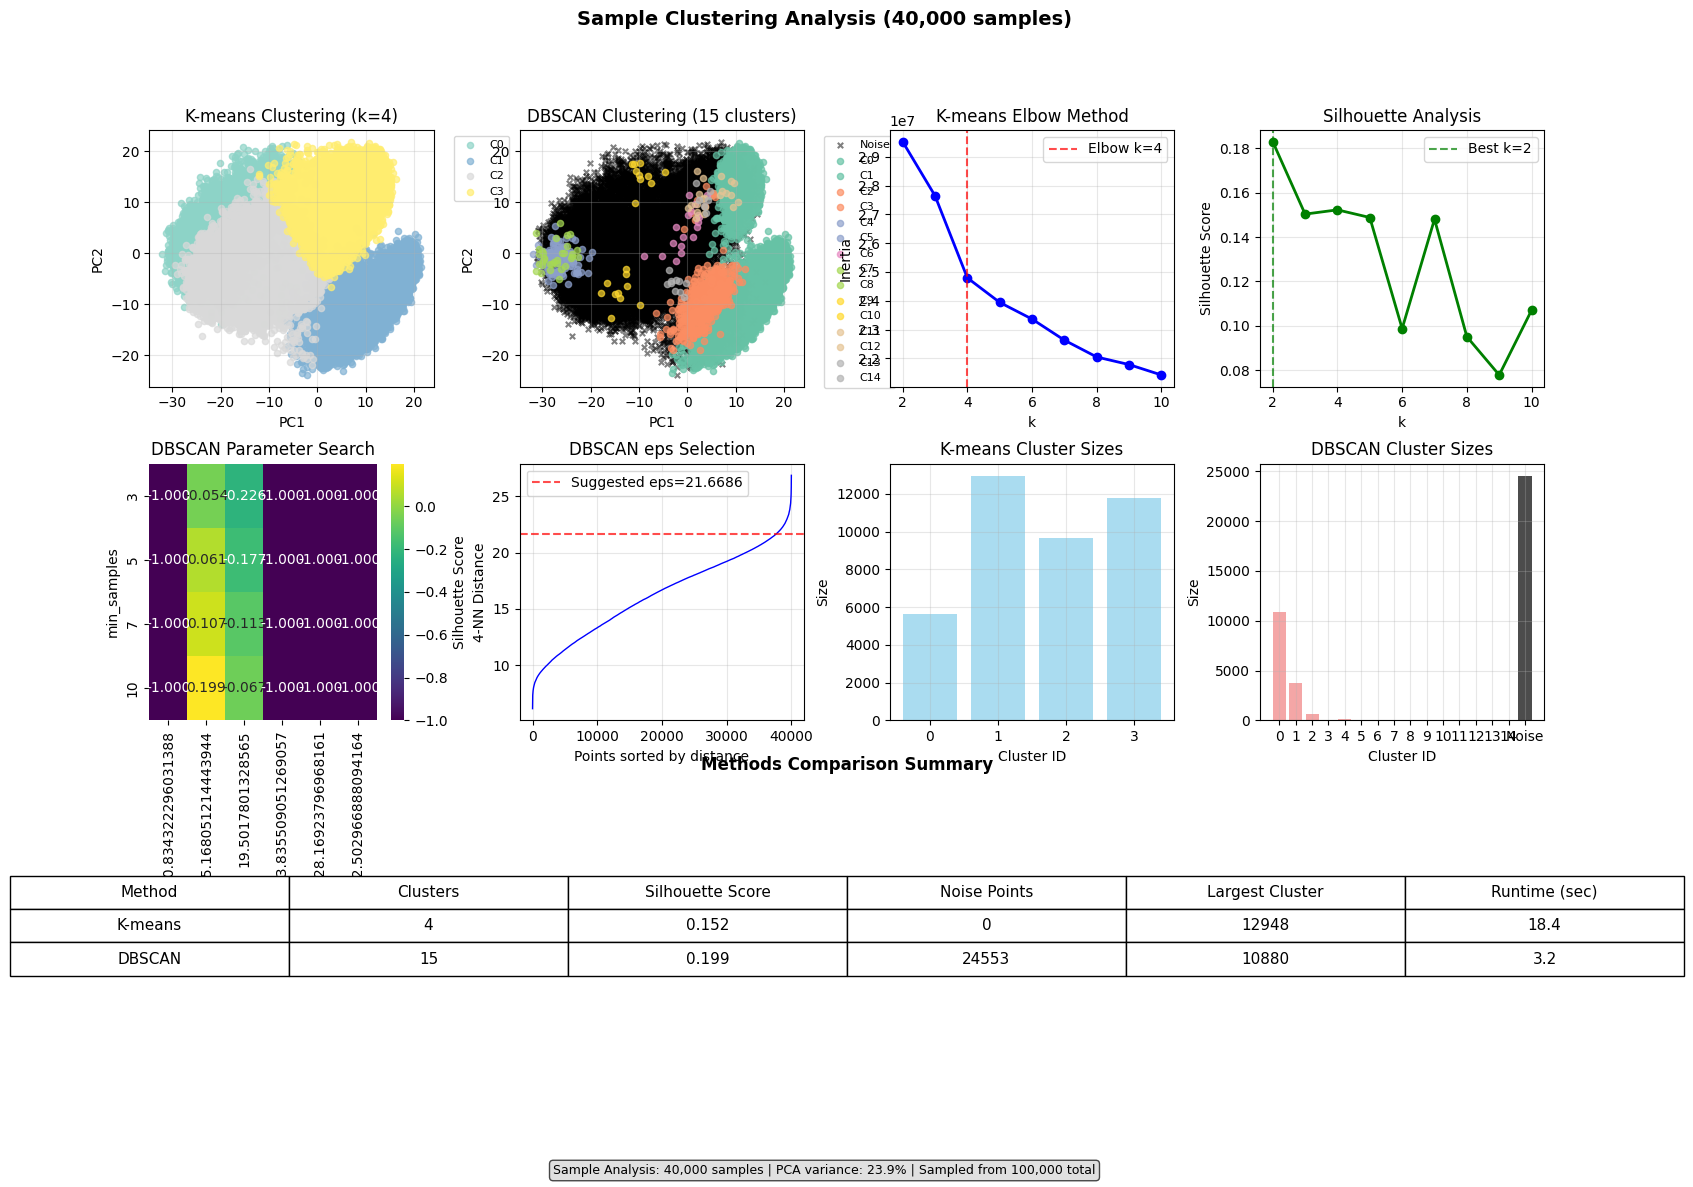


🎯 SAMPLE CLUSTERING ANALYSIS COMPLETE
📊 Analysis samples: 40,000
📊 Total dataset: 100,000
⏱️ Total runtime: 4.9 minutes

🎯 K-MEANS RESULTS:
   Optimal k (Elbow): 4
   Optimal k (Silhouette): 2
   Final k used: 4
   Silhouette score: 0.152

🌐 DBSCAN RESULTS:
   Clusters found: 15
   Noise points: 24,553 (61.4%)
   Silhouette score: 0.199
   Best eps: 15.1681
   Best min_samples: 10

✅ ANALYSIS COMPLETE - Ready for interpretation!
📊 Sampling 30,000 from 100,000 total samples
🎯 Sample Clustering Analyzer Initialized!
📊 Analysis samples: 30,000
🧬 Embedding dimensions: 1152
🔧 Methods: K-means + DBSCAN (sample-optimized)
🚀 RUNNING COMPLETE SAMPLE CLUSTERING ANALYSIS
📐 PREPARING DATA FOR CLUSTERING
   🔧 Standardizing embeddings...
   📉 Applying PCA: 1152 → 30 dimensions
   📊 PCA retained 76.5% of variance
✅ Data preparation complete (2.4 seconds)
   📊 Clustering data shape: (30000, 30)

STEP 1: K-MEANS ANALYSIS
📈 K-MEANS ELBOW METHOD ANALYSIS
   🎯 Testing k values: 2 to 10
   📊 Dataset: 30,0

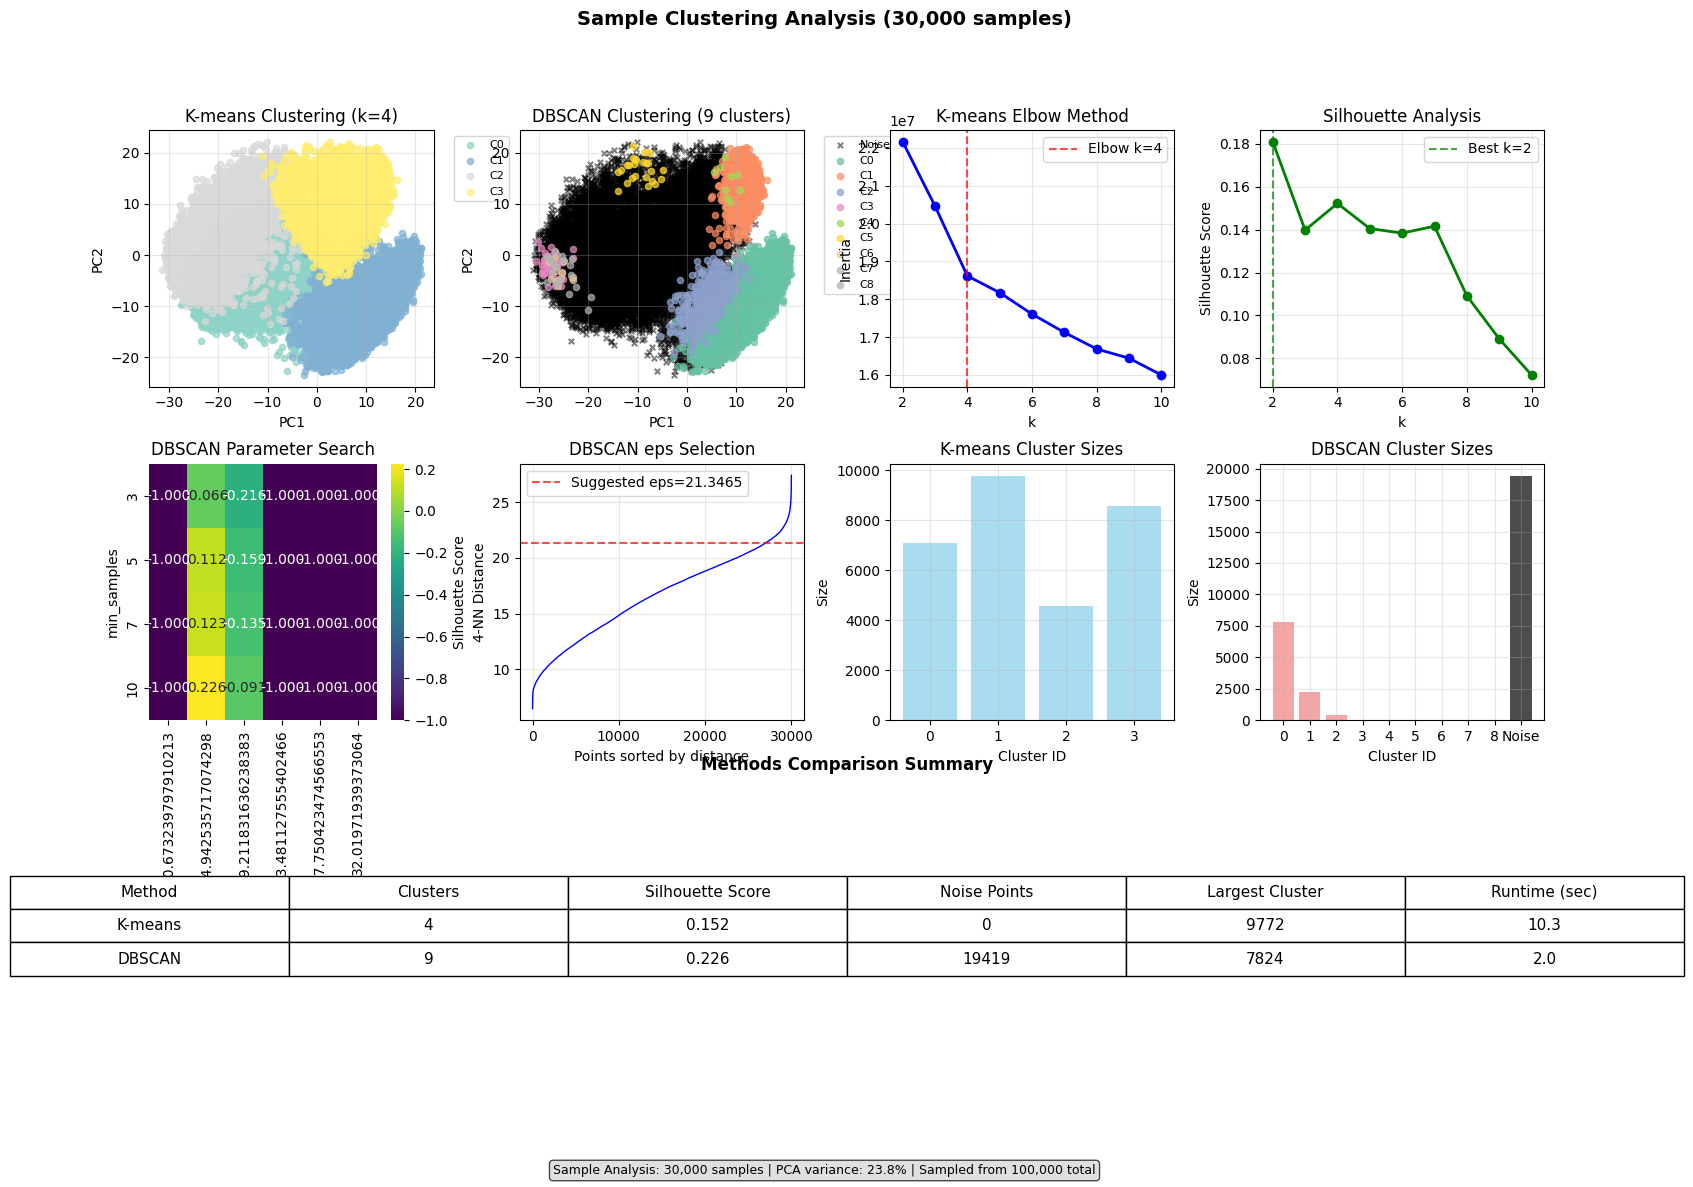


🎯 SAMPLE CLUSTERING ANALYSIS COMPLETE
📊 Analysis samples: 30,000
📊 Total dataset: 100,000
⏱️ Total runtime: 2.6 minutes

🎯 K-MEANS RESULTS:
   Optimal k (Elbow): 4
   Optimal k (Silhouette): 2
   Final k used: 4
   Silhouette score: 0.152

🌐 DBSCAN RESULTS:
   Clusters found: 9
   Noise points: 19,419 (64.7%)
   Silhouette score: 0.226
   Best eps: 14.9425
   Best min_samples: 10

✅ ANALYSIS COMPLETE - Ready for interpretation!


In [69]:
# Quick test (recommended for development)
analyzer, results = quick_clustering_test()

# Medium test (more samples, still fast)  
analyzer, results = medium_clustering_test()

# Custom sample size
analyzer = create_sample_analyzer(df, meta, max_samples=30000)
results = analyzer.run_complete_analysis()

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

class SampleClusteringAnalyzer:
    def __init__(self, embeddings_df, metadata_df=None, sop_column='SOP', max_sample_size=25000):
        """
        Sample-based clustering analyzer optimized for development and testing
        Always works with manageable sample sizes for efficient iteration
        
        Parameters:
        - embeddings_df: DataFrame with embeddings
        - metadata_df: Optional clinical metadata
        - sop_column: Column name for sample IDs
        - max_sample_size: Maximum samples to use (default: 25K)
        """
        self.embeddings_df = embeddings_df
        self.metadata_df = metadata_df
        self.sop_column = sop_column
        self.max_sample_size = max_sample_size
        
        # Extract embedding data
        if sop_column in embeddings_df.columns:
            self.embedding_columns = [col for col in embeddings_df.columns if col != sop_column]
        else:
            self.embedding_columns = list(embeddings_df.columns)
        
        # Sample data if needed
        if len(embeddings_df) > max_sample_size:
            print(f"📊 Sampling {max_sample_size:,} from {len(embeddings_df):,} total samples")
            sample_indices = np.random.choice(len(embeddings_df), max_sample_size, replace=False)
            self.embeddings_df_sample = embeddings_df.iloc[sample_indices].copy()
            self.sample_indices = sample_indices
            self.is_sampled = True
        else:
            print(f"📊 Using full dataset: {len(embeddings_df):,} samples")
            self.embeddings_df_sample = embeddings_df.copy()
            self.sample_indices = np.arange(len(embeddings_df))
            self.is_sampled = False
        
        self.embeddings_array = self.embeddings_df_sample[self.embedding_columns].values
        self.sop_ids = (self.embeddings_df_sample.index if sop_column not in self.embeddings_df_sample.columns 
                       else self.embeddings_df_sample[sop_column].values)
        
        # Results storage
        self.clustering_results = {}
        self.embeddings_for_clustering = None
        self.scaler = None
        
        print(f"🎯 Sample Clustering Analyzer Initialized!")
        print(f"📊 Analysis samples: {len(self.embeddings_array):,}")
        print(f"🧬 Embedding dimensions: {len(self.embedding_columns)}")
        print(f"🔧 Methods: K-means + DBSCAN (sample-optimized)")
    
    def prepare_clustering_data(self, use_pca_reduction=True, n_pca_components=30):
        """Prepare and standardize data for clustering (sample-optimized)"""
        print("📐 PREPARING DATA FOR CLUSTERING")
        print("=" * 40)
        
        start_time = time.time()
        
        # Standardize embeddings
        print("   🔧 Standardizing embeddings...")
        self.scaler = StandardScaler()
        embeddings_scaled = self.scaler.fit_transform(self.embeddings_array)
        
        # PCA reduction (always recommended for sample analysis)
        if use_pca_reduction and len(self.embedding_columns) > n_pca_components:
            print(f"   📉 Applying PCA: {len(self.embedding_columns)} → {n_pca_components} dimensions")
            
            pca = PCA(n_components=n_pca_components)
            embeddings_reduced = pca.fit_transform(embeddings_scaled)
            
            variance_retained = pca.explained_variance_ratio_.sum()
            print(f"   📊 PCA retained {variance_retained*100:.1f}% of variance")
            
            self.pca_model = pca
            self.embeddings_for_clustering = embeddings_reduced
        else:
            print("   ℹ️  Using original dimensions")
            self.embeddings_for_clustering = embeddings_scaled
            self.pca_model = None
        
        end_time = time.time()
        
        print(f"✅ Data preparation complete ({end_time - start_time:.1f} seconds)")
        print(f"   📊 Clustering data shape: {self.embeddings_for_clustering.shape}")
        
        return self.embeddings_for_clustering
    
    def perform_kmeans_elbow_analysis(self, k_range=range(2, 11), use_minibatch=True):
        """K-means elbow analysis (sample-optimized)"""
        print(f"📈 K-MEANS ELBOW METHOD ANALYSIS")
        print("=" * 45)
        print(f"   🎯 Testing k values: {k_range.start} to {k_range.stop-1}")
        print(f"   📊 Dataset: {len(self.embeddings_for_clustering):,} samples")
        print(f"   🔧 Method: {'MiniBatchKMeans' if use_minibatch else 'KMeans'}")
        
        inertias = []
        silhouette_scores = []
        k_values = list(k_range)
        
        start_time = time.time()
        
        for k in k_values:
            print(f"   🔄 Testing k={k}...")
            
            # Choose K-means variant (MiniBatch for efficiency)
            if use_minibatch and len(self.embeddings_for_clustering) > 1000:
                kmeans = MiniBatchKMeans(
                    n_clusters=k, random_state=42, batch_size=500,
                    n_init=10, max_iter=100
                )
            else:
                kmeans = KMeans(
                    n_clusters=k, random_state=42, n_init=10, max_iter=100
                )
            
            # Fit and predict
            labels = kmeans.fit_predict(self.embeddings_for_clustering)
            inertia = kmeans.inertia_
            inertias.append(inertia)
            
            # Silhouette score (full dataset for samples)
            silhouette_avg = silhouette_score(self.embeddings_for_clustering, labels)
            silhouette_scores.append(silhouette_avg)
            print(f"      Inertia: {inertia:.2f}, Silhouette: {silhouette_avg:.3f}")
        
        end_time = time.time()
        
        # Find optimal k
        optimal_k_elbow = self._find_elbow_point(k_values, inertias)
        optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
        
        # Store results
        self.clustering_results['kmeans_elbow'] = {
            'k_values': k_values,
            'inertias': inertias,
            'silhouette_scores': silhouette_scores,
            'optimal_k_elbow': optimal_k_elbow,
            'optimal_k_silhouette': optimal_k_silhouette,
            'max_silhouette_score': max(silhouette_scores),
            'runtime_minutes': (end_time - start_time) / 60,
            'use_minibatch': use_minibatch
        }
        
        print(f"✅ K-MEANS ELBOW ANALYSIS COMPLETE ({(end_time - start_time)/60:.1f} minutes)")
        print(f"   🎯 Optimal k (Elbow): {optimal_k_elbow}")
        print(f"   🎯 Optimal k (Silhouette): {optimal_k_silhouette}")
        print(f"   📈 Max silhouette: {max(silhouette_scores):.3f}")
        
        return self.clustering_results['kmeans_elbow']
    
    def _find_elbow_point(self, k_values, inertias):
        """Find elbow point using distance from line method"""
        k_array = np.array(k_values)
        inertia_array = np.array(inertias)
        
        if len(k_array) < 3:
            return k_values[len(k_values)//2]
        
        # Distance from line method
        line_start = np.array([k_array[0], inertia_array[0]])
        line_end = np.array([k_array[-1], inertia_array[-1]])
        
        distances = []
        for i, k in enumerate(k_array):
            point = np.array([k, inertia_array[i]])
            
            # Distance from point to line
            line_vec = line_end - line_start
            point_vec = point - line_start
            
            line_len = np.linalg.norm(line_vec)
            if line_len > 0:
                line_unitvec = line_vec / line_len
                proj_length = np.dot(point_vec, line_unitvec)
                proj = line_start + proj_length * line_unitvec
                distance = np.linalg.norm(point - proj)
            else:
                distance = 0
            
            distances.append(distance)
        
        # Find point with maximum distance from line
        max_dist_idx = np.argmax(distances)
        elbow_k = k_array[max_dist_idx]
        
        return int(elbow_k)
    
    def fit_optimal_kmeans(self, k=None, use_minibatch=True):
        """Fit K-means with optimal number of clusters"""
        if k is None:
            if 'kmeans_elbow' not in self.clustering_results:
                raise ValueError("Run perform_kmeans_elbow_analysis() first or provide k")
            k = self.clustering_results['kmeans_elbow']['optimal_k_elbow']
        
        print(f"🎯 FITTING OPTIMAL K-MEANS (k={k})")
        print("=" * 35)
        
        start_time = time.time()
        
        # Fit final model
        if use_minibatch and len(self.embeddings_for_clustering) > 1000:
            kmeans = MiniBatchKMeans(
                n_clusters=k, random_state=42, batch_size=500,
                n_init=10, max_iter=100
            )
        else:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=100)
        
        labels = kmeans.fit_predict(self.embeddings_for_clustering)
        
        # Calculate metrics
        inertia = kmeans.inertia_
        silhouette_avg = silhouette_score(self.embeddings_for_clustering, labels)
        
        end_time = time.time()
        
        # Analyze cluster sizes
        unique_labels, counts = np.unique(labels, return_counts=True)
        
        # Store results
        self.clustering_results['final_kmeans'] = {
            'model': kmeans,
            'labels': labels,
            'k': k,
            'inertia': inertia,
            'silhouette_score': silhouette_avg,
            'cluster_centers': kmeans.cluster_centers_,
            'cluster_sizes': counts,
            'runtime_seconds': end_time - start_time
        }
        
        print(f"✅ OPTIMAL K-MEANS COMPLETE ({end_time - start_time:.1f} seconds)")
        print(f"   📊 Clusters: {k}")
        print(f"   📈 Silhouette: {silhouette_avg:.3f}")
        print(f"   📉 Inertia: {inertia:.2f}")
        print(f"   📊 Cluster sizes: {dict(zip(unique_labels, counts))}")
        
        return self.clustering_results['final_kmeans']
    
    def find_optimal_dbscan_eps(self, k_neighbors=4):
        """Find optimal eps parameter for DBSCAN"""
        print(f"🔍 FINDING OPTIMAL DBSCAN EPS PARAMETER")
        print("=" * 45)
        print(f"   📊 Dataset: {len(self.embeddings_for_clustering):,} samples")
        print(f"   🎯 Method: k-distance graph (k={k_neighbors})")
        
        start_time = time.time()
        
        # Calculate k-distance for each point
        print("   📐 Computing k-nearest neighbors...")
        neighbors = NearestNeighbors(n_neighbors=k_neighbors)
        neighbors_fit = neighbors.fit(self.embeddings_for_clustering)
        distances, indices = neighbors_fit.kneighbors(self.embeddings_for_clustering)
        
        # Get k-distances (distance to k-th nearest neighbor)
        k_distances = distances[:, k_neighbors-1]
        k_distances = np.sort(k_distances)
        
        # Find the "elbow" in k-distance plot
        suggested_eps = self._find_eps_elbow(k_distances)
        
        end_time = time.time()
        
        print(f"✅ EPS ANALYSIS COMPLETE ({end_time - start_time:.1f} seconds)")
        print(f"   🎯 Suggested eps: {suggested_eps:.4f}")
        print(f"   📊 k-distances range: {k_distances.min():.4f} to {k_distances.max():.4f}")
        
        # Store results
        self.clustering_results['dbscan_eps_analysis'] = {
            'k_distances': k_distances,
            'suggested_eps': suggested_eps,
            'k_neighbors': k_neighbors,
            'runtime_seconds': end_time - start_time
        }
        
        return suggested_eps, k_distances
    
    def _find_eps_elbow(self, k_distances):
        """Find elbow point in k-distance graph"""
        n_points = len(k_distances)
        x_values = np.arange(n_points)
        
        # Use multiple methods and take median
        methods_results = []
        
        # Method 1: 90th percentile (conservative)
        eps_percentile = np.percentile(k_distances, 90)
        methods_results.append(eps_percentile)
        
        # Method 2: Distance from line method
        if n_points >= 10:
            line_start = np.array([0, k_distances[0]])
            line_end = np.array([n_points-1, k_distances[-1]])
            
            distances = []
            for i in range(n_points):
                point = np.array([i, k_distances[i]])
                
                line_vec = line_end - line_start
                point_vec = point - line_start
                
                line_len = np.linalg.norm(line_vec)
                if line_len > 0:
                    line_unitvec = line_vec / line_len
                    proj_length = np.dot(point_vec, line_unitvec)
                    proj = line_start + proj_length * line_unitvec
                    distance = np.linalg.norm(point - proj)
                else:
                    distance = 0
                
                distances.append(distance)
            
            max_dist_idx = np.argmax(distances)
            eps_distance = k_distances[max_dist_idx]
            methods_results.append(eps_distance)
        
        # Method 3: Gradient-based
        if n_points >= 5:
            gradients = np.gradient(k_distances)
            steep_increase_idx = np.argmax(gradients)
            eps_gradient = k_distances[steep_increase_idx]
            methods_results.append(eps_gradient)
        
        # Return median of methods
        return np.median(methods_results)
    
    def perform_dbscan_parameter_search(self, eps_range=None, min_samples_range=[3, 5, 7, 10]):
        """DBSCAN parameter search (sample-optimized)"""
        print(f"🌐 DBSCAN PARAMETER GRID SEARCH")
        print("=" * 35)
        
        # Use suggested eps if not provided
        if eps_range is None:
            if 'dbscan_eps_analysis' not in self.clustering_results:
                suggested_eps, _ = self.find_optimal_dbscan_eps()
            else:
                suggested_eps = self.clustering_results['dbscan_eps_analysis']['suggested_eps']
            
            # Create smaller eps range for samples
            eps_range = np.linspace(suggested_eps * 0.5, suggested_eps * 1.5, 6)
            print(f"   🎯 Auto eps range: {eps_range.min():.4f} to {eps_range.max():.4f}")
        
        print(f"   📊 Testing {len(eps_range)} eps × {len(min_samples_range)} min_samples = {len(eps_range) * len(min_samples_range)} combinations")
        
        start_time = time.time()
        
        best_score = -1
        best_params = None
        results = []
        
        for eps in eps_range:
            for min_samples in min_samples_range:
                print(f"   🔄 Testing eps={eps:.4f}, min_samples={min_samples}")
                
                # Fit DBSCAN
                dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
                labels = dbscan.fit_predict(self.embeddings_for_clustering)
                
                # Calculate metrics
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = list(labels).count(-1)
                noise_ratio = n_noise / len(labels)
                
                # Skip if too few clusters or too much noise
                if n_clusters < 2 or noise_ratio > 0.7:
                    silhouette_avg = -1
                    print(f"      ❌ Skipped: {n_clusters} clusters, {noise_ratio*100:.1f}% noise")
                else:
                    # Calculate silhouette score (excluding noise points)
                    non_noise_mask = labels != -1
                    if np.sum(non_noise_mask) > 1:
                        silhouette_avg = silhouette_score(
                            self.embeddings_for_clustering[non_noise_mask], 
                            labels[non_noise_mask]
                        )
                    else:
                        silhouette_avg = -1
                    
                    print(f"      ✅ {n_clusters} clusters, {noise_ratio*100:.1f}% noise, silhouette: {silhouette_avg:.3f}")
                
                # Store result
                result = {
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'noise_ratio': noise_ratio,
                    'silhouette_score': silhouette_avg
                }
                results.append(result)
                
                # Update best parameters
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_params = {'eps': eps, 'min_samples': min_samples}
        
        end_time = time.time()
        
        # Store results
        self.clustering_results['dbscan_grid_search'] = {
            'results': results,
            'best_params': best_params,
            'best_score': best_score,
            'eps_range': eps_range,
            'min_samples_range': min_samples_range,
            'runtime_minutes': (end_time - start_time) / 60
        }
        
        print(f"✅ DBSCAN GRID SEARCH COMPLETE ({(end_time - start_time)/60:.1f} minutes)")
        if best_params:
            print(f"   🎯 Best parameters: eps={best_params['eps']:.4f}, min_samples={best_params['min_samples']}")
            print(f"   📈 Best silhouette: {best_score:.3f}")
        else:
            print("   ❌ No good parameters found")
        
        return self.clustering_results['dbscan_grid_search']
    
    def fit_optimal_dbscan(self, eps=None, min_samples=None):
        """Fit DBSCAN with optimal parameters"""
        if eps is None or min_samples is None:
            if 'dbscan_grid_search' not in self.clustering_results:
                raise ValueError("Run perform_dbscan_parameter_search() first or provide parameters")
            
            best_params = self.clustering_results['dbscan_grid_search']['best_params']
            if not best_params:
                raise ValueError("No valid DBSCAN parameters found")
            
            eps = best_params['eps']
            min_samples = best_params['min_samples']
        
        print(f"🌐 FITTING OPTIMAL DBSCAN")
        print("=" * 30)
        print(f"   🎯 Parameters: eps={eps:.4f}, min_samples={min_samples}")
        
        start_time = time.time()
        
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(self.embeddings_for_clustering)
        
        # Calculate metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        # Silhouette score
        if n_clusters > 1:
            non_noise_mask = labels != -1
            if np.sum(non_noise_mask) > 1:
                silhouette_avg = silhouette_score(
                    self.embeddings_for_clustering[non_noise_mask], 
                    labels[non_noise_mask]
                )
            else:
                silhouette_avg = -1
        else:
            silhouette_avg = -1
        
        # Analyze cluster sizes
        unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
        
        end_time = time.time()
        
        # Store results
        self.clustering_results['final_dbscan'] = {
            'model': dbscan,
            'labels': labels,
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette_score': silhouette_avg,
            'cluster_sizes': dict(zip(unique_labels, counts)) if len(unique_labels) > 0 else {},
            'runtime_seconds': end_time - start_time
        }
        
        print(f"✅ OPTIMAL DBSCAN COMPLETE ({end_time - start_time:.1f} seconds)")
        print(f"   📊 Clusters found: {n_clusters}")
        print(f"   🔇 Noise points: {n_noise} ({noise_ratio*100:.1f}%)")
        print(f"   📈 Silhouette: {silhouette_avg:.3f}")
        if len(unique_labels) > 0:
            print(f"   📊 Cluster sizes: {dict(zip(unique_labels, counts))}")
        
        return self.clustering_results['final_dbscan']
    
    def plot_clustering_results(self, figsize=(18, 12)):
        """Create comprehensive clustering visualization"""
        if 'final_kmeans' not in self.clustering_results or 'final_dbscan' not in self.clustering_results:
            print("❌ Run both K-means and DBSCAN analysis first!")
            return None
        
        # Create 2D representation using PCA
        if self.pca_model is None:
            # Create PCA for visualization
            pca_2d = PCA(n_components=2, random_state=42)
            coords_2d = pca_2d.fit_transform(self.embeddings_for_clustering)
            pca_variance = pca_2d.explained_variance_ratio_.sum() * 100
        else:
            # Use existing PCA (first 2 components)
            coords_2d = self.embeddings_for_clustering[:, :2]
            pca_variance = self.pca_model.explained_variance_ratio_[:2].sum() * 100
        
        # Get results
        kmeans_results = self.clustering_results['final_kmeans']
        dbscan_results = self.clustering_results['final_dbscan']
        
        # Create subplots
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
        
        fig.suptitle(f'Sample Clustering Analysis ({len(self.embeddings_for_clustering):,} samples)', 
                    fontsize=14, fontweight='bold')
        
        # Colors
        kmeans_colors = plt.cm.Set3(np.linspace(0, 1, kmeans_results['k']))
        dbscan_n_clusters = dbscan_results['n_clusters']
        dbscan_colors = plt.cm.Set2(np.linspace(0, 1, max(dbscan_n_clusters, 1)))
        
        # Plot 1: K-means results
        ax1 = fig.add_subplot(gs[0, 0])
        for cluster_id in range(kmeans_results['k']):
            mask = kmeans_results['labels'] == cluster_id
            if np.any(mask):
                ax1.scatter(coords_2d[mask, 0], coords_2d[mask, 1], 
                          c=[kmeans_colors[cluster_id]], label=f'C{cluster_id}',
                          alpha=0.7, s=20)
        ax1.set_title(f'K-means Clustering (k={kmeans_results["k"]})')
        ax1.set_xlabel(f'PC1')
        ax1.set_ylabel(f'PC2')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: DBSCAN results
        ax2 = fig.add_subplot(gs[0, 1])
        dbscan_labels = dbscan_results['labels']
        
        # Plot noise points first
        noise_mask = dbscan_labels == -1
        if np.any(noise_mask):
            ax2.scatter(coords_2d[noise_mask, 0], coords_2d[noise_mask, 1], 
                      c='black', marker='x', alpha=0.5, s=15, label='Noise')
        
        # Plot clusters
        for cluster_id in range(dbscan_n_clusters):
            mask = dbscan_labels == cluster_id
            if np.any(mask):
                ax2.scatter(coords_2d[mask, 0], coords_2d[mask, 1], 
                          c=[dbscan_colors[cluster_id]], label=f'C{cluster_id}',
                          alpha=0.7, s=20)
        
        ax2.set_title(f'DBSCAN Clustering ({dbscan_n_clusters} clusters)')
        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC2')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: K-means Elbow Analysis
        if 'kmeans_elbow' in self.clustering_results:
            ax3 = fig.add_subplot(gs[0, 2])
            elbow_data = self.clustering_results['kmeans_elbow']
            
            ax3.plot(elbow_data['k_values'], elbow_data['inertias'], 'bo-', linewidth=2, markersize=6)
            ax3.axvline(x=elbow_data['optimal_k_elbow'], color='red', linestyle='--', 
                       alpha=0.7, label=f'Elbow k={elbow_data["optimal_k_elbow"]}')
            ax3.legend()
            ax3.set_xlabel('k')
            ax3.set_ylabel('Inertia')
            ax3.set_title('K-means Elbow Method')
            ax3.grid(True, alpha=0.3)
        
        # Plot 4: Silhouette Analysis
        if 'kmeans_elbow' in self.clustering_results:
            ax4 = fig.add_subplot(gs[0, 3])
            elbow_data = self.clustering_results['kmeans_elbow']
            
            ax4.plot(elbow_data['k_values'], elbow_data['silhouette_scores'], 'go-', linewidth=2, markersize=6)
            ax4.axvline(x=elbow_data['optimal_k_silhouette'], color='green', linestyle='--',
                       alpha=0.7, label=f'Best k={elbow_data["optimal_k_silhouette"]}')
            ax4.legend()
            ax4.set_xlabel('k')
            ax4.set_ylabel('Silhouette Score')
            ax4.set_title('Silhouette Analysis')
            ax4.grid(True, alpha=0.3)
        
        # Plot 5: DBSCAN Parameter Heatmap
        if 'dbscan_grid_search' in self.clustering_results:
            ax5 = fig.add_subplot(gs[1, 0])
            grid_data = self.clustering_results['dbscan_grid_search']
            
            results_df = pd.DataFrame(grid_data['results'])
            pivot_table = results_df.pivot_table(values='silhouette_score', 
                                                index='min_samples', 
                                                columns='eps', 
                                                aggfunc='mean')
            
            sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='viridis', ax=ax5, 
                       cbar_kws={'label': 'Silhouette Score'})
            ax5.set_title('DBSCAN Parameter Search')
            ax5.set_xlabel('eps')
            ax5.set_ylabel('min_samples')
        
        # Plot 6: eps Analysis
        if 'dbscan_eps_analysis' in self.clustering_results:
            ax6 = fig.add_subplot(gs[1, 1])
            eps_data = self.clustering_results['dbscan_eps_analysis']
            
            k_distances = eps_data['k_distances']
            ax6.plot(range(len(k_distances)), k_distances, 'b-', linewidth=1)
            ax6.axhline(y=eps_data['suggested_eps'], color='red', linestyle='--',
                       alpha=0.7, label=f'Suggested eps={eps_data["suggested_eps"]:.4f}')
            ax6.legend()
            ax6.set_xlabel('Points sorted by distance')
            ax6.set_ylabel(f'{eps_data["k_neighbors"]}-NN Distance')
            ax6.set_title('DBSCAN eps Selection')
            ax6.grid(True, alpha=0.3)
        
        # Plot 7: K-means Cluster Sizes
        ax7 = fig.add_subplot(gs[1, 2])
        kmeans_sizes = kmeans_results['cluster_sizes']
        ax7.bar(range(len(kmeans_sizes)), kmeans_sizes, alpha=0.7, color='skyblue')
        ax7.set_xlabel('Cluster ID')
        ax7.set_ylabel('Size')
        ax7.set_title(f'K-means Cluster Sizes')
        ax7.grid(True, alpha=0.3)
        
        # Plot 8: DBSCAN Cluster Sizes
        ax8 = fig.add_subplot(gs[1, 3])
        if dbscan_results['cluster_sizes']:
            cluster_ids = list(dbscan_results['cluster_sizes'].keys())
            sizes = list(dbscan_results['cluster_sizes'].values())
            bars = ax8.bar(range(len(sizes)), sizes, alpha=0.7, color='lightcoral')
            ax8.set_xticks(range(len(sizes)))
            ax8.set_xticklabels(cluster_ids)
            
            # Add noise count
            if dbscan_results['n_noise'] > 0:
                ax8.bar([len(sizes)], [dbscan_results['n_noise']], 
                        alpha=0.7, color='black', label='Noise')
                ax8.set_xticks(range(len(sizes) + 1))
                ax8.set_xticklabels(cluster_ids + ['Noise'])
        
        ax8.set_xlabel('Cluster ID')
        ax8.set_ylabel('Size')
        ax8.set_title(f'DBSCAN Cluster Sizes')
        ax8.grid(True, alpha=0.3)
        
        # Summary comparison table
        ax9 = fig.add_subplot(gs[2, :])
        
        comparison_data = {
            'Method': ['K-means', 'DBSCAN'],
            'Clusters': [kmeans_results['k'], dbscan_n_clusters],
            'Silhouette Score': [f"{kmeans_results['silhouette_score']:.3f}", 
                               f"{dbscan_results['silhouette_score']:.3f}"],
            'Noise Points': [0, dbscan_results['n_noise']],
            'Largest Cluster': [max(kmeans_results['cluster_sizes']), 
                              max(dbscan_results['cluster_sizes'].values()) if dbscan_results['cluster_sizes'] else 0],
            'Runtime (sec)': [f"{kmeans_results['runtime_seconds']:.1f}", 
                            f"{dbscan_results['runtime_seconds']:.1f}"]
        }
        
        comparison_df = pd.DataFrame(comparison_data)
        ax9.axis('tight')
        ax9.axis('off')
        table = ax9.table(cellText=comparison_df.values, colLabels=comparison_df.columns,
                          cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 2.0)
        ax9.set_title('Methods Comparison Summary', pad=20, fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        
        # Add footer
        footer_text = f"Sample Analysis: {len(self.embeddings_for_clustering):,} samples | PCA variance: {pca_variance:.1f}%"
        if self.is_sampled:
            footer_text += f" | Sampled from {len(self.embeddings_df):,} total"
        
        plt.figtext(0.5, 0.01, footer_text, ha='center', fontsize=9, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
        
        return fig
    
    def run_complete_analysis(self):
        """Run complete sample-based clustering analysis"""
        print("🚀 RUNNING COMPLETE SAMPLE CLUSTERING ANALYSIS")
        print("=" * 60)
        
        total_start_time = time.time()
        
        # Step 1: Prepare data
        self.prepare_clustering_data()
        
        # Step 2: K-means analysis
        print("\n" + "="*50)
        print("STEP 1: K-MEANS ANALYSIS")
        print("="*50)
        
        kmeans_elbow = self.perform_kmeans_elbow_analysis()
        kmeans_final = self.fit_optimal_kmeans()
        
        # Step 3: DBSCAN analysis  
        print("\n" + "="*50)
        print("STEP 2: DBSCAN ANALYSIS")
        print("="*50)
        
        suggested_eps, k_distances = self.find_optimal_dbscan_eps()
        dbscan_grid = self.perform_dbscan_parameter_search()
        
        if dbscan_grid['best_params']:
            dbscan_final = self.fit_optimal_dbscan()
            
            # Step 4: Visualizations
            print("\n" + "="*50)
            print("STEP 3: CREATING VISUALIZATIONS")
            print("="*50)
            
            fig = self.plot_clustering_results()
            plt.show()
            
        else:
            print("❌ No valid DBSCAN parameters found")
            dbscan_final = None
        
        # Final summary
        total_end_time = time.time()
        total_runtime = (total_end_time - total_start_time) / 60
        
        print("\n" + "="*60)
        print("🎯 SAMPLE CLUSTERING ANALYSIS COMPLETE")
        print("="*60)
        
        print(f"📊 Analysis samples: {len(self.embeddings_array):,}")
        if self.is_sampled:
            print(f"📊 Total dataset: {len(self.embeddings_df):,}")
        print(f"⏱️ Total runtime: {total_runtime:.1f} minutes")
        
        print(f"\n🎯 K-MEANS RESULTS:")
        print(f"   Optimal k (Elbow): {kmeans_elbow['optimal_k_elbow']}")
        print(f"   Optimal k (Silhouette): {kmeans_elbow['optimal_k_silhouette']}")
        print(f"   Final k used: {kmeans_final['k']}")
        print(f"   Silhouette score: {kmeans_final['silhouette_score']:.3f}")
        
        if dbscan_final:
            print(f"\n🌐 DBSCAN RESULTS:")
            print(f"   Clusters found: {dbscan_final['n_clusters']}")
            print(f"   Noise points: {dbscan_final['n_noise']:,} ({dbscan_final['noise_ratio']*100:.1f}%)")
            print(f"   Silhouette score: {dbscan_final['silhouette_score']:.3f}")
            print(f"   Best eps: {dbscan_final['eps']:.4f}")
            print(f"   Best min_samples: {dbscan_final['min_samples']}")
        
        print(f"\n✅ ANALYSIS COMPLETE - Ready for interpretation!")
        
        # Return all results
        return {
            'kmeans_elbow': kmeans_elbow,
            'final_kmeans': kmeans_final,
            'dbscan_grid_search': dbscan_grid,
            'final_dbscan': dbscan_final,
            'total_runtime_minutes': total_runtime,
            'sample_info': {
                'is_sampled': self.is_sampled,
                'analysis_samples': len(self.embeddings_array),
                'total_samples': len(self.embeddings_df),
                'sample_indices': self.sample_indices if self.is_sampled else None
            }
        }

# =============================================================================
# EASY USAGE FUNCTIONS
# =============================================================================

def create_sample_analyzer(embeddings_df, metadata_df=None, max_samples=25000):
    """Create a sample-based clustering analyzer"""
    return SampleClusteringAnalyzer(
        embeddings_df=embeddings_df,
        metadata_df=metadata_df,
        sop_column='SOP',
        max_sample_size=max_samples
    )

def quick_clustering_test(embeddings_df=None, metadata_df=None):
    """Quick clustering test with sample data"""
    print("⚡ QUICK CLUSTERING TEST")
    print("=" * 30)
    
    # Use provided dataframes or assume they're available as df, meta
    if embeddings_df is None:
        embeddings_df = df  # Assumes df is available in scope
    if metadata_df is None:
        metadata_df = meta  # Assumes meta is available in scope
    
    analyzer = create_sample_analyzer(embeddings_df, metadata_df, max_samples=20000)
    results = analyzer.run_complete_analysis()
    
    return analyzer, results

def medium_clustering_test(embeddings_df=None, metadata_df=None):
    """Medium clustering test with more samples"""
    print("🔬 MEDIUM CLUSTERING TEST")
    print("=" * 30)
    
    if embeddings_df is None:
        embeddings_df = df
    if metadata_df is None:
        metadata_df = meta
    
    analyzer = create_sample_analyzer(embeddings_df, metadata_df, max_samples=40000)
    results = analyzer.run_complete_analysis()
    
    return analyzer, results

# =============================================================================
# CSV RESULTS SAVER FOR SAMPLE CLUSTERING
# =============================================================================

import os
from datetime import datetime

class SampleResultsSaver:
    def __init__(self, output_dir='sample_clustering_results'):
        """Simple CSV saver for sample clustering results"""
        self.output_dir = output_dir
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        print(f"📁 Results will be saved to: {output_dir}/")
        print(f"🕐 Timestamp: {self.timestamp}")
    
    def save_sample_clustering_results(self, analyzer, results):
        """Save all sample clustering results to CSV files"""
        print(f"\n💾 SAVING SAMPLE CLUSTERING RESULTS")
        print("=" * 45)
        
        saved_files = []
        
        try:
            # 1. Save cluster assignments
            self._save_cluster_assignments(analyzer, results)
            saved_files.append("Cluster assignments")
            
            # 2. Save K-means analysis
            if 'kmeans_elbow' in results:
                self._save_kmeans_analysis(results)
                saved_files.append("K-means analysis")
            
            # 3. Save DBSCAN analysis
            if 'dbscan_grid_search' in results:
                self._save_dbscan_analysis(results)
                saved_files.append("DBSCAN analysis")
            
            # 4. Save summary
            self._save_analysis_summary(analyzer, results)
            saved_files.append("Analysis summary")
            
            print(f"\n✅ SAVE COMPLETE!")
            print(f"📁 Output directory: {self.output_dir}/")
            print(f"📄 Files saved: {len(saved_files)}")
            for file_type in saved_files:
                print(f"   ✓ {file_type}")
            
            return True
            
        except Exception as e:
            print(f"❌ Error saving results: {e}")
            return False
    
    def _save_cluster_assignments(self, analyzer, results):
        """Save cluster assignments for each sample"""
        print("   💾 Saving cluster assignments...")
        
        # Create main results DataFrame
        data = {
            'SOP': analyzer.sop_ids,
            'Sample_Index': analyzer.sample_indices if analyzer.is_sampled else list(range(len(analyzer.sop_ids)))
        }
        
        # Add K-means results
        if 'final_kmeans' in results:
            kmeans_results = results['final_kmeans']
            data['KMeans_Cluster'] = kmeans_results['labels']
            data['KMeans_K'] = kmeans_results['k']
        
        # Add DBSCAN results
        if 'final_dbscan' in results:
            dbscan_results = results['final_dbscan']
            data['DBSCAN_Cluster'] = dbscan_results['labels']
            data['DBSCAN_Is_Noise'] = dbscan_results['labels'] == -1
            data['DBSCAN_eps'] = dbscan_results['eps']
            data['DBSCAN_min_samples'] = dbscan_results['min_samples']
        
        # Add sample info
        data['Is_Sample'] = analyzer.is_sampled
        data['Total_Dataset_Size'] = len(analyzer.embeddings_df)
        
        df = pd.DataFrame(data)
        
        filename = f"{self.output_dir}/cluster_assignments_{self.timestamp}.csv"
        df.to_csv(filename, index=False)
        print(f"   ✅ Cluster assignments: {filename}")
    
    def _save_kmeans_analysis(self, results):
        """Save K-means elbow and final results"""
        print("   💾 Saving K-means analysis...")
        
        # Elbow method results
        if 'kmeans_elbow' in results:
            elbow_data = results['kmeans_elbow']
            elbow_df = pd.DataFrame({
                'k': elbow_data['k_values'],
                'inertia': elbow_data['inertias'],
                'silhouette_score': elbow_data['silhouette_scores']
            })
            
            filename = f"{self.output_dir}/kmeans_elbow_analysis_{self.timestamp}.csv"
            elbow_df.to_csv(filename, index=False)
            print(f"   ✅ K-means elbow analysis: {filename}")
        
        # Final K-means results summary
        if 'final_kmeans' in results:
            kmeans_final = results['final_kmeans']
            
            # Cluster sizes
            cluster_sizes_df = pd.DataFrame({
                'cluster_id': range(len(kmeans_final['cluster_sizes'])),
                'size': kmeans_final['cluster_sizes'],
                'percentage': kmeans_final['cluster_sizes'] / kmeans_final['cluster_sizes'].sum() * 100
            })
            
            filename = f"{self.output_dir}/kmeans_cluster_sizes_{self.timestamp}.csv"
            cluster_sizes_df.to_csv(filename, index=False)
            print(f"   ✅ K-means cluster sizes: {filename}")
    
    def _save_dbscan_analysis(self, results):
        """Save DBSCAN parameter search and final results"""
        print("   💾 Saving DBSCAN analysis...")
        
        # Parameter search results
        if 'dbscan_grid_search' in results:
            grid_data = results['dbscan_grid_search']
            
            if 'results' in grid_data:
                grid_df = pd.DataFrame(grid_data['results'])
                
                filename = f"{self.output_dir}/dbscan_parameter_search_{self.timestamp}.csv"
                grid_df.to_csv(filename, index=False)
                print(f"   ✅ DBSCAN parameter search: {filename}")
        
        # Final DBSCAN results summary
        if 'final_dbscan' in results:
            dbscan_final = results['final_dbscan']
            
            if dbscan_final['cluster_sizes']:
                # Cluster sizes
                cluster_sizes_df = pd.DataFrame({
                    'cluster_id': list(dbscan_final['cluster_sizes'].keys()),
                    'size': list(dbscan_final['cluster_sizes'].values()),
                    'percentage': [size / sum(dbscan_final['cluster_sizes'].values()) * 100 
                                 for size in dbscan_final['cluster_sizes'].values()]
                })
                
                # Add noise row
                if dbscan_final['n_noise'] > 0:
                    noise_row = pd.DataFrame({
                        'cluster_id': [-1],
                        'size': [dbscan_final['n_noise']],
                        'percentage': [dbscan_final['noise_ratio'] * 100]
                    })
                    cluster_sizes_df = pd.concat([cluster_sizes_df, noise_row], ignore_index=True)
                
                filename = f"{self.output_dir}/dbscan_cluster_sizes_{self.timestamp}.csv"
                cluster_sizes_df.to_csv(filename, index=False)
                print(f"   ✅ DBSCAN cluster sizes: {filename}")
    
    def _save_analysis_summary(self, analyzer, results):
        """Save analysis summary and metadata"""
        print("   💾 Saving analysis summary...")
        
        summary_data = {
            'Parameter': [
                'Analysis_Timestamp',
                'Total_Dataset_Size',
                'Analysis_Sample_Size',
                'Is_Sampled',
                'Total_Runtime_Minutes',
                'Embedding_Dimensions',
                'PCA_Applied'
            ],
            'Value': [
                self.timestamp,
                len(analyzer.embeddings_df),
                len(analyzer.embeddings_array),
                analyzer.is_sampled,
                results.get('total_runtime_minutes', 'Unknown'),
                len(analyzer.embedding_columns),
                analyzer.pca_model is not None
            ]
        }
        
        # Add K-means results
        if 'final_kmeans' in results:
            kmeans = results['final_kmeans']
            elbow = results.get('kmeans_elbow', {})
            
            summary_data['Parameter'].extend([
                'KMeans_Final_K',
                'KMeans_Silhouette_Score',
                'KMeans_Inertia',
                'KMeans_Optimal_K_Elbow',
                'KMeans_Optimal_K_Silhouette'
            ])
            summary_data['Value'].extend([
                kmeans['k'],
                f"{kmeans['silhouette_score']:.3f}",
                f"{kmeans['inertia']:.2f}",
                elbow.get('optimal_k_elbow', 'Unknown'),
                elbow.get('optimal_k_silhouette', 'Unknown')
            ])
        
        # Add DBSCAN results
        if 'final_dbscan' in results:
            dbscan = results['final_dbscan']
            
            summary_data['Parameter'].extend([
                'DBSCAN_Clusters',
                'DBSCAN_Noise_Points',
                'DBSCAN_Noise_Ratio',
                'DBSCAN_Silhouette_Score',
                'DBSCAN_eps',
                'DBSCAN_min_samples'
            ])
            summary_data['Value'].extend([
                dbscan['n_clusters'],
                dbscan['n_noise'],
                f"{dbscan['noise_ratio']*100:.1f}%",
                f"{dbscan['silhouette_score']:.3f}",
                f"{dbscan['eps']:.4f}",
                dbscan['min_samples']
            ])
        
        summary_df = pd.DataFrame(summary_data)
        
        filename = f"{self.output_dir}/analysis_summary_{self.timestamp}.csv"
        summary_df.to_csv(filename, index=False)
        print(f"   ✅ Analysis summary: {filename}")

def save_sample_results(analyzer, results, output_dir='sample_clustering_results'):
    """Main function to save sample clustering results to CSV"""
    saver = SampleResultsSaver(output_dir)
    return saver.save_sample_clustering_results(analyzer, results)

# =============================================================================
# ENHANCED USAGE FUNCTIONS WITH AUTO-SAVE
# =============================================================================

def quick_clustering_test_with_save(embeddings_df=None, metadata_df=None, save_results=True):
    """Quick clustering test with automatic CSV saving"""
    print("⚡ QUICK CLUSTERING TEST WITH AUTO-SAVE")
    print("=" * 40)
    
    if embeddings_df is None:
        embeddings_df = df
    if metadata_df is None:
        metadata_df = meta
    
    analyzer = create_sample_analyzer(embeddings_df, metadata_df, max_samples=20000)
    results = analyzer.run_complete_analysis()
    
    if save_results:
        save_success = save_sample_results(analyzer, results, 'quick_test_results')
        if save_success:
            print("\n🎉 Results saved successfully!")
    
    return analyzer, results

def medium_clustering_test_with_save(embeddings_df=None, metadata_df=None, save_results=True):
    """Medium clustering test with automatic CSV saving"""
    print("🔬 MEDIUM CLUSTERING TEST WITH AUTO-SAVE")
    print("=" * 40)
    
    if embeddings_df is None:
        embeddings_df = df
    if metadata_df is None:
        metadata_df = meta
    
    analyzer = create_sample_analyzer(embeddings_df, metadata_df, max_samples=40000)
    results = analyzer.run_complete_analysis()
    
    if save_results:
        save_success = save_sample_results(analyzer, results, 'medium_test_results')
        if save_success:
            print("\n🎉 Results saved successfully!")
    
    return analyzer, results

print("""
🎯 SAMPLE CLUSTERING ANALYZER WITH CSV SAVING READY!

Usage options:

1️⃣ Quick Test with Auto-Save:
   analyzer, results = quick_clustering_test_with_save()
   📁 Saves to: quick_test_results/
   
2️⃣ Medium Test with Auto-Save:
   analyzer, results = medium_clustering_test_with_save()
   📁 Saves to: medium_test_results/
   
3️⃣ Run Analysis Then Save Manually:
   analyzer, results = quick_clustering_test()
   save_sample_results(analyzer, results, 'my_custom_folder')
   
4️⃣ Save Without Auto-Save:
   analyzer, results = quick_clustering_test_with_save(save_results=False)
   # Later...
   save_sample_results(analyzer, results)

📄 Files Created:
   - cluster_assignments_[timestamp].csv
   - kmeans_elbow_analysis_[timestamp].csv  
   - kmeans_cluster_sizes_[timestamp].csv
   - dbscan_parameter_search_[timestamp].csv
   - dbscan_cluster_sizes_[timestamp].csv
   - analysis_summary_[timestamp].csv

✅ Complete analysis + automatic CSV export!
""")


🎯 SAMPLE CLUSTERING ANALYZER WITH CSV SAVING READY!

Usage options:

1️⃣ Quick Test with Auto-Save:
   analyzer, results = quick_clustering_test_with_save()
   📁 Saves to: quick_test_results/

2️⃣ Medium Test with Auto-Save:
   analyzer, results = medium_clustering_test_with_save()
   📁 Saves to: medium_test_results/

3️⃣ Run Analysis Then Save Manually:
   analyzer, results = quick_clustering_test()
   save_sample_results(analyzer, results, 'my_custom_folder')

4️⃣ Save Without Auto-Save:
   analyzer, results = quick_clustering_test_with_save(save_results=False)
   # Later...
   save_sample_results(analyzer, results)

📄 Files Created:
   - cluster_assignments_[timestamp].csv
   - kmeans_elbow_analysis_[timestamp].csv  
   - kmeans_cluster_sizes_[timestamp].csv
   - dbscan_parameter_search_[timestamp].csv
   - dbscan_cluster_sizes_[timestamp].csv
   - analysis_summary_[timestamp].csv

✅ Complete analysis + automatic CSV export!



# ATLAS

### Environment Setup: To manage the specific library requirements for our visualization and analysis tools (embedding-atlas), we established an isolated Python environment. This was encapsulated in a custom Jupyter kernel named atlas-env, preventing any conflicts with the shared server's base packages and ensuring our results are fully reproducible.

In [ ]:
# ==============================================================================
# Part 0: Environment Setup, Configuration, and Utility Functions
# ==============================================================================
import pandas as pd
import numpy as np
import os
import sys
from tqdm import tqdm
from typing import List, Literal, Tuple, Optional
from concurrent.futures import ThreadPoolExecutor, as_completed

from sklearn.preprocessing import StandardScaler
import umap

# --- Global Configuration ---
FOUNDATION_MODELS = ['BiomedCLIP', 'CheXagent', 'MedGemma', 'MedImageInsights', 'RAD-DINO']
SAMPLE_SIZE = 100000

# --- Directory Configuration ---
OUTPUT_DIR_BASE = os.path.expanduser('~/atlas_comparison_data_final')
OUTPUT_DIR_FINAL = os.path.expanduser('~/atlas_data_with_thumbnails_final')

# --- CORRECTED System File Paths ---
EMORY_TABLES_PATH = '/mnt/fsx/embeddings/EmoryCXR/Tables/'
EMORY_EMBEDDING_PATH = '/mnt/fsx/embeddings/EmoryCXR/'
# THIS IS THE NEW, CORRECT PATH TO THE PNG IMAGES
PNG_IMAGE_BASE_PATH = '/mnt/fsx_images/imaging/EmoryCXR/'

# --- Utility Function: Loading Embeddings (no changes needed here) ---
def _load_single_embedding(sop: str, dataset_path: str, FM: str) -> Tuple[str, Optional[np.ndarray]]:
    embedding_file = os.path.join(dataset_path, f'embds_{FM}', sop + '.npy')
    if not os.path.exists(embedding_file): return sop, None
    try: return sop, np.load(embedding_file)
    except Exception: return sop, None

def load_embeddings(SOP: List[str], FM: str, max_workers: Optional[int] = 8) -> pd.DataFrame:
    print(f"Loading {FM} embeddings for {len(SOP)} images...")
    dataset_path = EMORY_EMBEDDING_PATH
    embds_dict = {}
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_sop = {executor.submit(_load_single_embedding, sop, dataset_path, FM): sop for sop in SOP}
        for future in tqdm(as_completed(future_to_sop), total=len(SOP), desc=f"Loading {FM}"):
            sop, embedding = future.result()
            if embedding is not None: embds_dict[sop] = embedding
    if not embds_dict: return pd.DataFrame()
    df = pd.DataFrame.from_dict(embds_dict, orient='index').reset_index()
    df.rename(columns={'index': 'SOP'}, inplace=True)
    return df

print("Setup complete. Core functions are defined.")

# ==============================================================================
# Part 1: Main "Workhorse" Script to Process All Foundation Models
# ==============================================================================
print("\n--- Starting Part 1: Processing All Models ---")
os.makedirs(OUTPUT_DIR_BASE, exist_ok=True)
print(f"Base output files will be saved in: {OUTPUT_DIR_BASE}")

# --- Load and Prepare the Full Dataset ---
print("Loading base metadata and findings...")
df_meta = pd.read_csv(os.path.join(EMORY_TABLES_PATH, 'EmoryCXR_v2_metadata_08152025.csv'))
df_findings = pd.read_csv(os.path.join(EMORY_TABLES_PATH, 'EmoryCXR_v2_FindingLabel_10162024.csv'))
df_merged = pd.merge(df_meta, df_findings, on='AccessionNumber_anon', how='left')

# --- Create a FIXED Sample of Images ---
print(f"Creating a fixed sample of {SAMPLE_SIZE} images...")
df_views_to_include = df_merged[df_merged['ViewPosition'].isin(['AP', 'PA', 'Lateral'])].copy()
df_sample = df_views_to_include.sample(n=min(SAMPLE_SIZE, len(df_views_to_include)), random_state=42).copy()
sops_to_load = df_sample['SOP'].tolist()
print(f"Fixed sample created with {len(sops_to_load)} unique SOPs.")

# --- Loop Through Each Foundation Model ---
for fm_name in FOUNDATION_MODELS:
    print("\n" + "="*50)
    print(f"PROCESSING MODEL: {fm_name}")
    print("="*50)

    df_embeddings = load_embeddings(sops_to_load, FM=fm_name)
    if df_embeddings.empty:
        print(f"WARNING: No embeddings found for {fm_name}. Skipping.")
        continue
        
    df_model_data = pd.merge(df_sample, df_embeddings, on='SOP', how='inner')
    
    # --- Compute UMAP ---
    print("Computing UMAP projections...")
    embedding_cols = [col for col in df_embeddings.columns if col != 'SOP']
    embeddings = df_model_data[embedding_cols].values
    scaled_embeddings = StandardScaler().fit_transform(embeddings)
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
    projections = reducer.fit_transform(scaled_embeddings)
    df_model_data['x'] = projections[:, 0]
    df_model_data['y'] = projections[:, 1]

    # --- Prepare Final Columns (No symlink needed now) ---
    finding_cols_to_clean = ['Cardiomegaly', 'Edema', 'Pneumonia', 'Pneumothorax', 'No Finding']
    for col in finding_cols_to_clean:
        if col in df_model_data.columns:
            df_model_data[col] = df_model_data[col].fillna(0).replace(-1, 0).astype(int).astype(str)
    
    # We are keeping all necessary ID columns to build the path later
    columns_for_atlas = ['SOP', 'empi_anon', 'AccessionNumber_anon', 'Race', 'Age', 'Sex', 'ViewPosition', 'x', 'y'] + finding_cols_to_clean
    df_final_atlas = df_model_data[[col for col in columns_for_atlas if col in df_model_data.columns]]

    # --- Save the Parquet File ---
    output_file = os.path.join(OUTPUT_DIR_BASE, f"atlas_data_{fm_name}.parquet")
    df_final_atlas.to_parquet(output_file, index=False)
    print(f"\nSUCCESS! Data for {fm_name} saved to: {output_file}")

print("\nPart 1 Complete: All models processed.")

# ==============================================================================
# Part 2: Thumbnail Validation and Final Path Creation
# ==============================================================================
print("\n--- Starting Part 2: Validating Thumbnails & Creating Final Paths ---")
os.makedirs(OUTPUT_DIR_FINAL, exist_ok=True)
print(f"Final files will be saved in: {OUTPUT_DIR_FINAL}")
tqdm.pandas(desc="Validating thumbnails")

for fm_name in FOUNDATION_MODELS:
    print(f"\nProcessing file for model: {fm_name}")
    
    input_parquet_file = os.path.join(OUTPUT_DIR_BASE, f"atlas_data_{fm_name}.parquet")
    output_parquet_file = os.path.join(OUTPUT_DIR_FINAL, f"atlas_data_{fm_name}_final.parquet")
    
    if not os.path.exists(input_parquet_file):
        print(f"  -> WARNING: Input file not found, skipping.")
        continue
        
    print(f"  -> Loading {os.path.basename(input_parquet_file)}...")
    df = pd.read_parquet(input_parquet_file)
    
    # --- CORRECTED PATH LOGIC ---
    def construct_and_validate_path(row):
        # Construct the full, correct path to the PNG file
        # Path structure is /.../PatientID/StudyID/SOP.png
        correct_path = os.path.join(
            PNG_IMAGE_BASE_PATH, 
            str(row['empi_anon']), 
            str(row['AccessionNumber_anon']),
            str(row['SOP']) + ".png"  # The files are named with .png
        )
        # Check if this file exists and return the path and validation status
        if os.path.exists(correct_path):
            # For the server, we need a relative path from the home directory
            # We will create a new symlink to this top-level image directory
            relative_path = os.path.join(
                'emory_real_images', # New symlink name
                str(row['empi_anon']), 
                str(row['AccessionNumber_anon']),
                str(row['SOP']) + ".png"
            )
            return relative_path, 1
        return None, 0

    # Apply the function row-wise
    results = df.progress_apply(construct_and_validate_path, axis=1, result_type='expand')
    df['image_path_relative'] = results[0]
    df['has_thumbnail'] = results[1]
    
    print("\n  -> Thumbnail check complete. Results:")
    print(df['has_thumbnail'].value_counts())
    
    # --- Create the new symlink for the server ---
    symlink_path_final = os.path.expanduser('~/emory_real_images')
    if not os.path.lexists(symlink_path_final):
        os.symlink(PNG_IMAGE_BASE_PATH, symlink_path_final)
        print("Final symbolic link for server created at '~/emory_real_images'")
    
    # Save the new, enhanced Parquet file
    df.to_parquet(output_parquet_file, index=False)
    print(f"  -> SUCCESS! Final file saved to: {os.path.basename(output_parquet_file)}")

print("\n" + "="*50)
print("Part 2 Complete. You are ready to launch the servers with the '_final.parquet' files.")
print("="*50)

In [ ]:
# ==============================================================================
# Part 2 (Corrected): Final Path Creation and Thumbnail Validation
# ==============================================================================
import pandas as pd
import os
from tqdm import tqdm

# --- Configuration ---
# The directory where your Part 1 files are stored
INPUT_DIR_BASE = os.path.expanduser('~/atlas_comparison_data_final')
# The final directory for our visualization-ready files
OUTPUT_DIR_FINAL = os.path.expanduser('~/atlas_data_with_thumbnails_final')
# The list of models you processed
FOUNDATION_MODELS = ['BiomedCLIP', 'CheXagent', 'MedGemma', 'MedImageInsights', 'RAD-DINO']

# --- THIS IS THE NEW, CORRECT PATH to the top-level image directory ---
CORRECT_IMAGE_BASE_PATH = '/mnt/fsx_images/imaging/EmoryCXR/'

# --- Main Logic ---
os.makedirs(OUTPUT_DIR_FINAL, exist_ok=True)
print(f"Final files will be saved in: {OUTPUT_DIR_FINAL}")
tqdm.pandas(desc="Validating thumbnails")

# --- Step 1: Create the correct symbolic link ONCE ---
# This link will be used by the atlas server to find the images.
symlink_path_final = os.path.expanduser('~/emory_visualization_images')
# First, remove any old, incorrect symlink to avoid errors
if os.path.lexists(symlink_path_final):
    os.remove(symlink_path_final)
    print(f"Removed old symlink at: {symlink_path_final}")
    
os.symlink(CORRECT_IMAGE_BASE_PATH, symlink_path_final)
print(f"SUCCESS: Created correct symbolic link from '{symlink_path_final}' -> '{CORRECT_IMAGE_BASE_PATH}'")
print("-" * 50)


# --- Step 2: Loop through and fix the Parquet files ---
for fm_name in FOUNDATION_MODELS:
    print(f"\nProcessing file for model: {fm_name}")
    
    input_parquet_file = os.path.join(INPUT_DIR_BASE, f"atlas_data_{fm_name}.parquet")
    output_parquet_file = os.path.join(OUTPUT_DIR_FINAL, f"atlas_data_{fm_name}_final.parquet")
    
    if not os.path.exists(input_parquet_file):
        print(f"  -> WARNING: Input file not found, skipping.")
        continue
        
    print(f"  -> Loading {os.path.basename(input_parquet_file)}...")
    df = pd.read_parquet(input_parquet_file)
    
    # --- The Core Corrected Logic ---
    def construct_and_validate_path(row):
        # Construct the full, correct absolute path to the PNG file
        # The structure is /.../PatientID/StudyID/SOP.png
        absolute_path = os.path.join(
            CORRECT_IMAGE_BASE_PATH, 
            str(row['empi_anon']), 
            str(row['AccessionNumber_anon']),
            str(row['SOP']) + ".png"
        )
        
        # Check if this file actually exists
        if os.path.exists(absolute_path):
            # If it exists, create the RELATIVE path for the server.
            # This path is relative to your home directory, where the server runs.
            relative_path = os.path.join(
                'emory_visualization_images', # Use our new symlink name
                str(row['empi_anon']), 
                str(row['AccessionNumber_anon']),
                str(row['SOP']) + ".png"
            )
            return relative_path, 1
        return None, 0

    # Apply the function to generate the two new columns
    results = df.progress_apply(construct_and_validate_path, axis=1, result_type='expand')
    df['image_path_relative'] = results[0]
    df['has_thumbnail'] = results[1]
    
    print("\n  -> Thumbnail check complete. Results:")
    print(df['has_thumbnail'].value_counts())
    
    # Save the new, enhanced Parquet file
    df.to_parquet(output_parquet_file, index=False)
    print(f"  -> SUCCESS! Final file saved to: {os.path.basename(output_parquet_file)}")

print("\n" + "="*50)
print("All files have been corrected. You are now ready to launch the servers.")
print("="*50)

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# --- Step 1: Define the information for a single, known sample point ---
# (Taken directly from your screenshot of the tooltip for id 5899)
patient_id = "45993673"
study_id = "881358027795"
sop_id = "1.2.826.0.1.3680043.8.498.12377121617415236773822152648753232847" # Assuming the full SOP from data

# The top-level directory for all images
base_image_path = "/mnt/fsx_images/imaging/EmoryCXR/"

# --- Step 2: Construct the full, absolute path to the image file ---
# The correct structure is Base/Patient/Study/SOP.png
correct_image_path = os.path.join(
    base_image_path,
    patient_id,
    study_id,
    sop_id + ".png"
)

print(f"Constructed Path to Check: {correct_image_path}")

# --- Step 3: Verify if the file exists and display it ---
if os.path.exists(correct_image_path):
    print("\nSUCCESS: File found at the constructed path!")
    
    # Read and display the image to be 100% sure
    try:
        img = cv2.imread(correct_image_path)
        # Check if the image was read correctly
        if img is not None:
            plt.figure(figsize=(8, 8))
            plt.imshow(img, cmap='gray')
            plt.title("Verification Successful!")
            plt.show()
        else:
            print("  -> ERROR: File exists, but cv2.imread() could not read it. Check file integrity.")
    except Exception as e:
        print(f"  -> ERROR: An error occurred while trying to display the image: {e}")
        
else:
    print("\nFAILURE: File NOT found at the constructed path.")
    print("Please double-check the Patient ID, Study ID, and SOP, and the base path.")

In [ ]:
# import sys
# import os

# # --- The Robust Installation Method ---
# # This ensures pip installs the package into the environment of the current Jupyter kernel
# !{sys.executable} -m pip install opencv-python-headless

# print("\nInstallation complete.")
# print("Please RESTART the kernel now for the change to take effect.")
# print("Go to the menu -> Kernel -> Restart Kernel...")

In [ ]:
import os

# --- Step 1: Define the information for our target sample point ---
patient_id = "45993673"
study_id = "881358027795"
sop_id = "1.2.826.0.1.3680043.8.498.12377121617415236773822152648753232847"

# --- Step 2: Define the paths for each level of the directory ---
base_path = "/mnt/fsx_images/imaging/EmoryCXR/"
patient_path = os.path.join(base_path, patient_id)
study_path = os.path.join(patient_path, study_id)
final_image_path = os.path.join(study_path, sop_id + ".png")

# --- Step 3: Check each level of the path to find the point of failure ---
print("--- Debugging File Path ---")

# Check 1: Does the base directory exist?
print(f"1. Checking Base Path: {base_path}")
if os.path.isdir(base_path):
    print("   -> SUCCESS: Base directory exists.")
else:
    print("   -> FAILURE: Base directory does not exist. The entire path is wrong.")
    # Stop here if the base is wrong

# Check 2: Does the patient-level directory exist?
if os.path.isdir(base_path):
    print(f"\n2. Checking Patient Path: {patient_path}")
    if os.path.isdir(patient_path):
        print("   -> SUCCESS: Patient directory exists.")
    else:
        print("   -> FAILURE: Patient directory not found.")
        print("      Possible reasons: Patient ID is incorrect, or the directory structure is different.")

# Check 3: Does the study-level directory exist?
if os.path.isdir(patient_path):
    print(f"\n3. Checking Study Path: {study_path}")
    if os.path.isdir(study_path):
        print("   -> SUCCESS: Study directory exists.")
        
        # If the study directory exists, let's see what's inside it!
        print("\n   --- Listing contents of the study directory: ---")
        try:
            contents = os.listdir(study_path)
            if contents:
                print(f"      Found {len(contents)} file(s):")
                for f in contents[:5]: # Print the first 5 files
                    print(f"      - {f}")
                
                # Let's check if our target SOP is in there
                if (sop_id + ".png") in contents:
                    print("\n      -> GREAT NEWS! The target PNG file IS in this directory!")
                else:
                    print("\n      -> INTERESTING: The target PNG is NOT in this directory, but other files are.")
                    print("         This suggests the SOP ID might be wrong for this study.")
            else:
                print("      Directory is empty.")

        except Exception as e:
            print(f"      Could not list directory contents: {e}")
            
    else:
        print("   -> FAILURE: Study directory not found.")
        print("      Possible reasons: Study ID is incorrect, or the directory structure is different.")

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# --- Step 1: Define the information for our known sample point ---
patient_id = "45993673"
study_id = "881358027795"
base_image_path = "/mnt/fsx_images/imaging/EmoryCXR/"

# --- Step 2: Implement the new, flexible logic ---
# This is the core logic from the "big script"
def find_and_display_first_image(patient, study):
    print(f"Attempting to find images in study directory for Patient {patient}, Study {study}...")
    
    # Construct the path to the STUDY directory
    study_directory = os.path.join(base_image_path, patient, study)
    
    print(f"Checking directory: {study_directory}")
    
    if os.path.isdir(study_directory):
        print(" -> SUCCESS: Study directory found.")
        try:
            all_files = os.listdir(study_directory)
            png_files = [f for f in all_files if f.endswith('.png')]
            
            if png_files:
                print(f" -> SUCCESS: Found {len(png_files)} PNG file(s).")
                first_png = png_files[0]
                print(f"    - Selecting the first one: {first_png}")
                
                # Construct the full path to this discovered image
                full_image_path = os.path.join(study_directory, first_png)
                
                # Display it for final verification
                img = cv2.imread(full_image_path)
                if img is not None:
                    plt.figure(figsize=(8, 8))
                    plt.imshow(img, cmap='gray')
                    plt.title(f"VERIFICATION SUCCESS!\nFound: {first_png}")
                    plt.show()
                else:
                    print(" -> FAILURE: Could not read the image file with OpenCV.")
                
            else:
                print(" -> FAILURE: Study directory is empty or contains no PNG files.")

        except Exception as e:
            print(f" -> FAILURE: An error occurred while accessing the directory: {e}")
            
    else:
        print(" -> FAILURE: Study directory not found.")

# --- Step 3: Run the test ---
find_and_display_first_image(patient_id, study_id)

In [ ]:
# ==============================================================================
# Part 2 (Final & Corrected): Finding the First Available Thumbnail
# ==============================================================================
import pandas as pd
import os
from tqdm import tqdm

# --- Configuration ---
INPUT_DIR_BASE = os.path.expanduser('~/atlas_comparison_data_final')
OUTPUT_DIR_FINAL = os.path.expanduser('~/atlas_data_with_thumbnails_final')
FOUNDATION_MODELS = ['BiomedCLIP', 'CheXagent', 'MedGemma', 'MedImageInsights', 'RAD-DINO']
CORRECT_IMAGE_BASE_PATH = '/mnt/fsx_images/imaging/EmoryCXR/'

# --- Main Logic ---
os.makedirs(OUTPUT_DIR_FINAL, exist_ok=True)
print(f"Final files will be saved in: {OUTPUT_DIR_FINAL}")
tqdm.pandas(desc="Finding and validating thumbnails")

# --- Create the symbolic link for the server ---
symlink_path_final = os.path.expanduser('~/emory_visualization_images')
if not os.path.lexists(symlink_path_final):
    os.symlink(CORRECT_IMAGE_BASE_PATH, symlink_path_final)
    print(f"Created symbolic link: '{symlink_path_final}' -> '{CORRECT_IMAGE_BASE_PATH}'")
else:
    print(f"Symbolic link '{symlink_path_final}' already exists.")
print("-" * 50)

# --- Loop through and fix the Parquet files ---
for fm_name in FOUNDATION_MODELS:
    print(f"\nProcessing file for model: {fm_name}")
    
    input_parquet_file = os.path.join(INPUT_DIR_BASE, f"atlas_data_{fm_name}.parquet")
    output_parquet_file = os.path.join(OUTPUT_DIR_FINAL, f"atlas_data_{fm_name}_final.parquet")
    
    if not os.path.exists(input_parquet_file):
        print(f"  -> WARNING: Input file not found, skipping.")
        continue
        
    print(f"  -> Loading {os.path.basename(input_parquet_file)}...")
    df = pd.read_parquet(input_parquet_file)
    
    # --- The Final, Corrected Path Logic ---
    def find_first_available_image(row):
        # Construct the path to the STUDY directory
        study_directory = os.path.join(
            CORRECT_IMAGE_BASE_PATH, 
            str(row['empi_anon']), 
            str(row['AccessionNumber_anon'])
        )
        
        # Check if this study directory exists
        if os.path.isdir(study_directory):
            try:
                # List all files in the directory
                all_files = os.listdir(study_directory)
                # Find the first file that ends with .png
                png_files = [f for f in all_files if f.endswith('.png')]
                if png_files:
                    # We found at least one PNG! Take the first one.
                    found_sop_filename = png_files[0]
                    
                    # Create the RELATIVE path for the server.
                    relative_path = os.path.join(
                        'emory_visualization_images', # Our symlink name
                        str(row['empi_anon']), 
                        str(row['AccessionNumber_anon']),
                        found_sop_filename
                    )
                    return relative_path, 1
            except FileNotFoundError:
                # This can happen in rare race conditions on network drives
                return None, 0

        # If the directory doesn't exist or no PNGs were found
        return None, 0

    # Apply the function row-wise
    results = df.progress_apply(find_first_available_image, axis=1, result_type='expand')
    df['image_path_relative'] = results[0]
    df['has_thumbnail'] = results[1]
    
    print("\n  -> Thumbnail check complete. Results:")
    print(df['has_thumbnail'].value_counts())
    
    # Save the new, enhanced Parquet file
    df.to_parquet(output_parquet_file, index=False)
    print(f"  -> SUCCESS! Final file saved to: {os.path.basename(output_parquet_file)}")

print("\n" + "="*50)
print("All files have been corrected. You are now ready to launch the servers.")
print("="*50)